#Import

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 409 kB 5.1 MB/s 


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
from torchmetrics import F1Score, Recall, Accuracy
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from tqdm import tqdm
import re
from collections import Counter
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prepearing text

In [ ]:
with open('/content/drive/MyDrive/Диплом/Code/data/data_5_tokens_1_sentences.json', 'r', encoding='utf-8') as f:
  data = f.read()
  data = json.loads(data)

In [ ]:
data_tokenized = []
targets = []
for prev, sent in data:
  prev_tokenized = []
  for s in prev:
    s = re.sub('-B|-I', '', s)
    s = s.lower()
    prev_tokenized.extend(word_tokenize(s))
  sent_tokenized = word_tokenize(sent)
  sent_targets = []
  for word in sent_tokenized:
    if word.endswith('-B'):
      sent_targets.append('B')
    elif word.endswith('-I'):
      sent_targets.append('I')
    else:
      sent_targets.append('O')
  sent_tokenized = re.sub('-B|-I', '', sent)
  sent_tokenized = sent_tokenized.lower()
  sent_tokenized = word_tokenize(sent_tokenized)
  data_tokenized.append((prev_tokenized, sent_tokenized))
  targets.append(sent_targets)

In [ ]:
vocab = []
[vocab.extend(text[0]) for text in data_tokenized]
vocab = Counter(vocab)
word2id = {'PAD': 0}
for word in vocab:
    word2id[word] = len(word2id)
word2id['UNK'] = len(word2id)
id2word = {i: word for word, i in word2id.items()}

subject2id = {'O': 0, 'B': 1, 'I': 2}
id2subject = {0: 'O', 1: 'B', 2: 'I'}

#Data

In [ ]:
class SubDataset(Dataset):
    def __init__(self, word2id, subject2id, data, targets, DEVICE):
        super().__init__()
        self.y = deepcopy(targets)
        self.device = DEVICE
        self.X = deepcopy(data)
        self.word2id = word2id
        self.vocab_size = len(word2id)
        self.subject2id = subject2id
    
    def __getitem__(self, index):
        x_prev = deepcopy((self.X[index][0]))
        x = deepcopy(self.X[index][1])
        y = deepcopy(self.y[index])
        for num, word in enumerate(x_prev):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x_prev[num] = word
        for num, word in enumerate(x):
            if word in self.word2id.keys():
                word = self.word2id[word]
            else:
                word = self.word2id['UNK']
            x[num] = word
        y = [self.subject2id[tag] for tag in y]
        x_prev = torch.LongTensor(x_prev)
        x = torch.LongTensor(x)
        y = torch.LongTensor(y)
        return x_prev, x, y
    
    def __len__(self):
        return len(self.X)
    
    def collate_fn(self, batch):
        x_prevs = []
        xs = []
        ys = []
        for x_prev, x, y in batch:
          x_prevs.append(x_prev)
          xs.append(x)
          ys.append(y)
        # batch_size x longest_sequence
        x_prevs = pad_sequence(x_prevs, batch_first=True).to(self.device)
        xs = pad_sequence(xs, batch_first=True).to(self.device)
        ys = pad_sequence(ys, batch_first=True).to(self.device)
        return x_prevs, xs, ys

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_tokenized, targets, shuffle=True, random_state=42)
train_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_train, targets=y_train, DEVICE=DEVICE)
test_dataset = SubDataset(word2id=word2id, subject2id=subject2id, data=X_test, targets=y_test, DEVICE=DEVICE)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, batch_size=256, shuffle=True)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, batch_size=256, shuffle=True)

# Model

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.rnn = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.rnn(embedded_prev)
        output, _ = self.rnn(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model 2 cells

In [ ]:
class RNN_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.rnn_prev = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.rnn = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.rnn_prev(embedded_prev)
        output, _ = self.rnn(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model Bi-directional

In [ ]:
class BiRNN(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.rnn_bi = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.rnn_bi(embedded_prev)
        shape_h_n = int(h_n.shape[0] / 2)
        h_n = h_n[:shape_h_n, :]
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.rnn_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Model Bi-directional 2 cells

In [ ]:
class BiRNN_2Cells(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)

        self.rnn = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.rnn_bi = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.rnn(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.rnn_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Prepearing embeddings

In [ ]:
vec_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Диплом/Code/vectors/numberbatch_ger.txt.gz', binary=False)

In [ ]:
weights = np.zeros((len(word2id), 300))
count = []
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = vec_model[word]    
    except KeyError:
        count.append(word)
        # oov словам сопоставляем случайный вектор
        weights[i] = np.random.normal(0,0.1,300)
print(f'Доля слов, отсутствующих в вокабуляре {len(count) / len(word2id)}')

Доля слов, отсутствующих в вокабуляре 0.2729710902124695


# Model Bi-directional 2 cells + embeddings

In [ ]:
class BiRNN_2Cells_Embs(nn.Module):
    
    def __init__(self, vocab_size, num_layers, embedding_dim, hidden_size, subject_num, weights, DEVICE):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.subject_num = subject_num

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.rnn = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.rnn_bi = nn.RNN(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_size * 2, self.subject_num)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, prev, text):
        #  batch_size x seq_len x embedding_dim
        embedded_prev = self.embedding(prev)
        embedded_text = self.embedding(text)
        
        # batch_size x seq_len x 1 ∗ hidden_size -> output, 1 ∗ num_layers x hidden_size -> h_n
        _, h_n = self.rnn(embedded_prev)
        new_dir = torch.zeros_like(h_n)
        # batch_size x seq_len x 2 ∗ hidden_size -> output, 2 ∗ num_layers x hidden_size -> h_n
        h_n = torch.cat([h_n, new_dir], dim=0)
        output, _ = self.rnn_bi(embedded_text, h_n)
        # batch_size x seq_len x subject_num
        logits = self.linear(output)
        #  batch_size x seq_len x subject_num
        logits = self.softmax(logits)
        return logits

# Training and evaluating functions

In [ ]:
def train(model, iterator, optimizer, criterion, device=DEVICE):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (prev, text, y) in tqdm(enumerate(iterator)): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        pred = model(prev, text)  #прогоняем данные через модель
        shape = pred.shape
        loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long()) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i + 1)}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке


def evaluate(model, iterator, criterion, f1, accuracy):
    epoch_loss = 0
    epoch_f1 = 0
    epoch_accuracy = 0
    model.eval() 
    with torch.no_grad():
        for i, (prev, text, y) in tqdm(enumerate(iterator)):   
            pred = model(prev, text)  # делаем предсказания на тесте
            shape = pred.shape
            loss = criterion(pred.reshape(shape[0] * shape[1], 3), y.reshape(-1).long())   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            pred_tag = torch.argmax(pred.reshape(shape[0] * shape[1], 3), dim=1)
            epoch_f1 += f1(preds=pred_tag, target=y.reshape(-1).long()).item()
            epoch_accuracy += accuracy(preds=pred_tag, target=y.reshape(-1).long()).item()

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i + 1)}, Val f1: {epoch_f1/(i + 1)}, Val accuracy: {epoch_accuracy/(i + 1)}')
        
    return epoch_accuracy / len(iterator), epoch_f1 / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

# Experiment 1, testing weights (0.001734, 1, 0.72)
* RNN
* uni
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = RNN(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


51it [00:01, 39.56it/s]

Train loss: 0.8334795501497057


95it [00:02, 41.16it/s]

Train loss: 0.8343365053335826


140it [00:03, 41.49it/s]

Train loss: 0.8436915353492455


185it [00:04, 42.10it/s]

Train loss: 0.8409606082571878


226it [00:05, 37.81it/s]


Train loss: 0.8439025123914082

Evaluating on train...


55it [00:01, 47.43it/s]

Val loss: 0.8270739846759372, Val f1: 0.3811150199837155, Val accuracy: 0.38006074693467884


95it [00:02, 45.70it/s]

Val loss: 0.8436540212896135, Val f1: 0.36452997028827666, Val accuracy: 0.3640759997897678


140it [00:03, 43.98it/s]

Val loss: 0.8445634113417732, Val f1: 0.3639480096322519, Val accuracy: 0.36369199951489767


185it [00:04, 41.17it/s]

Val loss: 0.8441598259740406, Val f1: 0.36735413289732405, Val accuracy: 0.3671943679451942


226it [00:05, 41.64it/s]


Val loss: 0.8471093127462599, Val f1: 0.3723623002900018, Val accuracy: 0.3722677197721269

Evaluating on test...


20it [00:00, 43.10it/s]

Val loss: 0.8242424289385478, Val f1: 0.33317691485087075, Val accuracy: 0.3333031137784322


35it [00:00, 42.98it/s]

Val loss: 0.8440643370151519, Val f1: 0.35536620517571765, Val accuracy: 0.3554901361465454


50it [00:01, 41.87it/s]

Val loss: 0.8388091643651326, Val f1: 0.3627822736899058, Val accuracy: 0.36291054553455776


65it [00:01, 42.47it/s]

Val loss: 0.8525687615076701, Val f1: 0.36647415657838184, Val accuracy: 0.36661313076814017


76it [00:01, 42.40it/s]


Val loss: 0.8545311220486959, Val f1: 0.37758672356605527, Val accuracy: 0.3777321688334147

starting Epoch 1
Training...


49it [00:01, 38.63it/s]

Train loss: 0.8345022307501899


98it [00:02, 41.06it/s]

Train loss: 0.8348325371742249


138it [00:03, 41.02it/s]

Train loss: 0.8508336579358137


185it [00:05, 39.58it/s]

Train loss: 0.8936607367462582


226it [00:06, 37.35it/s]


Train loss: 0.9981634442011516

Evaluating on train...


50it [00:01, 47.23it/s]

Val loss: 1.4020871639251709, Val f1: 0.07398486013213794, Val accuracy: 0.18169507077998584


95it [00:02, 45.29it/s]

Val loss: 1.402820705042945, Val f1: 0.07478766681419478, Val accuracy: 0.17683605315784615


140it [00:03, 43.60it/s]

Val loss: 1.398746292679398, Val f1: 0.07489998646908336, Val accuracy: 0.18046027054941213


185it [00:04, 41.85it/s]

Val loss: 1.401830318901274, Val f1: 0.07513229306787253, Val accuracy: 0.1723761617930399


226it [00:05, 44.12it/s]


Val loss: 1.400953033235338, Val f1: 0.07503353209959136, Val accuracy: 0.1745855431424247

Evaluating on test...


20it [00:00, 42.35it/s]

Val loss: 1.3981865406036378, Val f1: 0.07640349840124448, Val accuracy: 0.18763763507207235


35it [00:00, 42.85it/s]

Val loss: 1.397536035378774, Val f1: 0.07469155266880989, Val accuracy: 0.19289430926243464


50it [00:01, 41.66it/s]

Val loss: 1.3927199920018514, Val f1: 0.07699208019508255, Val accuracy: 0.19666949758927027


65it [00:01, 42.13it/s]

Val loss: 1.3925570785999297, Val f1: 0.07627891985078653, Val accuracy: 0.19420322626829148


76it [00:01, 42.25it/s]


Val loss: 1.395065894126892, Val f1: 0.07587013661861419, Val accuracy: 0.18536505003770193

starting Epoch 2
Training...


52it [00:01, 38.38it/s]

Train loss: 1.3691529883278741


97it [00:02, 41.34it/s]

Train loss: 1.3586748030450608


141it [00:03, 40.18it/s]

Train loss: 1.3119954462404604


186it [00:04, 40.09it/s]

Train loss: 1.27404908074273


226it [00:05, 39.19it/s]


Train loss: 1.257697343826294

Evaluating on train...


51it [00:01, 47.68it/s]

Val loss: 1.1747287458843656, Val f1: 0.12517145665155516, Val accuracy: 0.6406406323115031


97it [00:02, 46.69it/s]

Val loss: 1.1779304802417756, Val f1: 0.12520010699000622, Val accuracy: 0.6156721069580979


142it [00:03, 44.62it/s]

Val loss: 1.1646859773883114, Val f1: 0.12704427540302277, Val accuracy: 0.621882734944423


187it [00:04, 43.91it/s]

Val loss: 1.1681622780031629, Val f1: 0.12633720686038336, Val accuracy: 0.6201763836666941


226it [00:05, 44.98it/s]


Val loss: 1.1626517457432217, Val f1: 0.12739133692449994, Val accuracy: 0.6278153395487203

Evaluating on test...


20it [00:00, 41.51it/s]

Val loss: 1.1613287369410197, Val f1: 0.12746233840783436, Val accuracy: 0.642464139064153


35it [00:00, 42.33it/s]

Val loss: 1.1504592776298523, Val f1: 0.128044759730498, Val accuracy: 0.6347625811894735


50it [00:01, 43.14it/s]

Val loss: 1.161236498090956, Val f1: 0.12601751387119292, Val accuracy: 0.619939324590895


65it [00:01, 42.61it/s]

Val loss: 1.1631503810485204, Val f1: 0.12617856139938036, Val accuracy: 0.6104182779788971


76it [00:01, 42.71it/s]


Val loss: 1.1745979364713033, Val f1: 0.1259787290294965, Val accuracy: 0.5883630405863126

starting Epoch 3
Training...


52it [00:01, 40.87it/s]

Train loss: 1.1565150260925292


97it [00:02, 42.04it/s]

Train loss: 1.1484754628605314


142it [00:03, 41.63it/s]

Train loss: 1.149021898817133


187it [00:04, 42.59it/s]

Train loss: 1.1515136433972253


226it [00:05, 40.56it/s]


Train loss: 1.1562644447220696

Evaluating on train...


53it [00:01, 49.79it/s]

Val loss: 1.1521091832054986, Val f1: 0.12121018618345261, Val accuracy: 0.6508111101057794


99it [00:02, 46.75it/s]

Val loss: 1.1492187943723466, Val f1: 0.12056085773640209, Val accuracy: 0.6554648539258374


144it [00:03, 44.81it/s]

Val loss: 1.1494149124180828, Val f1: 0.12035593293883183, Val accuracy: 0.659901193363799


184it [00:03, 43.63it/s]

Val loss: 1.1443103349871107, Val f1: 0.12081922067122328, Val accuracy: 0.6619225309540828


226it [00:04, 45.32it/s]


Val loss: 1.1454172685411241, Val f1: 0.12053515210747719, Val accuracy: 0.6621619020899137

Evaluating on test...


19it [00:00, 40.86it/s]

Val loss: 1.1653663516044617, Val f1: 0.11465524435043335, Val accuracy: 0.6204412817955017


39it [00:00, 43.29it/s]

Val loss: 1.160091503461202, Val f1: 0.11754464954137803, Val accuracy: 0.6518252929051717


49it [00:01, 42.28it/s]

Val loss: 1.1526106503274707, Val f1: 0.11846964773204592, Val accuracy: 0.6473748837908109


64it [00:01, 41.98it/s]

Val loss: 1.1484328428904216, Val f1: 0.12154683495561282, Val accuracy: 0.6267110681782166


76it [00:01, 42.12it/s]


Val loss: 1.1509472099939981, Val f1: 0.12201609859863917, Val accuracy: 0.6206585850318272

starting Epoch 4
Training...


52it [00:01, 39.12it/s]

Train loss: 1.1266913029882644


94it [00:02, 40.96it/s]

Train loss: 1.1360560993353526


139it [00:03, 41.73it/s]

Train loss: 1.133216460104342


184it [00:04, 42.05it/s]

Train loss: 1.1424572656551997


226it [00:05, 39.94it/s]


Train loss: 1.138939712577396

Evaluating on train...


52it [00:01, 48.02it/s]

Val loss: 1.1356594575775993, Val f1: 0.1384434511264165, Val accuracy: 0.6885311250885328


96it [00:01, 46.67it/s]

Val loss: 1.1192109796735976, Val f1: 0.14207590172688167, Val accuracy: 0.6897618244919512


141it [00:02, 44.70it/s]

Val loss: 1.1252110176616246, Val f1: 0.14001019023082875, Val accuracy: 0.687460603206246


186it [00:04, 42.28it/s]

Val loss: 1.1341552038987477, Val f1: 0.1387881545142995, Val accuracy: 0.679429512595137


226it [00:05, 45.16it/s]


Val loss: 1.13138516664505, Val f1: 0.13865437090396882, Val accuracy: 0.6843417946828736

Evaluating on test...


19it [00:00, 41.91it/s]

Val loss: 1.165975840886434, Val f1: 0.13124044885238012, Val accuracy: 0.6498278657595317


34it [00:00, 42.35it/s]

Val loss: 1.1237117052078247, Val f1: 0.13979258959492047, Val accuracy: 0.6743952890237173


49it [00:01, 42.16it/s]

Val loss: 1.1347382571962146, Val f1: 0.13865320765309863, Val accuracy: 0.6597184426254696


64it [00:01, 41.43it/s]

Val loss: 1.1309677650531134, Val f1: 0.13967009348173937, Val accuracy: 0.6511906787753106


76it [00:01, 41.92it/s]


Val loss: 1.1357364837328594, Val f1: 0.13848115553458532, Val accuracy: 0.651858405272166

starting Epoch 5
Training...


49it [00:01, 40.21it/s]

Train loss: 1.1447594775093926


94it [00:02, 39.58it/s]

Train loss: 1.1352792978286743


139it [00:03, 42.00it/s]

Train loss: 1.13562181658215


184it [00:04, 42.21it/s]

Train loss: 1.1322020328707165


226it [00:05, 40.27it/s]


Train loss: 1.1372389072842068

Evaluating on train...


51it [00:01, 47.60it/s]

Val loss: 1.1512137214342753, Val f1: 0.1395500832133823, Val accuracy: 0.6535606750183636


97it [00:02, 45.99it/s]

Val loss: 1.1229669279522365, Val f1: 0.14525729823443626, Val accuracy: 0.687194829268588


142it [00:03, 43.88it/s]

Val loss: 1.1298452099164327, Val f1: 0.14310334076484044, Val accuracy: 0.6812056940738802


187it [00:04, 42.50it/s]

Val loss: 1.1261032207144632, Val f1: 0.1442459173500538, Val accuracy: 0.6789116254076362


226it [00:05, 44.86it/s]


Val loss: 1.132141321765052, Val f1: 0.14283950593736436, Val accuracy: 0.6689407497147719

Evaluating on test...


20it [00:00, 43.09it/s]

Val loss: 1.1232795238494873, Val f1: 0.1441475306948026, Val accuracy: 0.6694186051686605


35it [00:00, 41.19it/s]

Val loss: 1.134582628806432, Val f1: 0.1406777908404668, Val accuracy: 0.6362330928444863


52it [00:01, 38.21it/s]

Val loss: 1.1240745928552416, Val f1: 0.14437882999579113, Val accuracy: 0.6564955456389321


65it [00:01, 39.11it/s]

Val loss: 1.1438132752974828, Val f1: 0.14042044294377168, Val accuracy: 0.6380434057985743


76it [00:01, 40.62it/s]


Val loss: 1.1392437601089478, Val f1: 0.14066550721724827, Val accuracy: 0.6384447226425012

starting Epoch 6
Training...


51it [00:01, 38.14it/s]

Train loss: 1.1456254018677605


96it [00:02, 41.29it/s]

Train loss: 1.156720056798723


141it [00:03, 42.33it/s]

Train loss: 1.1463008787896898


186it [00:04, 42.20it/s]

Train loss: 1.1400073809756173


226it [00:05, 40.17it/s]


Train loss: 1.1350492074754504

Evaluating on train...


50it [00:01, 48.48it/s]

Val loss: 1.1594338523017036, Val f1: 0.1377619680431154, Val accuracy: 0.6154412354032198


96it [00:01, 47.03it/s]

Val loss: 1.1492314371797774, Val f1: 0.137507723354631, Val accuracy: 0.6451571317182647


141it [00:03, 43.61it/s]

Val loss: 1.1357665503466572, Val f1: 0.1399013544674273, Val accuracy: 0.6716551585329904


186it [00:04, 43.10it/s]

Val loss: 1.131655138068729, Val f1: 0.14063352458178996, Val accuracy: 0.6684639713002576


226it [00:05, 45.17it/s]


Val loss: 1.132105008231269, Val f1: 0.14076266596714657, Val accuracy: 0.6727147085136838

Evaluating on test...


20it [00:00, 42.22it/s]

Val loss: 1.1379595796267192, Val f1: 0.13919897377490997, Val accuracy: 0.6279926021893819


35it [00:00, 42.10it/s]

Val loss: 1.1457806428273518, Val f1: 0.1350422330200672, Val accuracy: 0.6711557269096374


50it [00:01, 42.78it/s]

Val loss: 1.133892337481181, Val f1: 0.1381660204794672, Val accuracy: 0.6614342383212514


65it [00:01, 42.11it/s]

Val loss: 1.138792496919632, Val f1: 0.13830113969743252, Val accuracy: 0.6546851611385743


76it [00:01, 42.18it/s]


Val loss: 1.1348008362452189, Val f1: 0.13941959778467813, Val accuracy: 0.6539206086099147

starting Epoch 7
Training...


52it [00:01, 39.89it/s]

Train loss: 1.1082318438424004


96it [00:02, 40.52it/s]

Train loss: 1.1301750461260478


140it [00:03, 40.79it/s]

Train loss: 1.1322504864798653


185it [00:04, 41.41it/s]

Train loss: 1.1272311038441127


226it [00:05, 39.84it/s]


Train loss: 1.130436622036828

Evaluating on train...


50it [00:01, 47.46it/s]

Val loss: 1.155144633187188, Val f1: 0.14079558410578305, Val accuracy: 0.6461230757335822


96it [00:02, 45.64it/s]

Val loss: 1.124090756310357, Val f1: 0.1462333803789483, Val accuracy: 0.6701197382062674


141it [00:03, 43.52it/s]

Val loss: 1.1263199475076464, Val f1: 0.1447905986673302, Val accuracy: 0.6810631092775751


186it [00:04, 42.16it/s]

Val loss: 1.1289402819342083, Val f1: 0.1448756653194626, Val accuracy: 0.6826641724962327


226it [00:05, 41.29it/s]


Val loss: 1.124415951569875, Val f1: 0.14499111558000247, Val accuracy: 0.6860168106522825

Evaluating on test...


20it [00:00, 43.04it/s]

Val loss: 1.109854773680369, Val f1: 0.14593181113402048, Val accuracy: 0.6767110864321391


35it [00:00, 43.29it/s]

Val loss: 1.16019669175148, Val f1: 0.13887937515974044, Val accuracy: 0.625114823381106


50it [00:01, 42.08it/s]

Val loss: 1.1657348222202726, Val f1: 0.13595713790920044, Val accuracy: 0.6418977479139963


65it [00:01, 42.70it/s]

Val loss: 1.1518857638041178, Val f1: 0.13786338977515697, Val accuracy: 0.6534109716614087


76it [00:01, 42.78it/s]


Val loss: 1.1390293550491333, Val f1: 0.1407459510366122, Val accuracy: 0.6595668335755666

starting Epoch 8
Training...


50it [00:01, 38.38it/s]

Train loss: 1.1468754596180386


95it [00:02, 42.54it/s]

Train loss: 1.1388802899254693


140it [00:03, 42.42it/s]

Train loss: 1.1383457978566487


185it [00:04, 41.70it/s]

Train loss: 1.1362771997849146


226it [00:05, 40.08it/s]


Train loss: 1.1318112778663636

Evaluating on train...


52it [00:01, 49.12it/s]

Val loss: 1.1132145232624477, Val f1: 0.15604345036877526, Val accuracy: 0.6921618466575941


98it [00:02, 46.29it/s]

Val loss: 1.113184740146001, Val f1: 0.15630710000793138, Val accuracy: 0.6917790240711637


143it [00:03, 43.57it/s]

Val loss: 1.117919627825419, Val f1: 0.15528741754867412, Val accuracy: 0.6930322011311849


188it [00:04, 42.89it/s]

Val loss: 1.1243076178762648, Val f1: 0.15411810626586278, Val accuracy: 0.6834940839765801


226it [00:05, 44.54it/s]


Val loss: 1.1210692750083076, Val f1: 0.15470629721879958, Val accuracy: 0.6867995399071111

Evaluating on test...


20it [00:00, 42.39it/s]

Val loss: 1.1628002643585205, Val f1: 0.14529798726240795, Val accuracy: 0.6683222472667694


35it [00:00, 41.72it/s]

Val loss: 1.151174642642339, Val f1: 0.14632473612825075, Val accuracy: 0.6707065314054489


50it [00:01, 42.59it/s]

Val loss: 1.1471565259827508, Val f1: 0.14571742117404937, Val accuracy: 0.6802761720286475


65it [00:01, 41.83it/s]

Val loss: 1.1413769016663233, Val f1: 0.14672599583864213, Val accuracy: 0.6883711362878482


76it [00:01, 42.16it/s]


Val loss: 1.1339384420712788, Val f1: 0.1483822923898697, Val accuracy: 0.678354678551356

starting Epoch 9
Training...


53it [00:01, 40.20it/s]

Train loss: 1.1186691655053034


97it [00:02, 41.02it/s]

Train loss: 1.1147756841447618


142it [00:03, 41.17it/s]

Train loss: 1.1271043168173895


187it [00:04, 41.42it/s]

Train loss: 1.1267675754096773


226it [00:05, 39.91it/s]


Train loss: 1.127026473681132

Evaluating on train...


51it [00:01, 49.99it/s]

Val loss: 1.1047743214501275, Val f1: 0.16240048822429445, Val accuracy: 0.6833708688616753


97it [00:02, 46.13it/s]

Val loss: 1.1176367587513394, Val f1: 0.16134393256571558, Val accuracy: 0.6622857405907578


142it [00:03, 43.48it/s]

Val loss: 1.1222288418699193, Val f1: 0.1599558522855794, Val accuracy: 0.6536361486823471


187it [00:04, 41.82it/s]

Val loss: 1.124000315533744, Val f1: 0.15859882274849546, Val accuracy: 0.6606176474856006


226it [00:05, 44.78it/s]


Val loss: 1.12553729057312, Val f1: 0.1580662787788444, Val accuracy: 0.6650058011379507

Evaluating on test...


20it [00:00, 42.62it/s]

Val loss: 1.1195978323618572, Val f1: 0.15542564839124678, Val accuracy: 0.6497939606507619


35it [00:00, 42.83it/s]

Val loss: 1.1323124527931214, Val f1: 0.15151115283370017, Val accuracy: 0.6624542824923992


50it [00:01, 43.52it/s]

Val loss: 1.136308991909027, Val f1: 0.15143530633714464, Val accuracy: 0.6352198315991295


65it [00:01, 42.99it/s]

Val loss: 1.14134392340978, Val f1: 0.15106716317435107, Val accuracy: 0.6123663714155555


76it [00:01, 43.02it/s]


Val loss: 1.141535153388977, Val f1: 0.1507526730497678, Val accuracy: 0.6246892660359542

starting Epoch 10
Training...


50it [00:01, 39.28it/s]

Train loss: 1.1278966413603888


98it [00:02, 42.39it/s]

Train loss: 1.1227478603521983


143it [00:03, 40.35it/s]

Train loss: 1.119639257589976


188it [00:04, 41.60it/s]

Train loss: 1.1260705510775249


226it [00:05, 40.13it/s]


Train loss: 1.1326131767696805

Evaluating on train...


54it [00:01, 46.97it/s]

Val loss: 1.112404305405087, Val f1: 0.1567772052354283, Val accuracy: 0.6728606589138508


94it [00:02, 44.85it/s]

Val loss: 1.1236096223195393, Val f1: 0.15577383761604627, Val accuracy: 0.666374231254061


139it [00:03, 40.58it/s]

Val loss: 1.1235100631360655, Val f1: 0.15545047532629083, Val accuracy: 0.6648561722426503


184it [00:04, 41.90it/s]

Val loss: 1.1282748480637868, Val f1: 0.15456886866854297, Val accuracy: 0.6653065214347508


226it [00:05, 43.50it/s]


Val loss: 1.1297362563345168, Val f1: 0.15415293511417177, Val accuracy: 0.667129474033912

Evaluating on test...


24it [00:00, 43.01it/s]

Val loss: 1.150010387102763, Val f1: 0.14271028290192286, Val accuracy: 0.6234561880429585


34it [00:00, 41.57it/s]

Val loss: 1.147628935178121, Val f1: 0.14624503577748935, Val accuracy: 0.6131377692023913


49it [00:01, 41.27it/s]

Val loss: 1.1375994390911526, Val f1: 0.1499722596671846, Val accuracy: 0.62538806249698


64it [00:01, 42.29it/s]

Val loss: 1.13577046195666, Val f1: 0.15020442120730876, Val accuracy: 0.6472122643142939


76it [00:01, 41.73it/s]


Val loss: 1.1431507682800293, Val f1: 0.14798358579476675, Val accuracy: 0.6380433174967766

starting Epoch 11
Training...


52it [00:01, 40.26it/s]

Train loss: 1.1121085935168795


97it [00:02, 41.77it/s]

Train loss: 1.1086119890213013


142it [00:03, 42.05it/s]

Train loss: 1.1141601650803177


187it [00:04, 40.47it/s]

Train loss: 1.1219604310062197


226it [00:05, 39.97it/s]


Train loss: 1.1264077562756007

Evaluating on train...


53it [00:01, 48.38it/s]

Val loss: 1.1098648892508614, Val f1: 0.1545066957672437, Val accuracy: 0.7049096127351125


95it [00:01, 46.84it/s]

Val loss: 1.1173946619033814, Val f1: 0.15371142509910796, Val accuracy: 0.6959559073050817


140it [00:02, 43.82it/s]

Val loss: 1.1113997141520182, Val f1: 0.15580200646762496, Val accuracy: 0.7027077552896959


185it [00:04, 41.29it/s]

Val loss: 1.1197488533125983, Val f1: 0.15360548334817092, Val accuracy: 0.6891383361381789


226it [00:05, 44.96it/s]


Val loss: 1.1217442051569622, Val f1: 0.15306160751316283, Val accuracy: 0.6876347685439719

Evaluating on test...


23it [00:00, 42.25it/s]

Val loss: 1.1479621688524881, Val f1: 0.14401277502377827, Val accuracy: 0.6426465710004171


38it [00:00, 42.20it/s]

Val loss: 1.1486242751280467, Val f1: 0.14469586238265036, Val accuracy: 0.6573109010855357


53it [00:01, 42.53it/s]

Val loss: 1.1417352967792087, Val f1: 0.14530190262529585, Val accuracy: 0.6577621314260694


68it [00:01, 42.74it/s]

Val loss: 1.138998450835546, Val f1: 0.14583060269554457, Val accuracy: 0.6478802902003129


76it [00:01, 42.08it/s]


Val loss: 1.141575882434845, Val f1: 0.14598251859347025, Val accuracy: 0.6482676094770432

starting Epoch 12
Training...


53it [00:01, 39.76it/s]

Train loss: 1.0839532626999748


95it [00:02, 39.84it/s]

Train loss: 1.125459600157208


143it [00:03, 39.75it/s]

Train loss: 1.125081842916983


188it [00:04, 41.86it/s]

Train loss: 1.086115339398384


226it [00:05, 39.47it/s]


Train loss: 0.987133898999956

Evaluating on train...


52it [00:01, 48.23it/s]

Val loss: 0.5748309943411085, Val f1: 0.377070454094145, Val accuracy: 0.9380698237154219


97it [00:02, 45.11it/s]

Val loss: 0.5807916680971782, Val f1: 0.37646958695517646, Val accuracy: 0.940136456489563


142it [00:03, 43.19it/s]

Val loss: 0.5788793802261353, Val f1: 0.3801766848122632, Val accuracy: 0.944300667224107


187it [00:04, 42.24it/s]

Val loss: 0.5797179265154733, Val f1: 0.38067987494998506, Val accuracy: 0.9398575342363782


226it [00:05, 44.40it/s]


Val loss: 0.5803408540619744, Val f1: 0.38013280113538106, Val accuracy: 0.9428411381774479

Evaluating on test...


23it [00:00, 41.00it/s]

Val loss: 0.599333111445109, Val f1: 0.36302250623703003, Val accuracy: 0.8677108367284139


38it [00:00, 42.21it/s]

Val loss: 0.6078930258750915, Val f1: 0.3623460272947947, Val accuracy: 0.8881967663764954


53it [00:01, 42.43it/s]

Val loss: 0.6066042317284478, Val f1: 0.36818842887878417, Val accuracy: 0.9029647403293186


68it [00:01, 41.58it/s]

Val loss: 0.605182750026385, Val f1: 0.37181611607472104, Val accuracy: 0.9118575642506281


76it [00:01, 41.55it/s]


Val loss: 0.6024931820233663, Val f1: 0.3729884199301402, Val accuracy: 0.9199472268422445

starting Epoch 13
Training...


51it [00:01, 39.73it/s]

Train loss: 0.5839028596878052


94it [00:02, 41.62it/s]

Train loss: 0.5849115000830756


139it [00:03, 41.98it/s]

Train loss: 0.5842448548034386


184it [00:04, 41.41it/s]

Train loss: 0.5835491259892781


226it [00:05, 39.68it/s]


Train loss: 0.5831874338785807

Evaluating on train...


51it [00:01, 48.53it/s]

Val loss: 0.5878946344057719, Val f1: 0.38269352581765914, Val accuracy: 0.9521817141109042


96it [00:02, 44.58it/s]

Val loss: 0.5841590642929078, Val f1: 0.3823408842086792, Val accuracy: 0.9560741537147098


141it [00:03, 44.28it/s]

Val loss: 0.5816476415704798, Val f1: 0.3810456525396418, Val accuracy: 0.9590921757397828


186it [00:04, 40.98it/s]

Val loss: 0.5798675649695926, Val f1: 0.38233074612087675, Val accuracy: 0.9649025852481524


226it [00:05, 44.03it/s]


Val loss: 0.5823210944069757, Val f1: 0.3828237007723914, Val accuracy: 0.9562772496541341

Evaluating on test...


20it [00:00, 41.86it/s]

Val loss: 0.6083020846048991, Val f1: 0.37258398334185283, Val accuracy: 0.9053526242574056


35it [00:00, 41.81it/s]

Val loss: 0.6072696427504222, Val f1: 0.3730084478855133, Val accuracy: 0.9147769073645274


50it [00:01, 41.33it/s]

Val loss: 0.6071281565560235, Val f1: 0.37426023483276366, Val accuracy: 0.9010041972001394


65it [00:01, 41.67it/s]

Val loss: 0.6054438988367716, Val f1: 0.371594183643659, Val accuracy: 0.9087310865521431


76it [00:01, 41.27it/s]


Val loss: 0.6027567664782206, Val f1: 0.3739794977506002, Val accuracy: 0.9166202501455942

starting Epoch 14
Training...


49it [00:01, 35.79it/s]

Train loss: 0.5878128700786167


98it [00:02, 40.89it/s]

Train loss: 0.5832215421729617


143it [00:03, 41.68it/s]

Train loss: 0.5827787099061189


183it [00:04, 41.31it/s]

Train loss: 0.5833344135019515


226it [00:06, 36.35it/s]


Train loss: 0.583706119855245

Evaluating on train...


51it [00:01, 46.47it/s]

Val loss: 0.5862293905682034, Val f1: 0.39727893273035686, Val accuracy: 0.958732541402181


96it [00:02, 43.09it/s]

Val loss: 0.5837603741221957, Val f1: 0.3945595082309511, Val accuracy: 0.9620144188404083


141it [00:03, 42.71it/s]

Val loss: 0.58147350858759, Val f1: 0.3957641460277416, Val accuracy: 0.9622590797918814


186it [00:04, 42.55it/s]

Val loss: 0.5821561849779553, Val f1: 0.39537256095144485, Val accuracy: 0.9447605580091476


226it [00:05, 44.10it/s]


Val loss: 0.58243783765369, Val f1: 0.3927016645007663, Val accuracy: 0.9346660288174947

Evaluating on test...


20it [00:00, 42.18it/s]

Val loss: 0.6218395431836446, Val f1: 0.37294622461001076, Val accuracy: 0.8442889908949535


35it [00:00, 42.17it/s]

Val loss: 0.6190722743670146, Val f1: 0.3782754937807719, Val accuracy: 0.83355340162913


50it [00:01, 41.87it/s]

Val loss: 0.6096352444754707, Val f1: 0.38154459595680235, Val accuracy: 0.8752864493264092


65it [00:01, 42.58it/s]

Val loss: 0.6126415361960729, Val f1: 0.38404730161031086, Val accuracy: 0.877258887887001


76it [00:01, 42.09it/s]


Val loss: 0.6066778095563253, Val f1: 0.38275144894917806, Val accuracy: 0.8855050404866537

starting Epoch 15
Training...


51it [00:01, 40.19it/s]

Train loss: 0.580253255367279


96it [00:02, 41.64it/s]

Train loss: 0.583823538488812


141it [00:03, 41.08it/s]

Train loss: 0.5852895820582354


186it [00:04, 39.81it/s]

Train loss: 0.5850094811783897


226it [00:05, 39.76it/s]


Train loss: 0.585545334815979

Evaluating on train...


51it [00:01, 49.04it/s]

Val loss: 0.5815278079774645, Val f1: 0.38953732517030504, Val accuracy: 0.9430152906311883


97it [00:02, 45.91it/s]

Val loss: 0.5778118378586239, Val f1: 0.38969112303521897, Val accuracy: 0.9551729318168428


142it [00:03, 44.02it/s]

Val loss: 0.5790959583388434, Val f1: 0.38980752340069524, Val accuracy: 0.9452898157967462


187it [00:04, 42.66it/s]

Val loss: 0.5810378518369462, Val f1: 0.38830238630374275, Val accuracy: 0.9352014980382389


226it [00:05, 44.45it/s]


Val loss: 0.5803473493787977, Val f1: 0.39065727512041726, Val accuracy: 0.9403168034553527

Evaluating on test...


20it [00:00, 41.00it/s]

Val loss: 0.6128915031750997, Val f1: 0.38281224767367045, Val accuracy: 0.9236712296803792


35it [00:00, 41.12it/s]

Val loss: 0.6017643253008524, Val f1: 0.38265605866909025, Val accuracy: 0.9360652367273966


50it [00:01, 42.35it/s]

Val loss: 0.6028686139318679, Val f1: 0.3827780769930946, Val accuracy: 0.9207098603248596


65it [00:01, 41.87it/s]

Val loss: 0.599878478050232, Val f1: 0.3811401590704918, Val accuracy: 0.9257801741361618


76it [00:01, 41.67it/s]


Val loss: 0.6042348233858744, Val f1: 0.37886783758799236, Val accuracy: 0.8999596738815308

starting Epoch 16
Training...


49it [00:01, 39.22it/s]

Train loss: 0.5847407778104147


97it [00:02, 42.16it/s]

Train loss: 0.5882057991292742


142it [00:03, 43.15it/s]

Train loss: 0.586949227032838


187it [00:04, 41.46it/s]

Train loss: 0.5843623045417997


226it [00:05, 40.12it/s]


Train loss: 0.5838755875163608

Evaluating on train...


53it [00:01, 48.93it/s]

Val loss: 0.5830193916956584, Val f1: 0.3693565699789259, Val accuracy: 0.9298008481661478


99it [00:02, 46.45it/s]

Val loss: 0.5844704396194882, Val f1: 0.36963132984108393, Val accuracy: 0.9434579564465417


139it [00:03, 43.25it/s]

Val loss: 0.5847132484118144, Val f1: 0.367925238609314, Val accuracy: 0.929286578628752


184it [00:04, 42.96it/s]

Val loss: 0.5836626079347399, Val f1: 0.3679954143034087, Val accuracy: 0.9411737288037936


226it [00:05, 44.57it/s]


Val loss: 0.583252612484826, Val f1: 0.36790036082267763, Val accuracy: 0.9395412188106113

Evaluating on test...


19it [00:00, 41.87it/s]

Val loss: 0.5921794454256694, Val f1: 0.36358919739723206, Val accuracy: 0.918502680460612


34it [00:00, 41.65it/s]

Val loss: 0.5983595828215281, Val f1: 0.36757254203160605, Val accuracy: 0.8879524479309718


49it [00:01, 42.40it/s]

Val loss: 0.604445731639862, Val f1: 0.36592111786206566, Val accuracy: 0.8976625025272369


64it [00:01, 42.46it/s]

Val loss: 0.6072912842035294, Val f1: 0.3642979830503464, Val accuracy: 0.884114512304465


76it [00:01, 42.36it/s]


Val loss: 0.6045059704780579, Val f1: 0.3619790112972259, Val accuracy: 0.8790031905968984

starting Epoch 17
Training...


50it [00:01, 37.48it/s]

Train loss: 0.5779119239913093


95it [00:02, 39.69it/s]

Train loss: 0.5844043804539575


139it [00:03, 40.56it/s]

Train loss: 0.5844933099216885


184it [00:04, 41.52it/s]

Train loss: 0.583698312772645


226it [00:05, 38.95it/s]


Train loss: 0.5827156194051106

Evaluating on train...


51it [00:01, 48.31it/s]

Val loss: 0.5739166802830167, Val f1: 0.38414420088132223, Val accuracy: 0.9240673071808285


96it [00:02, 44.37it/s]

Val loss: 0.582327616877026, Val f1: 0.39136905868848165, Val accuracy: 0.9272816912995444


141it [00:03, 42.98it/s]

Val loss: 0.5819942752520243, Val f1: 0.3928631875250075, Val accuracy: 0.9262653436925676


186it [00:04, 42.59it/s]

Val loss: 0.5805547859933641, Val f1: 0.39285500165488985, Val accuracy: 0.9317929642068015


226it [00:05, 44.41it/s]


Val loss: 0.5811235398716397, Val f1: 0.3924546490775214, Val accuracy: 0.9276163658830855

Evaluating on test...


20it [00:00, 42.26it/s]

Val loss: 0.5919377247492472, Val f1: 0.38002203901608783, Val accuracy: 0.9513253966967264


35it [00:00, 42.50it/s]

Val loss: 0.5988523026307424, Val f1: 0.3814532349507014, Val accuracy: 0.8944476733605067


50it [00:01, 41.97it/s]

Val loss: 0.5960102942254808, Val f1: 0.38388519750701056, Val accuracy: 0.9146889348824819


65it [00:01, 42.60it/s]

Val loss: 0.6057724555333456, Val f1: 0.38172849665085473, Val accuracy: 0.9064855660001437


76it [00:01, 42.10it/s]


Val loss: 0.6028352920214335, Val f1: 0.37998990138371785, Val accuracy: 0.8885358238220215

starting Epoch 18
Training...


52it [00:01, 38.97it/s]

Train loss: 0.5862411552005344


95it [00:02, 40.65it/s]

Train loss: 0.5871107896169027


142it [00:03, 39.18it/s]

Train loss: 0.5842704830346284


187it [00:04, 40.93it/s]

Train loss: 0.5846112486388948


226it [00:05, 39.24it/s]


Train loss: 0.5852014417118496

Evaluating on train...


50it [00:01, 48.33it/s]

Val loss: 0.5864608923594157, Val f1: 0.4002144720819261, Val accuracy: 0.9029318239953783


95it [00:02, 46.05it/s]

Val loss: 0.5897178279028998, Val f1: 0.39850045210785334, Val accuracy: 0.9050760136710273


140it [00:03, 42.76it/s]

Val loss: 0.5863926962569908, Val f1: 0.39901037392792876, Val accuracy: 0.9173791450482828


185it [00:04, 41.53it/s]

Val loss: 0.5846003595325682, Val f1: 0.40116581006182567, Val accuracy: 0.9266697007748815


226it [00:05, 44.21it/s]


Val loss: 0.5825608976682027, Val f1: 0.3995822755495707, Val accuracy: 0.9340293771690793

Evaluating on test...


20it [00:00, 40.83it/s]

Val loss: 0.6270728508631388, Val f1: 0.3888750294844309, Val accuracy: 0.8300895889600118


35it [00:00, 42.18it/s]

Val loss: 0.6121310611565908, Val f1: 0.3841456860303879, Val accuracy: 0.8569125880797704


50it [00:01, 42.10it/s]

Val loss: 0.6060730576515198, Val f1: 0.38014849424362185, Val accuracy: 0.8710048814614614


65it [00:01, 41.17it/s]

Val loss: 0.6053488920132319, Val f1: 0.3824266160527865, Val accuracy: 0.8743672852714857


76it [00:01, 41.68it/s]


Val loss: 0.6081151914596558, Val f1: 0.3848687553405762, Val accuracy: 0.8799518366654714

starting Epoch 19
Training...


52it [00:01, 38.78it/s]

Train loss: 0.5821206967035929


96it [00:02, 40.64it/s]

Train loss: 0.5858638617727492


141it [00:03, 41.60it/s]

Train loss: 0.5849206531489337


186it [00:04, 41.32it/s]

Train loss: 0.584466916984982


226it [00:05, 39.75it/s]


Train loss: 0.5846873500612046

Evaluating on train...


51it [00:01, 43.74it/s]

Val loss: 0.577197351720598, Val f1: 0.4062716821829478, Val accuracy: 0.941841858625412


97it [00:02, 44.57it/s]

Val loss: 0.5786630617247688, Val f1: 0.3958565808004803, Val accuracy: 0.8996696551640828


142it [00:03, 42.93it/s]

Val loss: 0.578281542106911, Val f1: 0.3955769865601151, Val accuracy: 0.916107060291149


187it [00:04, 41.38it/s]

Val loss: 0.5794578310516145, Val f1: 0.3975778667463197, Val accuracy: 0.9258434544006984


226it [00:05, 43.72it/s]


Val loss: 0.5807803434795803, Val f1: 0.39628688401646084, Val accuracy: 0.9298544983069102

Evaluating on test...


19it [00:00, 39.81it/s]

Val loss: 0.5817970077196757, Val f1: 0.39229663014411925, Val accuracy: 0.9723851521809895


34it [00:00, 38.92it/s]

Val loss: 0.5963666339715322, Val f1: 0.388273553053538, Val accuracy: 0.9294290522734324


51it [00:01, 39.04it/s]

Val loss: 0.5988936278555128, Val f1: 0.3862308336628808, Val accuracy: 0.9290723668204414


65it [00:01, 40.93it/s]

Val loss: 0.6032008548577626, Val f1: 0.38618357529242836, Val accuracy: 0.9100136309862137


76it [00:01, 40.27it/s]

Val loss: 0.6039802249272664, Val f1: 0.3837320192654928, Val accuracy: 0.8856876734892527


## Graphics

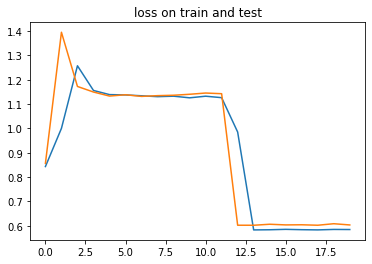

Last loss on train: 0.5847758948802948
Last loss on test: 0.6035748092751754


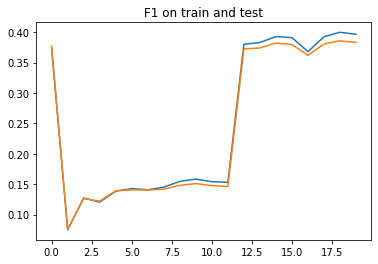

Last F1 on train: 0.3964075758657624
Last F1 on test: 0.38301996455380793


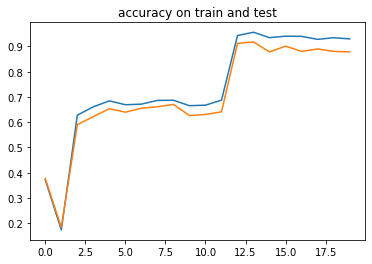

Last accuracy on train: 0.9298325258809909
Last accuracy on test: 0.8783231040364817


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.49377205729707285


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O sicher-B nicht-I .-O
--O keine-B ahnung-I .-O
das-B geht-I gar-I nicht-I .-O
keine-B ahnung-I .-O
du-B hast-I recht-I .-O
klar-B doch-I .-O
nein-O ,-O gar-B nicht-I .-O
--O ich-B weiß-I .-O
spinnst-B du-I ?-O !-O
nicht-B wahr-I ?-O
na-B gut-I .-O
keine-B ahnung-I .-O
--O ist-B schon-I gut-I .-O
wir-O kommen-O alle-O ,-O stimmt-B 's-I ?-O
ich-B weiß-I !-O
schon-B gut-I .-O
--O keine-B ahnung-I .-O
das-B ist-I es-I doch-I .-O
--O keine-B ahnung-I .-O
keine-B ahnung-I ,-O aber-O ein-O paar-O tage-O bestimmt-O noch-O .-O
gar-B nicht-I .-O
--O keine-B ahnung-I .-O
na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
--O gute-B idee-I .-O
--O dann-O ist-O sie-O eben-O 'ne-O frau-O ,-O na-B und-I ?-O
--O du-B hast-I recht-I .-O
na-B und-I ?-O
--O ach-B so-I !-O
ach-B was-I ,-O ihr-O beiden-O wusstet-O genau-O bescheid-O .-O
na-B gut-I ,-O kommt-O ,-O 2-O gegen-O einen-O .-O
keine-B ahnung-I .-O
machst-B du-I witze-I ?-O
ich-B denke-I schon-I .-O
--O ach-B was-I .-O
--O ganz-B 

# Experiment 1, testing weights (0.005, 1, 1)
* RNN
* uni
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = RNN(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


49it [00:01, 38.56it/s]

Train loss: 0.7066165155834622


97it [00:02, 40.31it/s]

Train loss: 0.6679451968934801


142it [00:03, 40.59it/s]

Train loss: 0.6510130476068567


187it [00:04, 41.74it/s]

Train loss: 0.6406667123238245


226it [00:05, 39.47it/s]


Train loss: 0.6349707243177626

Evaluating on train...


50it [00:01, 47.90it/s]

Val loss: 0.6153842197524176, Val f1: 0.3762320081392924, Val accuracy: 0.8051774978637696


96it [00:02, 44.69it/s]

Val loss: 0.604038143157959, Val f1: 0.37555837598111896, Val accuracy: 0.8445622238847944


140it [00:03, 43.35it/s]

Val loss: 0.6063864919874403, Val f1: 0.37513301262149107, Val accuracy: 0.8315144814826824


185it [00:04, 42.20it/s]

Val loss: 0.6043820682499144, Val f1: 0.37586278501484127, Val accuracy: 0.8393337595793936


226it [00:05, 43.83it/s]


Val loss: 0.6034722105662028, Val f1: 0.37704714430703057, Val accuracy: 0.8358917490641276

Evaluating on test...


20it [00:00, 42.18it/s]

Val loss: 0.6207430084546407, Val f1: 0.3740605076154073, Val accuracy: 0.7642342130343119


35it [00:00, 41.85it/s]

Val loss: 0.6198774298032125, Val f1: 0.3784777988990148, Val accuracy: 0.7998239119847615


50it [00:01, 43.46it/s]

Val loss: 0.6130611724323697, Val f1: 0.37478728029463027, Val accuracy: 0.7966915554470486


65it [00:01, 43.27it/s]

Val loss: 0.612980396548907, Val f1: 0.37346793711185455, Val accuracy: 0.7774848361810048


76it [00:01, 42.37it/s]


Val loss: 0.611509469350179, Val f1: 0.3728082422415415, Val accuracy: 0.7866646917661031

starting Epoch 1
Training...


53it [00:01, 39.66it/s]

Train loss: 0.5891417238447402


97it [00:02, 41.78it/s]

Train loss: 0.5955915384822421


142it [00:03, 41.12it/s]

Train loss: 0.5963365819719103


187it [00:04, 41.31it/s]

Train loss: 0.5957669132285648


226it [00:05, 40.27it/s]


Train loss: 0.5960235118865966

Evaluating on train...


53it [00:01, 49.55it/s]

Val loss: 0.5901499271392823, Val f1: 0.4067139387130737, Val accuracy: 0.8622955242792766


94it [00:01, 45.63it/s]

Val loss: 0.5890907413429685, Val f1: 0.40571978986263274, Val accuracy: 0.8486627333694035


144it [00:03, 44.63it/s]

Val loss: 0.5884971592161391, Val f1: 0.4054651105845416, Val accuracy: 0.8683516043203848


184it [00:04, 43.41it/s]

Val loss: 0.5877835098240111, Val f1: 0.4057436787419849, Val accuracy: 0.8694723503457176


226it [00:04, 45.25it/s]


Val loss: 0.5878842782974243, Val f1: 0.4049034122625987, Val accuracy: 0.8624015227953593

Evaluating on test...


20it [00:00, 42.42it/s]

Val loss: 0.5945982893308004, Val f1: 0.4019760409990946, Val accuracy: 0.8906270662943522


35it [00:00, 41.65it/s]

Val loss: 0.6026222983996073, Val f1: 0.4033240815003713, Val accuracy: 0.8282525986433029


50it [00:01, 42.77it/s]

Val loss: 0.6011050833596123, Val f1: 0.40664818353123133, Val accuracy: 0.8264584925439623


65it [00:01, 41.15it/s]

Val loss: 0.5982931564251582, Val f1: 0.4008813381195068, Val accuracy: 0.8304962038993835


76it [00:01, 42.12it/s]


Val loss: 0.6002776018778483, Val f1: 0.39857131719589234, Val accuracy: 0.8150293076038361

starting Epoch 2
Training...


51it [00:01, 40.31it/s]

Train loss: 0.5838946037822299


96it [00:02, 42.66it/s]

Train loss: 0.5878790789180331


141it [00:03, 41.88it/s]

Train loss: 0.5897001844865305


186it [00:04, 41.46it/s]

Train loss: 0.5888328784041934


226it [00:05, 40.19it/s]


Train loss: 0.5871518182754517

Evaluating on train...


53it [00:01, 48.85it/s]

Val loss: 0.5878420869509379, Val f1: 0.4107978562513987, Val accuracy: 0.8989965319633484


99it [00:02, 45.34it/s]

Val loss: 0.5844477633635203, Val f1: 0.41114147437943355, Val accuracy: 0.8905878560410605


139it [00:03, 42.99it/s]

Val loss: 0.5831553918344003, Val f1: 0.41055930874965807, Val accuracy: 0.8936247050762176


184it [00:04, 42.95it/s]

Val loss: 0.5854335483577516, Val f1: 0.41337514536248315, Val accuracy: 0.8884683706694179


226it [00:05, 44.57it/s]


Val loss: 0.5839456672138638, Val f1: 0.4122780834303962, Val accuracy: 0.8992454079786937

Evaluating on test...


20it [00:00, 40.22it/s]

Val loss: 0.5848965922991435, Val f1: 0.40023765166600545, Val accuracy: 0.847491455078125


35it [00:00, 41.44it/s]

Val loss: 0.5817831873893737, Val f1: 0.4013569881518682, Val accuracy: 0.8752725223700205


50it [00:01, 42.04it/s]

Val loss: 0.5881797234217326, Val f1: 0.4041613115204705, Val accuracy: 0.8688571386867099


65it [00:01, 42.55it/s]

Val loss: 0.5919413427511852, Val f1: 0.40223848074674606, Val accuracy: 0.8515324334303538


76it [00:01, 41.54it/s]


Val loss: 0.5949611870447794, Val f1: 0.4040406946341197, Val accuracy: 0.8471337350209555

starting Epoch 3
Training...


51it [00:01, 40.34it/s]

Train loss: 0.5878589590390523


96it [00:02, 40.82it/s]

Train loss: 0.5857283380296495


141it [00:03, 40.96it/s]

Train loss: 0.5868776771757338


186it [00:04, 41.37it/s]

Train loss: 0.5856873048676385


226it [00:05, 39.78it/s]


Train loss: 0.5856048152181837

Evaluating on train...


50it [00:01, 48.16it/s]

Val loss: 0.5773352172639635, Val f1: 0.38564191460609437, Val accuracy: 0.9053971310456593


95it [00:01, 46.18it/s]

Val loss: 0.5796754890018039, Val f1: 0.3898932658963733, Val accuracy: 0.8916178925169839


140it [00:03, 43.82it/s]

Val loss: 0.5804055258079811, Val f1: 0.3916530790152373, Val accuracy: 0.8921533438894483


185it [00:04, 42.37it/s]

Val loss: 0.5807834512657589, Val f1: 0.39208358310990865, Val accuracy: 0.8892049085762765


226it [00:05, 44.77it/s]


Val loss: 0.5818180349138048, Val f1: 0.3915267023775313, Val accuracy: 0.8788723058170742

Evaluating on test...


20it [00:00, 42.34it/s]

Val loss: 0.5911142230033875, Val f1: 0.38478904565175376, Val accuracy: 0.8617930869261424


35it [00:00, 41.12it/s]

Val loss: 0.5867722928524017, Val f1: 0.37906369268894197, Val accuracy: 0.8424047082662582


52it [00:01, 38.08it/s]

Val loss: 0.5911161065101623, Val f1: 0.3841155575381385, Val accuracy: 0.8583058377106985


64it [00:01, 37.39it/s]

Val loss: 0.5914342125256856, Val f1: 0.38410242398579914, Val accuracy: 0.8613470643758774


76it [00:01, 39.17it/s]


Val loss: 0.5933128460248311, Val f1: 0.3851823675632477, Val accuracy: 0.8580883391698202

starting Epoch 4
Training...


50it [00:01, 38.29it/s]

Train loss: 0.5842234889666239


98it [00:02, 41.88it/s]

Train loss: 0.5824254837301043


143it [00:03, 41.11it/s]

Train loss: 0.5849243883733396


188it [00:04, 42.11it/s]

Train loss: 0.5829107344150544


226it [00:05, 39.26it/s]


Train loss: 0.5836448115772671

Evaluating on train...


52it [00:01, 48.60it/s]

Val loss: 0.5810101535585191, Val f1: 0.39651369783613416, Val accuracy: 0.9139809648195902


98it [00:02, 46.52it/s]

Val loss: 0.5784275187386407, Val f1: 0.39766612516509164, Val accuracy: 0.9004171348280376


143it [00:03, 44.18it/s]

Val loss: 0.5806189020474751, Val f1: 0.3969188418653276, Val accuracy: 0.8992159514515489


188it [00:04, 43.52it/s]

Val loss: 0.5813149028354221, Val f1: 0.3988431493441264, Val accuracy: 0.9029330496986707


226it [00:05, 44.93it/s]


Val loss: 0.5821028497483995, Val f1: 0.39866654502020943, Val accuracy: 0.8986245736810896

Evaluating on test...


20it [00:00, 41.89it/s]

Val loss: 0.5788244048754374, Val f1: 0.3886447648207347, Val accuracy: 0.9544372876485189


35it [00:00, 42.15it/s]

Val loss: 0.5921021123727163, Val f1: 0.3850971738497416, Val accuracy: 0.8568063139915466


50it [00:01, 41.53it/s]

Val loss: 0.5916246308220757, Val f1: 0.3842596179909176, Val accuracy: 0.8480865074528589


65it [00:01, 41.09it/s]

Val loss: 0.5948031326134999, Val f1: 0.3880343159039815, Val accuracy: 0.8453637460867564


76it [00:01, 42.03it/s]


Val loss: 0.5943595925966899, Val f1: 0.389274715979894, Val accuracy: 0.8531198986371358

starting Epoch 5
Training...


49it [00:01, 38.65it/s]

Train loss: 0.584613127178616


97it [00:02, 41.83it/s]

Train loss: 0.585598373413086


142it [00:03, 42.24it/s]

Train loss: 0.5838589098718431


184it [00:04, 40.31it/s]

Train loss: 0.58504186073939


226it [00:05, 39.65it/s]


Train loss: 0.583463224834866

Evaluating on train...


50it [00:01, 42.39it/s]

Val loss: 0.583946164449056, Val f1: 0.37963280214203726, Val accuracy: 0.897952131430308


96it [00:02, 44.18it/s]

Val loss: 0.582433608505461, Val f1: 0.3823259307278527, Val accuracy: 0.9171505467759238


141it [00:03, 41.96it/s]

Val loss: 0.5848056691664236, Val f1: 0.3842667206569954, Val accuracy: 0.9169782786457626


186it [00:04, 42.49it/s]

Val loss: 0.5865645349025727, Val f1: 0.38441458096106845, Val accuracy: 0.9086475561062495


226it [00:05, 41.00it/s]


Val loss: 0.5858634742101033, Val f1: 0.38443946335050794, Val accuracy: 0.9114184355735779

Evaluating on test...


20it [00:00, 43.33it/s]

Val loss: 0.5944308042526245, Val f1: 0.376041179895401, Val accuracy: 0.8763162891070048


35it [00:00, 42.53it/s]

Val loss: 0.5973040143648783, Val f1: 0.37402519484361013, Val accuracy: 0.8466324478387832


50it [00:01, 42.35it/s]

Val loss: 0.6003420896000332, Val f1: 0.3722735722859701, Val accuracy: 0.8172949665122562


65it [00:01, 42.98it/s]

Val loss: 0.6005796084801356, Val f1: 0.37559563865264256, Val accuracy: 0.8364089235663414


76it [00:01, 42.69it/s]


Val loss: 0.5999650208155314, Val f1: 0.37495268940925597, Val accuracy: 0.8478330624103546

starting Epoch 6
Training...


50it [00:01, 39.13it/s]

Train loss: 0.5846445772382948


94it [00:02, 41.34it/s]

Train loss: 0.5817707849873437


139it [00:03, 41.34it/s]

Train loss: 0.5824388102248863


184it [00:04, 41.72it/s]

Train loss: 0.5829059104124705


226it [00:05, 40.10it/s]


Train loss: 0.583335223197937

Evaluating on train...


52it [00:01, 48.55it/s]

Val loss: 0.5803588244650099, Val f1: 0.3882760054535336, Val accuracy: 0.915436464548111


97it [00:02, 44.32it/s]

Val loss: 0.5794952823056115, Val f1: 0.3873756259679794, Val accuracy: 0.928053926759296


142it [00:03, 42.91it/s]

Val loss: 0.5803262335282785, Val f1: 0.3886053568787045, Val accuracy: 0.929100564232579


187it [00:04, 43.02it/s]

Val loss: 0.5811860147449706, Val f1: 0.38635384125841987, Val accuracy: 0.9231647782855563


226it [00:05, 44.85it/s]


Val loss: 0.5804150793287489, Val f1: 0.3852865641646915, Val accuracy: 0.9248502398861779

Evaluating on test...


20it [00:00, 41.45it/s]

Val loss: 0.5815616885821024, Val f1: 0.37580830256144204, Val accuracy: 0.9112316091855367


35it [00:00, 42.39it/s]

Val loss: 0.5909188787142435, Val f1: 0.37310849825541176, Val accuracy: 0.8876865943272908


50it [00:01, 42.96it/s]

Val loss: 0.5947313865025838, Val f1: 0.3762035482459598, Val accuracy: 0.877993803554111


65it [00:01, 42.44it/s]

Val loss: 0.5954129050175349, Val f1: 0.3763808563351631, Val accuracy: 0.8668407082557679


76it [00:01, 42.57it/s]


Val loss: 0.59279811779658, Val f1: 0.3760386061668396, Val accuracy: 0.8726120722293854

starting Epoch 7
Training...


52it [00:01, 39.76it/s]

Train loss: 0.5787369807561239


95it [00:02, 41.06it/s]

Train loss: 0.5808244473404355


140it [00:03, 41.99it/s]

Train loss: 0.5816899564531114


185it [00:04, 39.11it/s]

Train loss: 0.5820420755280389


226it [00:05, 40.06it/s]


Train loss: 0.582025728755527

Evaluating on train...


51it [00:01, 49.22it/s]

Val loss: 0.582509367995792, Val f1: 0.39959096908569336, Val accuracy: 0.9357037232981787


97it [00:02, 45.80it/s]

Val loss: 0.5802429848247104, Val f1: 0.40204315019978415, Val accuracy: 0.9339480949772729


142it [00:03, 44.63it/s]

Val loss: 0.581017064165186, Val f1: 0.4005861277933474, Val accuracy: 0.9347031677210772


187it [00:04, 41.94it/s]

Val loss: 0.5802025821473863, Val f1: 0.4001272307501899, Val accuracy: 0.9353915376795663


226it [00:05, 44.73it/s]


Val loss: 0.5787053283055623, Val f1: 0.3996138110425737, Val accuracy: 0.9373507597711351

Evaluating on test...


23it [00:00, 41.64it/s]

Val loss: 0.5895220041275024, Val f1: 0.3905010461807251, Val accuracy: 0.9212232112884522


38it [00:00, 42.83it/s]

Val loss: 0.5975981930891673, Val f1: 0.39107757310072583, Val accuracy: 0.8983778814474742


53it [00:01, 41.34it/s]

Val loss: 0.5964399615923563, Val f1: 0.38815421329604255, Val accuracy: 0.8924247370825873


68it [00:01, 41.56it/s]

Val loss: 0.592141842842102, Val f1: 0.38760206550359727, Val accuracy: 0.8950317353010178


76it [00:01, 41.70it/s]


Val loss: 0.5933158667882283, Val f1: 0.3874328688780467, Val accuracy: 0.8792144258817037

starting Epoch 8
Training...


53it [00:01, 39.71it/s]

Train loss: 0.5784851776229011


96it [00:02, 40.99it/s]

Train loss: 0.5770303871896532


141it [00:03, 40.56it/s]

Train loss: 0.5778489863431012


186it [00:04, 41.61it/s]

Train loss: 0.5802905049588946


226it [00:05, 39.83it/s]


Train loss: 0.5806567793422275

Evaluating on train...


53it [00:01, 47.91it/s]

Val loss: 0.5807031750679016, Val f1: 0.4202207432852851, Val accuracy: 0.9199665466944377


99it [00:02, 45.89it/s]

Val loss: 0.5800444583098093, Val f1: 0.41706170274151694, Val accuracy: 0.911201028029124


144it [00:03, 44.60it/s]

Val loss: 0.5787658236644886, Val f1: 0.41161718567212424, Val accuracy: 0.8942925751209259


184it [00:04, 42.57it/s]

Val loss: 0.579199172059695, Val f1: 0.41091940187745624, Val accuracy: 0.8955962374806404


226it [00:05, 45.17it/s]


Val loss: 0.5787785400284661, Val f1: 0.4112281064192454, Val accuracy: 0.8976444424523248

Evaluating on test...


20it [00:00, 43.27it/s]

Val loss: 0.5836786270141602, Val f1: 0.39600274165471394, Val accuracy: 0.9435506224632263


35it [00:00, 41.70it/s]

Val loss: 0.5897545516490936, Val f1: 0.3984351565440496, Val accuracy: 0.9199402034282684


50it [00:01, 41.57it/s]

Val loss: 0.5907623542679681, Val f1: 0.40039585365189445, Val accuracy: 0.9144070598814222


65it [00:01, 42.44it/s]

Val loss: 0.5914745926856995, Val f1: 0.4008652687072754, Val accuracy: 0.9087004373470943


76it [00:01, 42.45it/s]


Val loss: 0.5926986845334371, Val f1: 0.39637843092282615, Val accuracy: 0.896547619899114

starting Epoch 9
Training...


49it [00:01, 38.59it/s]

Train loss: 0.5838412682215373


94it [00:02, 40.40it/s]

Train loss: 0.5821755488713583


139it [00:03, 41.11it/s]

Train loss: 0.5826486282878451


184it [00:04, 41.88it/s]

Train loss: 0.5818097157610788


226it [00:05, 39.92it/s]


Train loss: 0.5815627996126811

Evaluating on train...


53it [00:01, 49.38it/s]

Val loss: 0.5794207440482245, Val f1: 0.40993409289254085, Val accuracy: 0.940139377117157


99it [00:02, 46.36it/s]

Val loss: 0.5811185154649946, Val f1: 0.409300195508533, Val accuracy: 0.9019917759630415


139it [00:02, 43.58it/s]

Val loss: 0.5800845923247161, Val f1: 0.40614499162744594, Val accuracy: 0.9099642166384945


184it [00:04, 42.94it/s]

Val loss: 0.5787927312983407, Val f1: 0.4076248385839992, Val accuracy: 0.9133477732539177


226it [00:05, 45.00it/s]


Val loss: 0.578740734524197, Val f1: 0.4059989747736189, Val accuracy: 0.9153324312633938

Evaluating on test...


20it [00:00, 41.22it/s]

Val loss: 0.6103325804074605, Val f1: 0.3971152365207672, Val accuracy: 0.8070810476938883


35it [00:00, 40.80it/s]

Val loss: 0.6032422542572021, Val f1: 0.39498839179674783, Val accuracy: 0.8438519974549611


50it [00:01, 42.28it/s]

Val loss: 0.5969388008117675, Val f1: 0.388854890399509, Val accuracy: 0.8639808568689559


65it [00:01, 41.96it/s]

Val loss: 0.595635732014974, Val f1: 0.3888753722111384, Val accuracy: 0.861032730837663


76it [00:01, 41.69it/s]


Val loss: 0.5933895500500997, Val f1: 0.3881014931201935, Val accuracy: 0.8604896370569864

starting Epoch 10
Training...


52it [00:01, 38.12it/s]

Train loss: 0.5751363237698873


98it [00:02, 40.97it/s]

Train loss: 0.577363700999154


143it [00:03, 40.53it/s]

Train loss: 0.578491257738184


188it [00:04, 40.83it/s]

Train loss: 0.5789822618166606


226it [00:05, 39.33it/s]


Train loss: 0.580950812233819

Evaluating on train...


52it [00:01, 49.02it/s]

Val loss: 0.5799893591139051, Val f1: 0.4023436963558197, Val accuracy: 0.9169627971119351


98it [00:02, 44.97it/s]

Val loss: 0.5794457362757789, Val f1: 0.4018249038192961, Val accuracy: 0.9059046086337831


143it [00:03, 43.54it/s]

Val loss: 0.5794529398282369, Val f1: 0.3991569931860323, Val accuracy: 0.8881596916251713


188it [00:04, 42.28it/s]

Val loss: 0.5790186256170273, Val f1: 0.399595455163055, Val accuracy: 0.8963189255860117


226it [00:05, 44.55it/s]


Val loss: 0.5790254357126025, Val f1: 0.40102984428405763, Val accuracy: 0.9029187156094445

Evaluating on test...


20it [00:00, 43.73it/s]

Val loss: 0.5876800735791524, Val f1: 0.38130168120066327, Val accuracy: 0.9356699029604594


35it [00:00, 41.99it/s]

Val loss: 0.5899583041667938, Val f1: 0.38695684174696604, Val accuracy: 0.9260295033454895


50it [00:01, 42.64it/s]

Val loss: 0.5885879145728217, Val f1: 0.3816840059227414, Val accuracy: 0.9044512430826823


65it [00:01, 41.55it/s]

Val loss: 0.5899283607800802, Val f1: 0.3840545748670896, Val accuracy: 0.8970067784190178


76it [00:01, 42.54it/s]


Val loss: 0.5907313521703085, Val f1: 0.38580291748046874, Val accuracy: 0.9028544096151988

starting Epoch 11
Training...


52it [00:01, 38.66it/s]

Train loss: 0.5829278230667114


97it [00:02, 40.24it/s]

Train loss: 0.5816865013705359


142it [00:03, 41.48it/s]

Train loss: 0.5828584807890432


187it [00:04, 41.13it/s]

Train loss: 0.5815387003951602


226it [00:05, 39.63it/s]


Train loss: 0.5809037947654724

Evaluating on train...


51it [00:01, 48.21it/s]

Val loss: 0.5836116856998868, Val f1: 0.44075432949595983, Val accuracy: 0.8570154772864448


97it [00:02, 44.49it/s]

Val loss: 0.5852191627025605, Val f1: 0.4379983878797955, Val accuracy: 0.8673336459530725


142it [00:03, 41.42it/s]

Val loss: 0.5865311410692003, Val f1: 0.43275312339818034, Val accuracy: 0.8576533920235104


187it [00:04, 41.94it/s]

Val loss: 0.584985578722424, Val f1: 0.4326342319448789, Val accuracy: 0.8613362474573983


226it [00:05, 44.18it/s]


Val loss: 0.58384660826789, Val f1: 0.43394091261757745, Val accuracy: 0.8704038023948669

Evaluating on test...


24it [00:00, 43.20it/s]

Val loss: 0.621797513961792, Val f1: 0.411277174949646, Val accuracy: 0.7433165232340495


34it [00:00, 41.98it/s]

Val loss: 0.6078476130962371, Val f1: 0.4126069605350494, Val accuracy: 0.7951082646846771


49it [00:01, 42.42it/s]

Val loss: 0.6091190099716186, Val f1: 0.41503077811665007, Val accuracy: 0.8130350404315525


64it [00:01, 42.51it/s]

Val loss: 0.6043452243010203, Val f1: 0.40886698067188265, Val accuracy: 0.8157105763753255


76it [00:01, 42.29it/s]


Val loss: 0.5998068428039551, Val f1: 0.4108989898363749, Val accuracy: 0.830360681215922

starting Epoch 12
Training...


53it [00:01, 35.33it/s]

Train loss: 0.5772682812478808


97it [00:02, 41.19it/s]

Train loss: 0.5778681695461273


142it [00:04, 41.66it/s]

Train loss: 0.5795238097508748


187it [00:05, 39.71it/s]

Train loss: 0.5803854627741708


226it [00:06, 37.22it/s]


Train loss: 0.5810594206386143

Evaluating on train...


52it [00:01, 47.52it/s]

Val loss: 0.5868754413392808, Val f1: 0.40059900614950394, Val accuracy: 0.8931427889400059


98it [00:02, 44.60it/s]

Val loss: 0.5819006284077962, Val f1: 0.40169221096568636, Val accuracy: 0.8977496713399887


143it [00:03, 41.50it/s]

Val loss: 0.5818688264599553, Val f1: 0.4063609743559802, Val accuracy: 0.891955558458964


188it [00:04, 41.56it/s]

Val loss: 0.5836664862102933, Val f1: 0.4083251832260026, Val accuracy: 0.8984890371561051


226it [00:05, 43.54it/s]


Val loss: 0.5830706800354851, Val f1: 0.4083143489890628, Val accuracy: 0.8963674228721195

Evaluating on test...


19it [00:00, 41.62it/s]

Val loss: 0.598789660135905, Val f1: 0.38615828156471255, Val accuracy: 0.8529725074768066


34it [00:00, 41.66it/s]

Val loss: 0.6000195781389872, Val f1: 0.3971591869990031, Val accuracy: 0.86208489437898


49it [00:01, 41.28it/s]

Val loss: 0.602670509285397, Val f1: 0.3906571262412601, Val accuracy: 0.8318179554409451


64it [00:01, 41.00it/s]

Val loss: 0.6020355880260467, Val f1: 0.38854281455278394, Val accuracy: 0.8377565344174703


76it [00:01, 41.30it/s]


Val loss: 0.5999220816294352, Val f1: 0.38865105867385863, Val accuracy: 0.8396100751558939

starting Epoch 13
Training...


49it [00:01, 38.53it/s]

Train loss: 0.5805885685814751


96it [00:02, 40.51it/s]

Train loss: 0.5783101605044471


141it [00:03, 40.65it/s]

Train loss: 0.5792552541803431


186it [00:04, 41.89it/s]

Train loss: 0.5819425019952986


226it [00:05, 39.47it/s]


Train loss: 0.5820632365014818

Evaluating on train...


50it [00:01, 48.04it/s]

Val loss: 0.5852695292896695, Val f1: 0.42009729676776464, Val accuracy: 0.8647464573383331


95it [00:02, 46.26it/s]

Val loss: 0.5838776177830166, Val f1: 0.4175407505697674, Val accuracy: 0.852801317638821


140it [00:03, 43.37it/s]

Val loss: 0.5848047680324978, Val f1: 0.4289320848606251, Val accuracy: 0.8625948133292022


185it [00:04, 41.42it/s]

Val loss: 0.5844488610823949, Val f1: 0.4310757777757115, Val accuracy: 0.8639551187554996


226it [00:05, 44.58it/s]


Val loss: 0.5846327585644192, Val f1: 0.4297609379556444, Val accuracy: 0.8590917987293667

Evaluating on test...


19it [00:00, 41.13it/s]

Val loss: 0.6028469204902649, Val f1: 0.4012809614340464, Val accuracy: 0.789915919303894


34it [00:00, 40.45it/s]

Val loss: 0.5974909385045369, Val f1: 0.40023323595523835, Val accuracy: 0.8032617121934891


54it [00:01, 42.39it/s]

Val loss: 0.5997944196065267, Val f1: 0.3992705656422509, Val accuracy: 0.8068414880169763


64it [00:01, 42.51it/s]

Val loss: 0.6017095893621445, Val f1: 0.40244657049576443, Val accuracy: 0.8047385210792224


76it [00:01, 41.43it/s]


Val loss: 0.6022425365447998, Val f1: 0.40318511803944906, Val accuracy: 0.8057384725411733

starting Epoch 14
Training...


52it [00:01, 38.60it/s]

Train loss: 0.5753655645582411


95it [00:02, 41.54it/s]

Train loss: 0.5767884075641632


140it [00:03, 41.35it/s]

Train loss: 0.5799201395776536


185it [00:04, 40.73it/s]

Train loss: 0.5805444359779358


226it [00:05, 39.61it/s]


Train loss: 0.580532046424018

Evaluating on train...


52it [00:01, 48.93it/s]

Val loss: 0.5755562080277337, Val f1: 0.41468921105066936, Val accuracy: 0.9255514211124845


98it [00:02, 45.51it/s]

Val loss: 0.5734150727589925, Val f1: 0.41233637862735323, Val accuracy: 0.9242406960990693


143it [00:03, 43.62it/s]

Val loss: 0.5751070795235811, Val f1: 0.4144216400605661, Val accuracy: 0.9232321719328562


188it [00:04, 43.18it/s]

Val loss: 0.5763478335407045, Val f1: 0.4159222109450234, Val accuracy: 0.9188265871670511


226it [00:05, 44.46it/s]


Val loss: 0.5783338228861491, Val f1: 0.4135108811325497, Val accuracy: 0.9105375105804867

Evaluating on test...


20it [00:00, 42.55it/s]

Val loss: 0.6063965638478597, Val f1: 0.396117103099823, Val accuracy: 0.882229232788086


35it [00:00, 41.02it/s]

Val loss: 0.5992609262466431, Val f1: 0.3890156358480453, Val accuracy: 0.8527818083763122


50it [00:01, 41.93it/s]

Val loss: 0.5961344877878825, Val f1: 0.38793601526154414, Val accuracy: 0.8633268376191457


65it [00:01, 41.40it/s]

Val loss: 0.595401594042778, Val f1: 0.39138810882965724, Val accuracy: 0.8694040035208066


76it [00:01, 41.43it/s]


Val loss: 0.5956184641520182, Val f1: 0.3929800581932068, Val accuracy: 0.8700930424531301

starting Epoch 15
Training...


51it [00:01, 40.63it/s]

Train loss: 0.5778649926185608


96it [00:02, 40.55it/s]

Train loss: 0.5803098022937775


141it [00:03, 40.60it/s]

Train loss: 0.5813454102586817


186it [00:04, 40.93it/s]

Train loss: 0.5807951152324676


226it [00:05, 39.64it/s]


Train loss: 0.5797519053353204

Evaluating on train...


51it [00:01, 48.03it/s]

Val loss: 0.583091774251726, Val f1: 0.4363610651757982, Val accuracy: 0.9015174243185256


96it [00:02, 44.09it/s]

Val loss: 0.5796348273754119, Val f1: 0.43356726235813564, Val accuracy: 0.8943296783500247


141it [00:03, 42.67it/s]

Val loss: 0.5823687840391089, Val f1: 0.43367551079502814, Val accuracy: 0.8962921482545358


186it [00:04, 41.29it/s]

Val loss: 0.5809023820691639, Val f1: 0.4313451768623458, Val accuracy: 0.900539793074131


226it [00:05, 44.29it/s]


Val loss: 0.5807308096355862, Val f1: 0.42939896093474494, Val accuracy: 0.8939089228047264

Evaluating on test...


23it [00:00, 41.70it/s]

Val loss: 0.5873142043749492, Val f1: 0.3903404692808787, Val accuracy: 0.8418087065219879


38it [00:00, 42.25it/s]

Val loss: 0.5953978061676025, Val f1: 0.397229931751887, Val accuracy: 0.8276426444451014


53it [00:01, 42.30it/s]

Val loss: 0.5938146776623197, Val f1: 0.399471687608295, Val accuracy: 0.8489241845077938


68it [00:01, 41.96it/s]

Val loss: 0.595063571135203, Val f1: 0.3977326174577077, Val accuracy: 0.8349642544984818


76it [00:01, 41.84it/s]


Val loss: 0.5953729693094889, Val f1: 0.3999348247051239, Val accuracy: 0.8453315806388855

starting Epoch 16
Training...


50it [00:01, 38.25it/s]

Train loss: 0.5795456462436253


94it [00:02, 40.47it/s]

Train loss: 0.5805905997753144


139it [00:03, 41.67it/s]

Train loss: 0.5789246996243794


188it [00:04, 39.76it/s]

Train loss: 0.5784836272398631


226it [00:05, 39.48it/s]


Train loss: 0.5799863200717502

Evaluating on train...


52it [00:01, 48.76it/s]

Val loss: 0.5793291939629449, Val f1: 0.4043520490328471, Val accuracy: 0.9181431273619334


98it [00:02, 46.63it/s]

Val loss: 0.5790429280863868, Val f1: 0.409346557325787, Val accuracy: 0.9279514527983136


143it [00:03, 43.84it/s]

Val loss: 0.5789311532621031, Val f1: 0.41085347135861716, Val accuracy: 0.927921978853367


188it [00:04, 41.15it/s]

Val loss: 0.5794583900107277, Val f1: 0.40673835310671064, Val accuracy: 0.9199532179368867


226it [00:05, 44.39it/s]


Val loss: 0.5803962005509271, Val f1: 0.40509317543771534, Val accuracy: 0.906909152534273

Evaluating on test...


19it [00:00, 41.01it/s]

Val loss: 0.5930193583170573, Val f1: 0.3819422125816345, Val accuracy: 0.9070133328437805


34it [00:00, 41.47it/s]

Val loss: 0.5918096741040547, Val f1: 0.38705803255240123, Val accuracy: 0.9184941311677297


49it [00:01, 41.29it/s]

Val loss: 0.5913542098469204, Val f1: 0.38563261297014023, Val accuracy: 0.9075666275289324


64it [00:01, 41.33it/s]

Val loss: 0.5932969103256861, Val f1: 0.3831660509109497, Val accuracy: 0.8970320319135984


76it [00:01, 41.61it/s]


Val loss: 0.5946324523289999, Val f1: 0.3833426304658254, Val accuracy: 0.8941702791055044

starting Epoch 17
Training...


52it [00:01, 38.95it/s]

Train loss: 0.5797007176611159


94it [00:02, 40.00it/s]

Train loss: 0.582185877694024


141it [00:03, 39.00it/s]

Train loss: 0.5809196088049147


185it [00:04, 38.74it/s]

Train loss: 0.5798771874772177


226it [00:05, 38.84it/s]


Train loss: 0.5792708370420668

Evaluating on train...


51it [00:01, 46.30it/s]

Val loss: 0.5718993624051412, Val f1: 0.39485978219244217, Val accuracy: 0.9410196920235951


96it [00:02, 44.78it/s]

Val loss: 0.5777640375826094, Val f1: 0.3988693998919593, Val accuracy: 0.9351693633529875


141it [00:03, 42.27it/s]

Val loss: 0.5772947814729479, Val f1: 0.39970807631810507, Val accuracy: 0.9330365075005426


186it [00:04, 41.23it/s]

Val loss: 0.5777169386545817, Val f1: 0.397454677356614, Val accuracy: 0.9352420952585009


226it [00:05, 43.44it/s]


Val loss: 0.5776114596260918, Val f1: 0.39612140695254006, Val accuracy: 0.9319771639506023

Evaluating on test...


19it [00:00, 41.56it/s]

Val loss: 0.5933740099271139, Val f1: 0.3707986036936442, Val accuracy: 0.8571498076121012


34it [00:00, 40.00it/s]

Val loss: 0.5917406717936198, Val f1: 0.3842074861129125, Val accuracy: 0.898693726460139


49it [00:01, 40.91it/s]

Val loss: 0.591797935962677, Val f1: 0.3788705276118384, Val accuracy: 0.8784698605537414


64it [00:01, 41.42it/s]

Val loss: 0.5926071812709173, Val f1: 0.3789428348342578, Val accuracy: 0.8742357790470123


76it [00:01, 41.13it/s]


Val loss: 0.5923410789171855, Val f1: 0.3798069099585215, Val accuracy: 0.8866042455037435

starting Epoch 18
Training...


51it [00:01, 37.96it/s]

Train loss: 0.5765993475914002


95it [00:02, 41.37it/s]

Train loss: 0.5768486532900069


139it [00:03, 41.12it/s]

Train loss: 0.5784778784822535


184it [00:04, 41.05it/s]

Train loss: 0.5772791849242316


226it [00:05, 39.53it/s]


Train loss: 0.5795665746264987

Evaluating on train...


50it [00:01, 47.43it/s]

Val loss: 0.5746562242507934, Val f1: 0.39455080959531996, Val accuracy: 0.8903084688716465


95it [00:02, 45.59it/s]

Val loss: 0.5777498073048062, Val f1: 0.3971721894211239, Val accuracy: 0.9043845123714871


140it [00:03, 37.81it/s]

Val loss: 0.5772436932281212, Val f1: 0.3959684113661448, Val accuracy: 0.9042215629860207


185it [00:04, 41.33it/s]

Val loss: 0.5773760477701823, Val f1: 0.3964155667357975, Val accuracy: 0.9192489587598377


226it [00:05, 40.85it/s]


Val loss: 0.5775550654199388, Val f1: 0.3959644361337026, Val accuracy: 0.9243238288826413

Evaluating on test...


19it [00:00, 41.55it/s]

Val loss: 0.5863038659095764, Val f1: 0.37710230350494384, Val accuracy: 0.8390426119168599


34it [00:00, 42.07it/s]

Val loss: 0.5860925575097402, Val f1: 0.3790716856718063, Val accuracy: 0.8719299048185348


49it [00:01, 41.32it/s]

Val loss: 0.5921506179703606, Val f1: 0.37777451210551793, Val accuracy: 0.8607276651594374


64it [00:01, 42.07it/s]

Val loss: 0.5951765696207683, Val f1: 0.3799660618106524, Val accuracy: 0.8633179148038228


76it [00:01, 41.90it/s]


Val loss: 0.5940606617927551, Val f1: 0.3777219605445862, Val accuracy: 0.8645821301142375

starting Epoch 19
Training...


52it [00:01, 39.40it/s]

Train loss: 0.575071472591824


98it [00:02, 40.50it/s]

Train loss: 0.5762490636772579


143it [00:03, 41.06it/s]

Train loss: 0.576986900082341


188it [00:04, 41.66it/s]

Train loss: 0.579765679107772


226it [00:05, 39.41it/s]


Train loss: 0.5794186298052469

Evaluating on train...


50it [00:01, 44.81it/s]

Val loss: 0.5798343234592014, Val f1: 0.42031069066789417, Val accuracy: 0.9251973999871148


95it [00:02, 44.30it/s]

Val loss: 0.5790725237793393, Val f1: 0.42562417884667714, Val accuracy: 0.9256425665484534


140it [00:03, 42.98it/s]

Val loss: 0.5777136065341808, Val f1: 0.42422411883318867, Val accuracy: 0.9107124068118908


185it [00:04, 43.28it/s]

Val loss: 0.5772874464591344, Val f1: 0.4235784805483288, Val accuracy: 0.8982941440410084


226it [00:05, 43.13it/s]


Val loss: 0.5778570214907328, Val f1: 0.42315369235144723, Val accuracy: 0.8946493266688453

Evaluating on test...


19it [00:00, 40.74it/s]

Val loss: 0.5789632678031922, Val f1: 0.4029871424039205, Val accuracy: 0.8849191586176555


39it [00:00, 42.86it/s]

Val loss: 0.5860589663187663, Val f1: 0.39788127144177754, Val accuracy: 0.8432397623856862


49it [00:01, 43.12it/s]

Val loss: 0.5926332632700603, Val f1: 0.3979326844215393, Val accuracy: 0.8453953994645013


64it [00:01, 40.80it/s]

Val loss: 0.592542921503385, Val f1: 0.39480245411396026, Val accuracy: 0.8354676847656568


76it [00:01, 41.65it/s]

Val loss: 0.5939421319961548, Val f1: 0.3933682914574941, Val accuracy: 0.8214741778373719


## Graphics

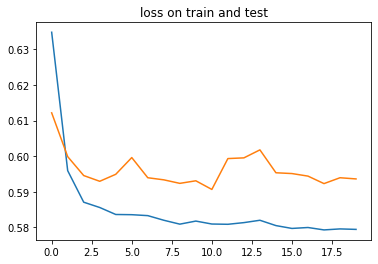

Last loss on train: 0.5794089257189657
Last loss on test: 0.5935869358087841


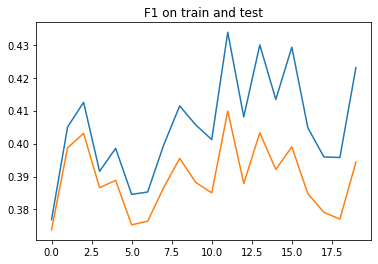

Last F1 on train: 0.42303810947764237
Last F1 on test: 0.3943447282439784


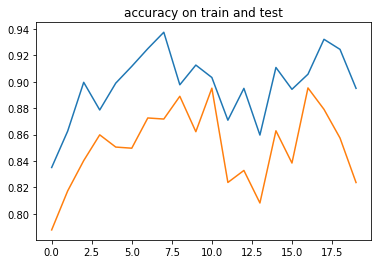

Last accuracy on train: 0.895101919242766
Last accuracy on test: 0.8237184811579553


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.6897965538717044


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

nein-O ,-O schon-B gut-I .-O
nicht-B wahr-I ,-O carrie-O ?-O
du-B hast-I recht-I .-O
--O gute-B idee-I .-O
ja-O ,-O ich-B verstehe-I .-O
--O keine-B ahnung-I .-O
ach-B was-I ,-O ihr-O beiden-O wusstet-O genau-O bescheid-O .-O
keine-B ahnung-I .-O
--O machen-B sie-I witze-I ?-O
ja-O ,-O nicht-B wahr-I ?-O
hör-B auf-I !-O
--O keine-B ahnung-I .-O
keine-B ahnung-I .-O
nein-O ,-O das-B geht-I nicht-I .-O
--O machst-B du-I witze-I ?-O
keine-B ahnung-I .-O
keine-B ahnung-I .-O
--O stimmt-B nicht-I .-O
keine-B ahnung-I .-O
keine-B ahnung-I .-O
du-B hast-I recht-I .-O
--O ach-B ja-I ?-O
im-B ernst-I !-O
ist-B schon-I ok-I .-O
--O das-B stimmt-I nicht-I .-O
--O keine-B ahnung-I .-O
--O ganz-B genau-I .-O
lhr-O kennt-O doch-O meinen-O vater-O ,-O stimmt-B 's-I ?-O
in-B ordnung-I .-O
keine-B ahnung-I .-O
hör-B auf-I ,-O valiente-O !-O
--O scheiß-B drauf-I .-O
na-B gut-I .-O
das-B stimmt-I .-O
--O na-B keine-I ahnung-I ,-O ey-O .-O
in-B ordnung-I !-O
was-B soll-I 's-I .-O
--O das-B geht-I nicht-I 

# Experiment 1, testing weights (0.01, 1, 1)
* RNN
* uni
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = RNN(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.01, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:01, 39.30it/s]

Train loss: 0.6515853179825677


94it [00:02, 40.96it/s]

Train loss: 0.6489786452717251


139it [00:03, 42.24it/s]

Train loss: 0.6424916232073749


184it [00:04, 40.05it/s]

Train loss: 0.6386322465207842


226it [00:05, 40.01it/s]


Train loss: 0.6404265403747559

Evaluating on train...


53it [00:01, 49.66it/s]

Val loss: 0.6403765625423855, Val f1: 0.36279600858688354, Val accuracy: 0.36296297245555453


99it [00:02, 46.61it/s]

Val loss: 0.6436551789442698, Val f1: 0.3627878795067469, Val accuracy: 0.36296297245555453


139it [00:02, 43.82it/s]

Val loss: 0.6442836099200778, Val f1: 0.3627853583406519, Val accuracy: 0.36296055846744113


184it [00:04, 39.84it/s]

Val loss: 0.6394892950852712, Val f1: 0.362795860071977, Val accuracy: 0.3629611619644695


226it [00:05, 44.26it/s]


Val loss: 0.6384385304980807, Val f1: 0.3598343532615238, Val accuracy: 0.35999684347046745

Evaluating on test...


20it [00:00, 43.37it/s]

Val loss: 0.6328609307607015, Val f1: 0.33317776918411257, Val accuracy: 0.33332986434300743


35it [00:00, 43.32it/s]

Val loss: 0.6401300509770711, Val f1: 0.33316434025764463, Val accuracy: 0.3333316038052241


50it [00:01, 42.96it/s]

Val loss: 0.6445439431402419, Val f1: 0.3479692300160726, Val accuracy: 0.3481469982200199


65it [00:01, 43.15it/s]

Val loss: 0.6446619858344396, Val f1: 0.3442664220929146, Val accuracy: 0.3444435844818751


76it [00:01, 43.11it/s]


Val loss: 0.6421980762481689, Val f1: 0.342048708597819, Val accuracy: 0.34221863945325215

starting Epoch 1
Training...


51it [00:01, 40.23it/s]

Train loss: 0.6342065572738648


95it [00:02, 42.02it/s]

Train loss: 0.6345633864402771


140it [00:03, 42.27it/s]

Train loss: 0.6371934661158809


185it [00:04, 41.85it/s]

Train loss: 0.6383149786127938


226it [00:05, 40.44it/s]


Train loss: 0.636640858915117

Evaluating on train...


53it [00:01, 49.10it/s]

Val loss: 0.6390926904148526, Val f1: 0.36279461052682666, Val accuracy: 0.36296297245555453


95it [00:01, 47.20it/s]

Val loss: 0.6412065684795379, Val f1: 0.36278831395837996, Val accuracy: 0.36295507583353254


140it [00:02, 44.52it/s]

Val loss: 0.6354084187083774, Val f1: 0.3776162878230766, Val accuracy: 0.37777206323764945


185it [00:04, 43.93it/s]

Val loss: 0.6369090378284454, Val f1: 0.37020646002557545, Val accuracy: 0.3703652827276124


226it [00:04, 45.24it/s]


Val loss: 0.637247790230645, Val f1: 0.37464978324042425, Val accuracy: 0.37480945971277024

Evaluating on test...


20it [00:00, 43.16it/s]

Val loss: 0.6545759598414104, Val f1: 0.37758033474286395, Val accuracy: 0.3777777870496114


35it [00:00, 42.57it/s]

Val loss: 0.6469821075598399, Val f1: 0.35537360807259877, Val accuracy: 0.3555555651585261


50it [00:01, 43.14it/s]

Val loss: 0.6444230861133999, Val f1: 0.34797168175379434, Val accuracy: 0.34814815786149766


65it [00:01, 40.73it/s]

Val loss: 0.6442961066961288, Val f1: 0.34426556279261905, Val accuracy: 0.3444383417566617


76it [00:01, 42.44it/s]


Val loss: 0.6419961762428283, Val f1: 0.34204891403516136, Val accuracy: 0.34221734205881754

starting Epoch 2
Training...


49it [00:01, 39.73it/s]

Train loss: 0.6363035360972087


98it [00:02, 41.32it/s]

Train loss: 0.6354369315836165


143it [00:03, 42.57it/s]

Train loss: 0.6395822882652282


188it [00:04, 42.44it/s]

Train loss: 0.639705862932735


226it [00:05, 40.21it/s]


Train loss: 0.6371795548333062

Evaluating on train...


50it [00:01, 48.31it/s]

Val loss: 0.6296898815366957, Val f1: 0.36281617482503253, Val accuracy: 0.36296033991707694


96it [00:01, 47.64it/s]

Val loss: 0.634762990474701, Val f1: 0.3628042376703686, Val accuracy: 0.36295838720268675


141it [00:03, 45.18it/s]

Val loss: 0.634687453729135, Val f1: 0.3628041936291589, Val accuracy: 0.362959623116034


186it [00:04, 43.24it/s]

Val loss: 0.6366624448034498, Val f1: 0.3553933322429657, Val accuracy: 0.35555305315388575


226it [00:05, 45.17it/s]


Val loss: 0.6378512581189474, Val f1: 0.35687168876330055, Val accuracy: 0.3570332540406121

Evaluating on test...


19it [00:00, 41.85it/s]

Val loss: 0.6588535626729329, Val f1: 0.3331195573012034, Val accuracy: 0.33331782221794126


39it [00:01, 31.66it/s]

Val loss: 0.6430713315804799, Val f1: 0.3331565360228221, Val accuracy: 0.33332558274269103


49it [00:01, 36.31it/s]

Val loss: 0.6421476629045274, Val f1: 0.3479743672741784, Val accuracy: 0.34814298417833117


64it [00:01, 40.69it/s]

Val loss: 0.6421383202075959, Val f1: 0.34427186846733093, Val accuracy: 0.34444057395060856


76it [00:02, 35.25it/s]


Val loss: 0.6386984499295553, Val f1: 0.3509460763136546, Val accuracy: 0.35110801657040913

starting Epoch 3
Training...


49it [00:01, 38.82it/s]

Train loss: 0.6344073653221131


94it [00:02, 40.95it/s]

Train loss: 0.6297625170813667


139it [00:03, 41.80it/s]

Train loss: 0.6344449422977588


184it [00:04, 42.20it/s]

Train loss: 0.6365800433688693


226it [00:05, 40.37it/s]


Train loss: 0.6356644656923082

Evaluating on train...


53it [00:01, 49.76it/s]

Val loss: 0.6358876824378967, Val f1: 0.3870861563417647, Val accuracy: 0.3867200083202786


98it [00:02, 47.21it/s]

Val loss: 0.6408779316478306, Val f1: 0.3600886944267485, Val accuracy: 0.35996332897080313


143it [00:03, 44.26it/s]

Val loss: 0.639271640336072, Val f1: 0.3609827001889547, Val accuracy: 0.3609412286016676


188it [00:04, 43.01it/s]

Val loss: 0.6383918411201901, Val f1: 0.35772648586167227, Val accuracy: 0.3577268517679638


226it [00:04, 45.70it/s]


Val loss: 0.6366402530670165, Val f1: 0.3528034665849474, Val accuracy: 0.3528169596195221

Evaluating on test...


20it [00:00, 43.27it/s]

Val loss: 0.6482681234677633, Val f1: 0.3330868939558665, Val accuracy: 0.3332194447517395


35it [00:00, 43.17it/s]

Val loss: 0.6453456779321035, Val f1: 0.3330650061368942, Val accuracy: 0.333159730831782


50it [00:01, 40.35it/s]

Val loss: 0.6465793344709608, Val f1: 0.33307795392142403, Val accuracy: 0.33318776819441054


65it [00:01, 42.10it/s]

Val loss: 0.6430446575085322, Val f1: 0.3330957944194476, Val accuracy: 0.3332072079181671


76it [00:01, 42.14it/s]


Val loss: 0.6417215665181478, Val f1: 0.3331058041254679, Val accuracy: 0.3332209837436676

starting Epoch 4
Training...


53it [00:01, 40.30it/s]

Train loss: 0.6333693345387776


98it [00:02, 42.02it/s]

Train loss: 0.6362999260425568


143it [00:03, 42.47it/s]

Train loss: 0.6371581505846095


188it [00:04, 42.00it/s]

Train loss: 0.6376507924662695


226it [00:05, 40.49it/s]


Train loss: 0.6378745142618815

Evaluating on train...


54it [00:01, 49.61it/s]

Val loss: 0.6379529900021024, Val f1: 0.3331359406312307, Val accuracy: 0.33326182696554396


95it [00:01, 47.22it/s]

Val loss: 0.6351615919007195, Val f1: 0.3479544172684352, Val accuracy: 0.3480764071146647


140it [00:02, 44.30it/s]

Val loss: 0.6371090937543799, Val f1: 0.34793386459350584, Val accuracy: 0.34804190044049865


185it [00:04, 42.55it/s]

Val loss: 0.6357965032259624, Val f1: 0.3479357792271508, Val accuracy: 0.34804081320762636


226it [00:04, 45.43it/s]


Val loss: 0.6364738490846422, Val f1: 0.34497189826435515, Val accuracy: 0.34507830288675095

Evaluating on test...


19it [00:00, 28.45it/s]

Val loss: 0.631210724512736, Val f1: 0.33315337896347047, Val accuracy: 0.3332722783088684


34it [00:01, 22.23it/s]

Val loss: 0.6395410100618998, Val f1: 0.33313923279444374, Val accuracy: 0.3332756499449412


49it [00:01, 34.44it/s]

Val loss: 0.6388415628009372, Val f1: 0.3627578914165497, Val accuracy: 0.362881949212816


64it [00:02, 39.29it/s]

Val loss: 0.6381775428851445, Val f1: 0.3664531817038854, Val accuracy: 0.36656484653552374


76it [00:02, 32.32it/s]


Val loss: 0.641143402258555, Val f1: 0.359784277677536, Val accuracy: 0.35990658164024353

starting Epoch 5
Training...


52it [00:01, 40.16it/s]

Train loss: 0.6506367723147074


97it [00:02, 41.30it/s]

Train loss: 0.6439827726946936


142it [00:03, 41.34it/s]

Train loss: 0.6419805102878147


187it [00:04, 41.42it/s]

Train loss: 0.6374208165539635


226it [00:05, 40.11it/s]


Train loss: 0.6376221863428752

Evaluating on train...


52it [00:01, 48.11it/s]

Val loss: 0.6360833843549093, Val f1: 0.3627776834699843, Val accuracy: 0.3629120906194051


99it [00:02, 46.17it/s]

Val loss: 0.6372420211633046, Val f1: 0.355366019739045, Val accuracy: 0.35549928612179227


144it [00:03, 44.05it/s]

Val loss: 0.635178334624679, Val f1: 0.35784240298800996, Val accuracy: 0.35797404558570295


184it [00:03, 42.94it/s]

Val loss: 0.6363701068692738, Val f1: 0.3553692276279132, Val accuracy: 0.3555027378929986


226it [00:04, 45.40it/s]


Val loss: 0.6368499565124511, Val f1: 0.35092234068446687, Val accuracy: 0.35105524275037975

Evaluating on test...


20it [00:00, 42.53it/s]

Val loss: 0.6281258980433146, Val f1: 0.4220556378364563, Val accuracy: 0.4221855898698171


35it [00:00, 42.71it/s]

Val loss: 0.6351583282152812, Val f1: 0.39981649319330853, Val accuracy: 0.3999510576327642


50it [00:01, 41.73it/s]

Val loss: 0.6442550950580173, Val f1: 0.37756728331247963, Val accuracy: 0.377712125910653


65it [00:01, 43.74it/s]

Val loss: 0.6423529992500941, Val f1: 0.36646595696608225, Val accuracy: 0.36661268075307213


76it [00:01, 43.03it/s]


Val loss: 0.6429834636052449, Val f1: 0.35980084498723347, Val accuracy: 0.3599522606531779

starting Epoch 6
Training...


49it [00:01, 39.63it/s]

Train loss: 0.6345578538046943


94it [00:02, 41.23it/s]

Train loss: 0.631141357951694


139it [00:03, 41.37it/s]

Train loss: 0.6317521320448981


184it [00:04, 40.59it/s]

Train loss: 0.6342555562655131


226it [00:05, 39.94it/s]


Train loss: 0.6362375587887235

Evaluating on train...


51it [00:01, 48.88it/s]

Val loss: 0.6392757574717204, Val f1: 0.3479437424076928, Val accuracy: 0.3480698618623945


96it [00:02, 46.34it/s]

Val loss: 0.6351064317756229, Val f1: 0.35534475677543215, Val accuracy: 0.35544821553760103


141it [00:03, 43.66it/s]

Val loss: 0.6398233179692869, Val f1: 0.35285889793325353, Val accuracy: 0.35296543019789234


186it [00:04, 43.09it/s]

Val loss: 0.6382984879944059, Val f1: 0.35626309911410015, Val accuracy: 0.35637313723564146


226it [00:05, 45.16it/s]


Val loss: 0.6368950714005365, Val f1: 0.3583088138368395, Val accuracy: 0.3584215663539039

Evaluating on test...


20it [00:00, 40.39it/s]

Val loss: 0.6488364179929097, Val f1: 0.33314778804779055, Val accuracy: 0.3333333432674408


34it [00:00, 39.31it/s]

Val loss: 0.641508412361145, Val f1: 0.3553605943918228, Val accuracy: 0.3555045773585637


49it [00:01, 42.31it/s]

Val loss: 0.6389401978916592, Val f1: 0.3479529241720835, Val accuracy: 0.34808628691567317


64it [00:01, 42.88it/s]

Val loss: 0.6439216246207555, Val f1: 0.34424547950426737, Val accuracy: 0.34439587940772376


76it [00:01, 41.28it/s]


Val loss: 0.6422942090034485, Val f1: 0.3420205827554067, Val accuracy: 0.3421605694293976

starting Epoch 7
Training...


51it [00:01, 40.21it/s]

Train loss: 0.640121853351593


96it [00:02, 39.95it/s]

Train loss: 0.6432712919182247


141it [00:03, 41.99it/s]

Train loss: 0.640436354831413


186it [00:04, 41.54it/s]

Train loss: 0.6357995741897159


226it [00:05, 40.19it/s]


Train loss: 0.6364299252298143

Evaluating on train...


53it [00:01, 49.70it/s]

Val loss: 0.63560082382626, Val f1: 0.34794948763317535, Val accuracy: 0.34806617763307357


97it [00:01, 47.28it/s]

Val loss: 0.640785817305247, Val f1: 0.3479370633761088, Val accuracy: 0.34806279374493493


142it [00:03, 41.97it/s]

Val loss: 0.6371899247169495, Val f1: 0.3479555752542284, Val accuracy: 0.3480852414060522


187it [00:04, 42.94it/s]

Val loss: 0.6340735511647331, Val f1: 0.353001138733493, Val accuracy: 0.3545630666944716


226it [00:04, 45.27it/s]


Val loss: 0.6367194106843737, Val f1: 0.3497628287474314, Val accuracy: 0.35103992382685345

Evaluating on test...


20it [00:00, 42.79it/s]

Val loss: 0.6426987012227376, Val f1: 0.37757195234298707, Val accuracy: 0.37771255572636925


35it [00:00, 42.46it/s]

Val loss: 0.6374656836191813, Val f1: 0.37759113709131875, Val accuracy: 0.37772882779439293


50it [00:01, 41.83it/s]

Val loss: 0.6436728080113728, Val f1: 0.36275068786409165, Val accuracy: 0.3628854731718699


65it [00:01, 40.29it/s]

Val loss: 0.6462274094422659, Val f1: 0.355340609451135, Val accuracy: 0.35548233389854433


76it [00:01, 41.99it/s]


Val loss: 0.6441221555074056, Val f1: 0.3508953642845154, Val accuracy: 0.35102752963701883

starting Epoch 8
Training...


52it [00:01, 40.24it/s]

Train loss: 0.6257652017805312


97it [00:02, 41.95it/s]

Train loss: 0.6305484500196245


142it [00:03, 42.24it/s]

Train loss: 0.6341718413211681


187it [00:04, 42.42it/s]

Train loss: 0.6371193961964713


226it [00:05, 40.39it/s]


Train loss: 0.6371151638031006

Evaluating on train...


53it [00:01, 49.60it/s]

Val loss: 0.639014020231035, Val f1: 0.3479372825887468, Val accuracy: 0.34805075261327956


98it [00:02, 47.09it/s]

Val loss: 0.6408439517021179, Val f1: 0.36276084383328755, Val accuracy: 0.36289428505632615


143it [00:03, 44.79it/s]

Val loss: 0.6395759953392877, Val f1: 0.3627719887980708, Val accuracy: 0.3629125760661231


188it [00:04, 44.10it/s]

Val loss: 0.6386175615919961, Val f1: 0.3701822030875418, Val accuracy: 0.3703224127491315


226it [00:04, 45.35it/s]


Val loss: 0.6368357083532545, Val f1: 0.37166705860031973, Val accuracy: 0.37180358012517295

Evaluating on test...


20it [00:00, 42.03it/s]

Val loss: 0.6400808811187744, Val f1: 0.3776115814844767, Val accuracy: 0.3777777870496114


35it [00:00, 42.41it/s]

Val loss: 0.6484741330146789, Val f1: 0.38313410778840384, Val accuracy: 0.3833049019177755


50it [00:01, 42.31it/s]

Val loss: 0.6466151356697083, Val f1: 0.3664639241165585, Val accuracy: 0.36662218239572314


65it [00:01, 42.74it/s]

Val loss: 0.6448304186264674, Val f1: 0.36924685140450797, Val accuracy: 0.3694027344385783


76it [00:01, 42.34it/s]


Val loss: 0.6418378647168478, Val f1: 0.36203179121017454, Val accuracy: 0.36218177278836566

starting Epoch 9
Training...


51it [00:01, 38.94it/s]

Train loss: 0.6389106565051609


96it [00:02, 41.34it/s]

Train loss: 0.6424714313613044


141it [00:03, 42.32it/s]

Train loss: 0.6378013438648648


186it [00:04, 40.29it/s]

Train loss: 0.6370905607938766


226it [00:05, 40.21it/s]


Train loss: 0.6371933992703755

Evaluating on train...


53it [00:01, 39.51it/s]

Val loss: 0.6412117560704549, Val f1: 0.3479658987787035, Val accuracy: 0.34811925490697226


99it [00:02, 44.49it/s]

Val loss: 0.6343722158008152, Val f1: 0.37761140962441764, Val accuracy: 0.3777557869752248


139it [00:03, 42.15it/s]

Val loss: 0.6332344443709762, Val f1: 0.3776160098888256, Val accuracy: 0.3777597608389678


184it [00:04, 42.34it/s]

Val loss: 0.6342167029778163, Val f1: 0.37020711882246865, Val accuracy: 0.3703539838393529


226it [00:05, 41.22it/s]


Val loss: 0.6351829014884101, Val f1: 0.36575788643625046, Val accuracy: 0.3659040511978997

Evaluating on test...


19it [00:00, 41.06it/s]

Val loss: 0.6288026769955953, Val f1: 0.3442979395389557, Val accuracy: 0.344437579313914


34it [00:00, 41.99it/s]

Val loss: 0.6450776000817616, Val f1: 0.3387095709641775, Val accuracy: 0.33888546129067737


49it [00:01, 43.10it/s]

Val loss: 0.6474028891987271, Val f1: 0.35166499548488195, Val accuracy: 0.35184725059403316


64it [00:01, 42.42it/s]

Val loss: 0.6485670030117034, Val f1: 0.3470228582620621, Val accuracy: 0.3471948872009913


76it [00:01, 42.33it/s]


Val loss: 0.6416781687736511, Val f1: 0.3531506983439128, Val accuracy: 0.3533114671707153

starting Epoch 10
Training...


51it [00:01, 40.35it/s]

Train loss: 0.6301396701070997


96it [00:02, 41.24it/s]

Train loss: 0.6370849417315589


141it [00:03, 41.27it/s]

Train loss: 0.6339495870802138


186it [00:04, 39.72it/s]

Train loss: 0.6340671529372534


226it [00:05, 39.95it/s]


Train loss: 0.6361653640535143

Evaluating on train...


53it [00:01, 49.44it/s]

Val loss: 0.6361837546030681, Val f1: 0.33317528830634224, Val accuracy: 0.3333333432674408


99it [00:02, 46.95it/s]

Val loss: 0.635542959637112, Val f1: 0.3405828684568405, Val accuracy: 0.34074075056446923


144it [00:03, 44.55it/s]

Val loss: 0.6366329051830151, Val f1: 0.3529265430238512, Val accuracy: 0.35308642939284995


184it [00:04, 42.79it/s]

Val loss: 0.6334737671746148, Val f1: 0.35910561068190466, Val accuracy: 0.35925926880704034


226it [00:05, 45.01it/s]


Val loss: 0.6367835519048902, Val f1: 0.3628020405769348, Val accuracy: 0.36296297245555453

Evaluating on test...


19it [00:00, 41.77it/s]

Val loss: 0.6466570893923441, Val f1: 0.3331537961959839, Val accuracy: 0.3333333432674408


34it [00:00, 43.03it/s]

Val loss: 0.6591053664684295, Val f1: 0.3331248094638189, Val accuracy: 0.3333333432674408


49it [00:01, 42.70it/s]

Val loss: 0.6502111064063179, Val f1: 0.3627717203564114, Val accuracy: 0.36296297245555453


64it [00:01, 42.01it/s]

Val loss: 0.643846736351649, Val f1: 0.3664893493056297, Val accuracy: 0.3666666761040688


76it [00:01, 42.81it/s]


Val loss: 0.6423398439089457, Val f1: 0.35982635537783303, Val accuracy: 0.36000000953674316

starting Epoch 11
Training...


53it [00:01, 40.24it/s]

Train loss: 0.6360525674290127


98it [00:02, 41.75it/s]

Train loss: 0.6333464635743036


143it [00:03, 41.85it/s]

Train loss: 0.6330256011750963


188it [00:04, 41.99it/s]

Train loss: 0.6365941193368699


226it [00:05, 40.28it/s]


Train loss: 0.6368879002994962

Evaluating on train...


51it [00:01, 49.29it/s]

Val loss: 0.6423985150125292, Val f1: 0.33316047853893704, Val accuracy: 0.3333333432674408


97it [00:02, 46.59it/s]

Val loss: 0.6377533786826663, Val f1: 0.35539192391766444, Val accuracy: 0.3555555651585261


142it [00:03, 42.18it/s]

Val loss: 0.6349039713541667, Val f1: 0.3628054320812225, Val accuracy: 0.36296297245555453


187it [00:04, 42.38it/s]

Val loss: 0.6377752525938882, Val f1: 0.3627998365296258, Val accuracy: 0.36296297245555453


226it [00:05, 44.43it/s]


Val loss: 0.6366965010431078, Val f1: 0.36872781925731235, Val accuracy: 0.3688888982931773

Evaluating on test...


19it [00:00, 42.30it/s]

Val loss: 0.6556258638699849, Val f1: 0.33313351472218833, Val accuracy: 0.3333333432674408


34it [00:00, 42.25it/s]

Val loss: 0.6450864712397257, Val f1: 0.37759913901487985, Val accuracy: 0.3777777870496114


49it [00:01, 41.23it/s]

Val loss: 0.6484574874242147, Val f1: 0.36277841462029353, Val accuracy: 0.36296297245555453


64it [00:01, 42.22it/s]

Val loss: 0.6479976991812388, Val f1: 0.35537167886892956, Val accuracy: 0.3555555651585261


76it [00:01, 41.95it/s]


Val loss: 0.6431110461552938, Val f1: 0.3598262019952138, Val accuracy: 0.36000000953674316

starting Epoch 12
Training...


50it [00:01, 38.95it/s]

Train loss: 0.6276485443115234


94it [00:02, 41.30it/s]

Train loss: 0.6385823600822025


139it [00:03, 41.59it/s]

Train loss: 0.6370129982630411


184it [00:04, 42.06it/s]

Train loss: 0.635582439104716


226it [00:05, 40.33it/s]


Train loss: 0.6361918852064344

Evaluating on train...


52it [00:01, 48.51it/s]

Val loss: 0.6465680599212646, Val f1: 0.34796885583135817, Val accuracy: 0.34814815786149766


98it [00:02, 45.17it/s]

Val loss: 0.6386659549342262, Val f1: 0.3405774136384328, Val accuracy: 0.34074075056446923


143it [00:03, 44.12it/s]

Val loss: 0.643189881907569, Val f1: 0.33809779794127853, Val accuracy: 0.3382716147987931


188it [00:04, 41.62it/s]

Val loss: 0.638362901409467, Val f1: 0.3405769967370563, Val accuracy: 0.34074075056446923


226it [00:05, 45.02it/s]


Val loss: 0.6367666143841214, Val f1: 0.3509502000278897, Val accuracy: 0.35111112078030904

Evaluating on test...


20it [00:00, 42.14it/s]

Val loss: 0.6608453671137492, Val f1: 0.33312288522720335, Val accuracy: 0.3333333432674408


35it [00:00, 42.15it/s]

Val loss: 0.6378401339054107, Val f1: 0.3553927481174469, Val accuracy: 0.3555555651585261


50it [00:01, 42.13it/s]

Val loss: 0.6413885275522868, Val f1: 0.34797834952672324, Val accuracy: 0.34814815786149766


65it [00:01, 41.55it/s]

Val loss: 0.6391837577025096, Val f1: 0.3553902804851532, Val accuracy: 0.3555555651585261


76it [00:01, 42.07it/s]


Val loss: 0.6405476117134095, Val f1: 0.35094287832578025, Val accuracy: 0.35111112078030904

starting Epoch 13
Training...


52it [00:01, 38.63it/s]

Train loss: 0.6423291948106554


96it [00:02, 41.25it/s]

Train loss: 0.6382757597499423


141it [00:03, 41.50it/s]

Train loss: 0.6405940828499971


186it [00:04, 41.98it/s]

Train loss: 0.6378325810035069


226it [00:05, 39.87it/s]


Train loss: 0.6386652122603522

Evaluating on train...


50it [00:01, 48.02it/s]

Val loss: 0.6343898548020257, Val f1: 0.36280755599339803, Val accuracy: 0.36296297245555453


96it [00:02, 46.76it/s]

Val loss: 0.6359086632728577, Val f1: 0.36280468271838295, Val accuracy: 0.36296297245555453


141it [00:03, 43.18it/s]

Val loss: 0.6393183827400207, Val f1: 0.3726735945101137, Val accuracy: 0.3728395155182591


186it [00:04, 43.16it/s]

Val loss: 0.6380188292927212, Val f1: 0.3739113021228049, Val accuracy: 0.3740740834010972


226it [00:05, 44.88it/s]


Val loss: 0.6381343931621976, Val f1: 0.36576267533832124, Val accuracy: 0.3659259353743659

Evaluating on test...


19it [00:00, 42.29it/s]

Val loss: 0.6272286891937255, Val f1: 0.4665237506230672, Val accuracy: 0.4666666746139526


34it [00:00, 42.14it/s]

Val loss: 0.6334638158480327, Val f1: 0.42206822832425434, Val accuracy: 0.422222230831782


49it [00:01, 42.48it/s]

Val loss: 0.6293102860450744, Val f1: 0.4072619742817349, Val accuracy: 0.40740741623772514


64it [00:01, 43.13it/s]

Val loss: 0.6365548570950826, Val f1: 0.39983888069788615, Val accuracy: 0.4000000089406967


76it [00:01, 42.28it/s]


Val loss: 0.6410500836372376, Val f1: 0.39538503925005597, Val accuracy: 0.39555556456247964

starting Epoch 14
Training...


52it [00:01, 39.59it/s]

Train loss: 0.6391645630200704


96it [00:02, 41.64it/s]

Train loss: 0.6400337815284729


141it [00:03, 40.14it/s]

Train loss: 0.639037878425033


186it [00:04, 41.61it/s]

Train loss: 0.6388221777147717


226it [00:05, 39.68it/s]


Train loss: 0.6382185647222731

Evaluating on train...


51it [00:01, 47.59it/s]

Val loss: 0.6335327876938714, Val f1: 0.3331800295246972, Val accuracy: 0.3333333432674408


97it [00:02, 45.73it/s]

Val loss: 0.6365539736217922, Val f1: 0.3331738253434499, Val accuracy: 0.3333333432674408


142it [00:03, 43.08it/s]

Val loss: 0.6388881082888003, Val f1: 0.3331693004678797, Val accuracy: 0.3333333432674408


187it [00:04, 43.11it/s]

Val loss: 0.6383635107013914, Val f1: 0.3553916578491529, Val accuracy: 0.3555555651585261


226it [00:05, 44.10it/s]


Val loss: 0.6375074376000298, Val f1: 0.35983760515848795, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 42.29it/s]

Val loss: 0.6549869974454244, Val f1: 0.3775790194670359, Val accuracy: 0.3777777870496114


35it [00:00, 41.96it/s]

Val loss: 0.6498673339684804, Val f1: 0.35536798735459646, Val accuracy: 0.3555555651585261


50it [00:01, 42.14it/s]

Val loss: 0.6490081138081021, Val f1: 0.3479626297950745, Val accuracy: 0.34814815786149766


65it [00:01, 41.75it/s]

Val loss: 0.6440688014030457, Val f1: 0.3442691599329313, Val accuracy: 0.3444444542129835


76it [00:01, 41.76it/s]


Val loss: 0.6425732882817586, Val f1: 0.3509389821688334, Val accuracy: 0.35111112078030904

starting Epoch 15
Training...


53it [00:01, 39.10it/s]

Train loss: 0.6339022835095723


95it [00:02, 40.44it/s]

Train loss: 0.6416076302528382


140it [00:03, 40.81it/s]

Train loss: 0.6393465227550931


184it [00:04, 38.65it/s]

Train loss: 0.6368794964419471


226it [00:06, 37.39it/s]


Train loss: 0.6380212622218662

Evaluating on train...


49it [00:01, 26.20it/s]

Val loss: 0.6393050061331855, Val f1: 0.3776116927464803, Val accuracy: 0.3777777870496114


98it [00:03, 40.72it/s]

Val loss: 0.6339588734838698, Val f1: 0.37021558185418446, Val accuracy: 0.37037037975258297


143it [00:04, 42.81it/s]

Val loss: 0.6352354853241532, Val f1: 0.3677445387398755, Val accuracy: 0.3679012439869068


188it [00:05, 42.20it/s]

Val loss: 0.6359322541289859, Val f1: 0.36650828785366485, Val accuracy: 0.3666666761040688


226it [00:06, 35.58it/s]


Val loss: 0.636465520064036, Val f1: 0.3657662400934431, Val accuracy: 0.3659259353743659

Evaluating on test...


20it [00:00, 42.33it/s]

Val loss: 0.6184515277544658, Val f1: 0.4220987061659495, Val accuracy: 0.422222230831782


35it [00:00, 42.64it/s]

Val loss: 0.6262009878953297, Val f1: 0.3776396304368973, Val accuracy: 0.3777777870496114


50it [00:01, 42.60it/s]

Val loss: 0.6367366035779317, Val f1: 0.3628032253848182, Val accuracy: 0.36296297245555453


65it [00:01, 42.21it/s]

Val loss: 0.6407262216011683, Val f1: 0.36649782011906307, Val accuracy: 0.3666666761040688


76it [00:01, 42.19it/s]


Val loss: 0.6427528953552246, Val f1: 0.3598264682292938, Val accuracy: 0.36000000953674316

starting Epoch 16
Training...


52it [00:01, 29.77it/s]

Train loss: 0.640300714969635


96it [00:02, 40.90it/s]

Train loss: 0.6341634074846904


141it [00:03, 39.92it/s]

Train loss: 0.6353831587014375


187it [00:05, 40.45it/s]

Train loss: 0.638384222984314


226it [00:06, 37.17it/s]


Train loss: 0.6374955667389763

Evaluating on train...


51it [00:01, 48.84it/s]

Val loss: 0.6382619924015469, Val f1: 0.3627987914615207, Val accuracy: 0.36296297245555453


96it [00:02, 43.14it/s]

Val loss: 0.6416606803735098, Val f1: 0.35538402398427327, Val accuracy: 0.3555555651585261


141it [00:03, 43.22it/s]

Val loss: 0.6412061982684665, Val f1: 0.3627925016261913, Val accuracy: 0.36296297245555453


186it [00:04, 42.81it/s]

Val loss: 0.6378624578317006, Val f1: 0.3665034410026338, Val accuracy: 0.3666666761040688


226it [00:05, 44.29it/s]


Val loss: 0.6362419144312541, Val f1: 0.3776174906889598, Val accuracy: 0.3777777870496114

Evaluating on test...


19it [00:00, 41.34it/s]

Val loss: 0.6421341896057129, Val f1: 0.33316413760185243, Val accuracy: 0.3333333432674408


34it [00:00, 41.41it/s]

Val loss: 0.6360083321730295, Val f1: 0.35539703170458475, Val accuracy: 0.3555555651585261


49it [00:01, 41.23it/s]

Val loss: 0.6386393758985731, Val f1: 0.36279838151401944, Val accuracy: 0.36296297245555453


64it [00:01, 42.24it/s]

Val loss: 0.640906905134519, Val f1: 0.38871883451938627, Val accuracy: 0.3888888979951541


76it [00:01, 41.54it/s]


Val loss: 0.6403484662373861, Val f1: 0.3864981138706207, Val accuracy: 0.3866666758060455

starting Epoch 17
Training...


51it [00:01, 39.13it/s]

Train loss: 0.6396493130260044


95it [00:02, 41.92it/s]

Train loss: 0.6390557156668769


140it [00:03, 41.37it/s]

Train loss: 0.6437807065469248


185it [00:04, 40.27it/s]

Train loss: 0.638831110464202


226it [00:05, 39.77it/s]


Train loss: 0.6379511793454488

Evaluating on train...


52it [00:01, 49.32it/s]

Val loss: 0.6355611470010546, Val f1: 0.4072480320930481, Val accuracy: 0.40740741623772514


97it [00:02, 44.55it/s]

Val loss: 0.6371793621116214, Val f1: 0.37020877235465577, Val accuracy: 0.37037037975258297


142it [00:03, 43.80it/s]

Val loss: 0.6346721737473099, Val f1: 0.377621136992066, Val accuracy: 0.3777777870496114


187it [00:04, 43.50it/s]

Val loss: 0.6354320204920239, Val f1: 0.3739162287778325, Val accuracy: 0.3740740834010972


226it [00:05, 44.08it/s]


Val loss: 0.6346905877855089, Val f1: 0.37762112498283384, Val accuracy: 0.3777777870496114

Evaluating on test...


20it [00:00, 41.58it/s]

Val loss: 0.6436528881390889, Val f1: 0.33315836588541664, Val accuracy: 0.3333333432674408


35it [00:00, 41.07it/s]

Val loss: 0.6524608294169109, Val f1: 0.3331391622622808, Val accuracy: 0.3333333432674408


50it [00:01, 41.38it/s]

Val loss: 0.6413843578762478, Val f1: 0.34797709120644466, Val accuracy: 0.34814815786149766


65it [00:01, 41.27it/s]

Val loss: 0.645706041653951, Val f1: 0.35537579158941907, Val accuracy: 0.3555555651585261


76it [00:01, 41.38it/s]


Val loss: 0.6437523627281189, Val f1: 0.35982434391975404, Val accuracy: 0.36000000953674316

starting Epoch 18
Training...


52it [00:01, 38.60it/s]

Train loss: 0.637386965751648


96it [00:02, 39.97it/s]

Train loss: 0.6401366465621524


141it [00:03, 40.42it/s]

Train loss: 0.6382021537533513


185it [00:04, 40.53it/s]

Train loss: 0.6392457925611073


226it [00:05, 39.10it/s]


Train loss: 0.6378547488318549

Evaluating on train...


51it [00:01, 48.21it/s]

Val loss: 0.6334471053547329, Val f1: 0.3331813951333364, Val accuracy: 0.3333333432674408


97it [00:02, 46.28it/s]

Val loss: 0.635955704583062, Val f1: 0.3405834138393402, Val accuracy: 0.34074075056446923


142it [00:03, 43.32it/s]

Val loss: 0.6336487350640474, Val f1: 0.3628096103668213, Val accuracy: 0.36296297245555453


187it [00:04, 41.57it/s]

Val loss: 0.6372357232703103, Val f1: 0.3702083153857125, Val accuracy: 0.37037037975258297


226it [00:05, 44.73it/s]


Val loss: 0.637374251153734, Val f1: 0.37168946703275046, Val accuracy: 0.37185186121198865

Evaluating on test...


19it [00:00, 41.70it/s]

Val loss: 0.6320899923642477, Val f1: 0.33318395614624025, Val accuracy: 0.3333333432674408


34it [00:00, 40.74it/s]

Val loss: 0.654581493139267, Val f1: 0.3331379026174545, Val accuracy: 0.3333333432674408


49it [00:01, 41.61it/s]

Val loss: 0.650683217578464, Val f1: 0.33314443363083734, Val accuracy: 0.3333333432674408


64it [00:01, 42.17it/s]

Val loss: 0.6459609905878703, Val f1: 0.36648683150609335, Val accuracy: 0.3666666761040688


76it [00:01, 41.83it/s]


Val loss: 0.6439925789833069, Val f1: 0.3687134516239166, Val accuracy: 0.3688888982931773

starting Epoch 19
Training...


50it [00:01, 40.01it/s]

Train loss: 0.6261060052447849


94it [00:02, 40.94it/s]

Train loss: 0.632214257452223


139it [00:03, 41.23it/s]

Train loss: 0.6373518996768528


184it [00:04, 40.78it/s]

Train loss: 0.6368390318420198


226it [00:05, 39.84it/s]


Train loss: 0.6372203093104892

Evaluating on train...


53it [00:01, 48.84it/s]

Val loss: 0.6349315510855781, Val f1: 0.34799220230844286, Val accuracy: 0.34814815786149766


98it [00:02, 45.92it/s]

Val loss: 0.6337078670660655, Val f1: 0.3405869464079539, Val accuracy: 0.34074075056446923


143it [00:03, 44.56it/s]

Val loss: 0.6386061328428763, Val f1: 0.3381076095280824, Val accuracy: 0.3382716147987931


188it [00:04, 42.79it/s]

Val loss: 0.6400448275936974, Val f1: 0.3368703406718042, Val accuracy: 0.33703704691595504


226it [00:05, 44.74it/s]


Val loss: 0.6381511754459805, Val f1: 0.34502192536989845, Val accuracy: 0.3451851949426863

Evaluating on test...


19it [00:00, 41.06it/s]

Val loss: 0.6386817296346029, Val f1: 0.377615749835968, Val accuracy: 0.3777777870496114


34it [00:00, 41.23it/s]

Val loss: 0.6416304926077525, Val f1: 0.3998277872800827, Val accuracy: 0.4000000089406967


54it [00:01, 42.50it/s]

Val loss: 0.6386654496192932, Val f1: 0.377613271607293, Val accuracy: 0.3777777870496114


64it [00:01, 41.63it/s]

Val loss: 0.642680557568868, Val f1: 0.36649194260438284, Val accuracy: 0.3666666761040688


76it [00:01, 41.52it/s]

Val loss: 0.6425347979863485, Val f1: 0.3598263724644979, Val accuracy: 0.36000000953674316


## Graphics

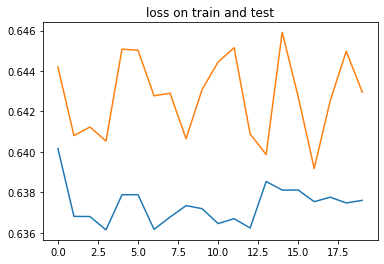

Last loss on train: 0.6376021114070859
Last loss on test: 0.6429546851860849


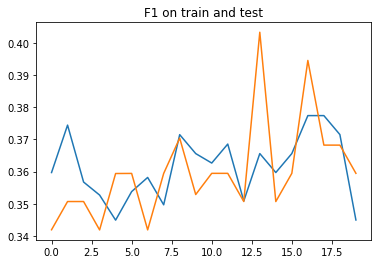

Last F1 on train: 0.34496825682905924
Last F1 on test: 0.3594747064144988


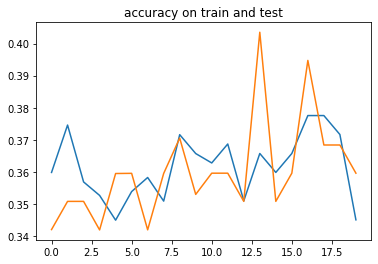

Last accuracy on train: 0.3451327531211144
Last accuracy on test: 0.3596491323489892


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))
plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experimet 2, testing layers

* RNN
* uni
* 1 cell
* 2 layers
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = RNN(vocab_size=len(word2id), num_layers=2, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


52it [00:01, 34.43it/s]

Train loss: 0.7224060005611843


96it [00:02, 35.51it/s]

Train loss: 0.7204744047588773


140it [00:04, 31.82it/s]

Train loss: 0.7150376359621684


183it [00:06, 19.78it/s]

Train loss: 0.7093291772736443


226it [00:07, 28.75it/s]


Train loss: 0.7067104959487915

Evaluating on train...


50it [00:01, 45.08it/s]

Val loss: 0.6919824414783053, Val f1: 0.377569266822603, Val accuracy: 0.37765917248196074


95it [00:02, 41.31it/s]

Val loss: 0.6981511036554973, Val f1: 0.36273946762084963, Val accuracy: 0.3628214617570241


139it [00:03, 38.61it/s]

Val loss: 0.6964104542025813, Val f1: 0.3578131128240515, Val accuracy: 0.3579029635146812


185it [00:04, 37.93it/s]

Val loss: 0.7005260699325138, Val f1: 0.35163854244682524, Val accuracy: 0.35173705601029925


226it [00:06, 36.09it/s]


Val loss: 0.7044188661045498, Val f1: 0.35088874287075467, Val accuracy: 0.3509872207376692

Evaluating on test...


19it [00:00, 21.93it/s]

Val loss: 0.7158147811889648, Val f1: 0.33310873111089073, Val accuracy: 0.33322931130727135


35it [00:01, 31.79it/s]

Val loss: 0.726339707771937, Val f1: 0.3331040501594543, Val accuracy: 0.33324700097242993


51it [00:01, 34.86it/s]

Val loss: 0.7246677663591173, Val f1: 0.33307316833072237, Val accuracy: 0.33318008714252045


67it [00:02, 34.94it/s]

Val loss: 0.7178792168696722, Val f1: 0.3330819209416707, Val accuracy: 0.3331802303592364


76it [00:02, 30.99it/s]


Val loss: 0.7140912858645121, Val f1: 0.34198522607485454, Val accuracy: 0.34209070324897767

starting Epoch 1
Training...


52it [00:01, 34.78it/s]

Train loss: 0.7143442511558533


96it [00:02, 34.49it/s]

Train loss: 0.707112885846032


140it [00:04, 35.26it/s]

Train loss: 0.7097887074505841


184it [00:05, 35.78it/s]

Train loss: 0.7061326927608914


226it [00:06, 34.51it/s]


Train loss: 0.7076288959715101

Evaluating on train...


50it [00:01, 44.61it/s]

Val loss: 0.7133454256587558, Val f1: 0.36274017956521776, Val accuracy: 0.3628546913464864


95it [00:02, 41.74it/s]

Val loss: 0.7046319756242964, Val f1: 0.3571853001912435, Val accuracy: 0.35728297895855377


139it [00:03, 39.21it/s]

Val loss: 0.7013463320555511, Val f1: 0.3602747310090948, Val accuracy: 0.3603664334173556


184it [00:04, 37.52it/s]

Val loss: 0.7027460826767815, Val f1: 0.35719502203994324, Val accuracy: 0.35729811439911524


226it [00:05, 40.34it/s]


Val loss: 0.7038142691718208, Val f1: 0.352380706999037, Val accuracy: 0.35248605145348444

Evaluating on test...


20it [00:00, 36.46it/s]

Val loss: 0.6932297984759013, Val f1: 0.3775684416294098, Val accuracy: 0.3776452561219533


36it [00:01, 35.57it/s]

Val loss: 0.6933719913164774, Val f1: 0.37758800586064656, Val accuracy: 0.37768922448158265


52it [00:01, 36.22it/s]

Val loss: 0.6979932904243469, Val f1: 0.3627493076854282, Val accuracy: 0.36283593045340645


64it [00:01, 37.90it/s]

Val loss: 0.7045904686053593, Val f1: 0.3664462387561798, Val accuracy: 0.3665442481637001


76it [00:02, 36.78it/s]


Val loss: 0.712908079624176, Val f1: 0.35976200660069785, Val accuracy: 0.35986364444096886

starting Epoch 2
Training...


50it [00:01, 34.04it/s]

Train loss: 0.6961305671268039


94it [00:02, 36.41it/s]

Train loss: 0.7091765655411615


142it [00:04, 36.29it/s]

Train loss: 0.7031388379909375


186it [00:05, 35.49it/s]

Train loss: 0.70471444328626


226it [00:06, 34.67it/s]


Train loss: 0.7054872012138367

Evaluating on train...


50it [00:01, 46.13it/s]

Val loss: 0.7056336482365926, Val f1: 0.3923607064618005, Val accuracy: 0.39245488511191473


95it [00:02, 41.27it/s]

Val loss: 0.6998440325260162, Val f1: 0.372011931737264, Val accuracy: 0.37211109201113385


142it [00:03, 38.59it/s]

Val loss: 0.7008354544639588, Val f1: 0.3668200406763289, Val accuracy: 0.36687879761060077


184it [00:04, 38.80it/s]

Val loss: 0.7051306804021199, Val f1: 0.36579662147495484, Val accuracy: 0.3658693646391233


226it [00:05, 40.57it/s]


Val loss: 0.7053583603435093, Val f1: 0.3651893814404806, Val accuracy: 0.3652720155980852

Evaluating on test...


20it [00:00, 36.96it/s]

Val loss: 0.7089794317881266, Val f1: 0.3775704006354014, Val accuracy: 0.377695643901825


36it [00:00, 37.62it/s]

Val loss: 0.712927915652593, Val f1: 0.3553196370601654, Val accuracy: 0.35542022784550986


52it [00:01, 37.24it/s]

Val loss: 0.7103879756397671, Val f1: 0.34792212910122344, Val accuracy: 0.3480253749423557


64it [00:01, 37.46it/s]

Val loss: 0.716370286544164, Val f1: 0.34421857247749965, Val accuracy: 0.3443370108803113


76it [00:02, 37.48it/s]


Val loss: 0.7143006849288941, Val f1: 0.3419877843062083, Val accuracy: 0.34209256450335185

starting Epoch 3
Training...


49it [00:01, 36.39it/s]

Train loss: 0.7098188347286648


97it [00:02, 34.84it/s]

Train loss: 0.7084295557604896


141it [00:04, 34.58it/s]

Train loss: 0.7075888554255167


185it [00:05, 35.09it/s]

Train loss: 0.7052740186452866


226it [00:06, 34.81it/s]


Train loss: 0.7054817385143703

Evaluating on train...


50it [00:01, 46.57it/s]

Val loss: 0.7053462187449138, Val f1: 0.3331101232104831, Val accuracy: 0.33320192164844936


95it [00:02, 41.80it/s]

Val loss: 0.7061930742528704, Val f1: 0.34976574546760986, Val accuracy: 0.3498569154077106


140it [00:03, 40.42it/s]

Val loss: 0.7042513171831767, Val f1: 0.35459448430273266, Val accuracy: 0.35469218691190085


185it [00:04, 40.53it/s]

Val loss: 0.706374168727133, Val f1: 0.36774015062385135, Val accuracy: 0.3678436029288504


226it [00:05, 41.95it/s]


Val loss: 0.7053963141971165, Val f1: 0.36525778200891285, Val accuracy: 0.36535878353648715

Evaluating on test...


21it [00:00, 38.70it/s]

Val loss: 0.7126410722732544, Val f1: 0.33313960830370587, Val accuracy: 0.33327519297599795


37it [00:00, 37.72it/s]

Val loss: 0.7135477483272552, Val f1: 0.33864691158135735, Val accuracy: 0.33874054849147794


49it [00:01, 37.30it/s]

Val loss: 0.7032134148809644, Val f1: 0.3405257648891873, Val accuracy: 0.3406212773587969


65it [00:01, 37.95it/s]

Val loss: 0.704553339878718, Val f1: 0.3497841770450274, Val accuracy: 0.34988286048173906


76it [00:02, 38.00it/s]


Val loss: 0.710838057200114, Val f1: 0.34867154479026796, Val accuracy: 0.34878432830174766

starting Epoch 4
Training...


50it [00:01, 36.19it/s]

Train loss: 0.7158698081970215


94it [00:02, 35.75it/s]

Train loss: 0.7097031043635474


142it [00:04, 36.28it/s]

Train loss: 0.7123713824484084


186it [00:05, 35.56it/s]

Train loss: 0.7084741873873605


226it [00:06, 35.05it/s]


Train loss: 0.7073429361979167

Evaluating on train...


50it [00:01, 46.75it/s]

Val loss: 0.7081841707229615, Val f1: 0.3775757425361209, Val accuracy: 0.3777140743202633


96it [00:02, 31.10it/s]

Val loss: 0.6950352006488376, Val f1: 0.38127170900503793, Val accuracy: 0.38136516544553967


141it [00:03, 38.26it/s]

Val loss: 0.7041227574701663, Val f1: 0.3726122092317652, Val accuracy: 0.37271052797635396


184it [00:04, 38.73it/s]

Val loss: 0.7004159728686015, Val f1: 0.3673778168029255, Val accuracy: 0.36747924205329685


226it [00:05, 38.91it/s]


Val loss: 0.7041727413071527, Val f1: 0.3664441605408986, Val accuracy: 0.3665451102786594

Evaluating on test...


20it [00:00, 37.26it/s]

Val loss: 0.7319630861282349, Val f1: 0.3331112563610077, Val accuracy: 0.3332922081152598


36it [00:00, 36.32it/s]

Val loss: 0.7053403079509735, Val f1: 0.3775769909222921, Val accuracy: 0.3777061223983765


52it [00:01, 37.16it/s]

Val loss: 0.7092664784855313, Val f1: 0.36276241607136195, Val accuracy: 0.36289609604411655


64it [00:01, 35.36it/s]

Val loss: 0.7072611560424169, Val f1: 0.35536493013302484, Val accuracy: 0.35550299336512886


76it [00:02, 36.88it/s]


Val loss: 0.7137503345807393, Val f1: 0.35091402133305866, Val accuracy: 0.35106091539065043

starting Epoch 5
Training...


52it [00:01, 35.22it/s]

Train loss: 0.6954473906093174


96it [00:02, 35.10it/s]

Train loss: 0.7056661480002933


140it [00:04, 35.29it/s]

Train loss: 0.7102254434868142


184it [00:05, 34.21it/s]

Train loss: 0.7079509129126866


226it [00:06, 34.41it/s]


Train loss: 0.705770050684611

Evaluating on train...


50it [00:01, 45.10it/s]

Val loss: 0.6978806548648411, Val f1: 0.34796753923098245, Val accuracy: 0.3480869988600413


95it [00:02, 42.02it/s]

Val loss: 0.7065137896272872, Val f1: 0.35658633410930635, Val accuracy: 0.3573214521010717


141it [00:03, 30.57it/s]

Val loss: 0.7021201857814082, Val f1: 0.3537033443097715, Val accuracy: 0.3542192459106445


186it [00:04, 37.27it/s]

Val loss: 0.7033646057049433, Val f1: 0.35597203887171214, Val accuracy: 0.3563931946953138


226it [00:05, 38.18it/s]


Val loss: 0.707379895846049, Val f1: 0.3543543455335829, Val accuracy: 0.35471144133143956

Evaluating on test...


20it [00:00, 36.25it/s]

Val loss: 0.6717427968978882, Val f1: 0.3887154936790466, Val accuracy: 0.388801771402359


36it [00:00, 37.30it/s]

Val loss: 0.7119156301021576, Val f1: 0.3608728011449178, Val accuracy: 0.3609882821639379


52it [00:01, 36.48it/s]

Val loss: 0.7130931350919936, Val f1: 0.38124027649561565, Val accuracy: 0.3813533816072676


64it [00:01, 36.49it/s]

Val loss: 0.7168031871318817, Val f1: 0.369199238717556, Val accuracy: 0.36931409140427907


76it [00:02, 36.76it/s]


Val loss: 0.7133923117319743, Val f1: 0.36199219544728595, Val accuracy: 0.362110329469045

starting Epoch 6
Training...


49it [00:01, 34.33it/s]

Train loss: 0.7094989776611328


97it [00:02, 35.82it/s]

Train loss: 0.712668596373664


141it [00:04, 34.46it/s]

Train loss: 0.7084951996803284


185it [00:05, 35.00it/s]

Train loss: 0.7063713000880347


226it [00:06, 34.76it/s]


Train loss: 0.7050463083055284

Evaluating on train...


50it [00:01, 45.17it/s]

Val loss: 0.6877357456419203, Val f1: 0.34794812467363145, Val accuracy: 0.3480272624227736


95it [00:02, 42.18it/s]

Val loss: 0.6950939562585619, Val f1: 0.34053299493259853, Val accuracy: 0.3406217998928494


140it [00:03, 40.09it/s]

Val loss: 0.7032864221820125, Val f1: 0.342989973227183, Val accuracy: 0.3430859002802107


185it [00:04, 39.03it/s]

Val loss: 0.7033253719409307, Val f1: 0.34845823215113747, Val accuracy: 0.34864229112863543


226it [00:05, 41.37it/s]


Val loss: 0.7081398338741727, Val f1: 0.34538030876053705, Val accuracy: 0.3455504951212141

Evaluating on test...


20it [00:00, 19.03it/s]

Val loss: 0.7027503808339437, Val f1: 0.3776038686434428, Val accuracy: 0.37774933179219566


36it [00:01, 30.64it/s]

Val loss: 0.6934463858604432, Val f1: 0.3776073962450027, Val accuracy: 0.37773047884305316


52it [00:01, 33.88it/s]

Val loss: 0.7044267720646329, Val f1: 0.36647631724675495, Val accuracy: 0.36660801370938617


64it [00:02, 35.28it/s]

Val loss: 0.7101195265849432, Val f1: 0.35812358955542245, Val accuracy: 0.35824764768282574


76it [00:02, 30.48it/s]


Val loss: 0.7134870545069376, Val f1: 0.35312399625778196, Val accuracy: 0.35325753847757974

starting Epoch 7
Training...


52it [00:01, 36.28it/s]

Train loss: 0.7053533951441447


96it [00:02, 36.15it/s]

Train loss: 0.7063056965668996


140it [00:04, 35.52it/s]

Train loss: 0.702275710635715


184it [00:05, 36.06it/s]

Train loss: 0.7028733021683163


226it [00:06, 34.85it/s]


Train loss: 0.7065628721978929

Evaluating on train...


50it [00:01, 45.04it/s]

Val loss: 0.7102231290605333, Val f1: 0.3479610588815477, Val accuracy: 0.34810582002003987


95it [00:02, 43.41it/s]

Val loss: 0.7099132809374068, Val f1: 0.3553665777047475, Val accuracy: 0.35551140109697976


140it [00:03, 40.59it/s]

Val loss: 0.7084955599572923, Val f1: 0.3504206090061753, Val accuracy: 0.35055473623452366


185it [00:04, 40.50it/s]

Val loss: 0.707280257013109, Val f1: 0.35072916828923756, Val accuracy: 0.3508605716956986


226it [00:05, 41.60it/s]


Val loss: 0.7050567120975918, Val f1: 0.34770266665352717, Val accuracy: 0.34807214710447526

Evaluating on test...


21it [00:00, 38.63it/s]

Val loss: 0.7500414570172628, Val f1: 0.33308454751968386, Val accuracy: 0.3332707405090332


38it [00:00, 38.95it/s]

Val loss: 0.7353371322154999, Val f1: 0.3330991824467977, Val accuracy: 0.3332609713077545


50it [00:01, 38.33it/s]

Val loss: 0.7209366427527534, Val f1: 0.34793110291163126, Val accuracy: 0.34807379643122355


66it [00:01, 37.79it/s]

Val loss: 0.7131113320589065, Val f1: 0.344241364300251, Val accuracy: 0.34437949856122335


76it [00:01, 38.21it/s]


Val loss: 0.7143624369303385, Val f1: 0.35091341932614645, Val accuracy: 0.35105915625890094

starting Epoch 8
Training...


49it [00:01, 36.88it/s]

Train loss: 0.7104649980862935


97it [00:02, 35.71it/s]

Train loss: 0.7091925726996527


141it [00:04, 34.82it/s]

Train loss: 0.7072960495948791


185it [00:05, 35.50it/s]

Train loss: 0.7054134216573503


226it [00:06, 34.77it/s]


Train loss: 0.7057940827475654

Evaluating on train...


50it [00:01, 46.01it/s]

Val loss: 0.7216454082065158, Val f1: 0.3479665822452969, Val accuracy: 0.34814815786149766


95it [00:02, 43.21it/s]

Val loss: 0.7072777496443854, Val f1: 0.37761271198590596, Val accuracy: 0.3777777870496114


140it [00:03, 39.90it/s]

Val loss: 0.7022059630464624, Val f1: 0.3726809572290491, Val accuracy: 0.3728395155182591


185it [00:04, 39.68it/s]

Val loss: 0.7050727920399772, Val f1: 0.3665054817994436, Val accuracy: 0.3666666761040688


226it [00:05, 41.98it/s]


Val loss: 0.7048613198598226, Val f1: 0.3716909909248352, Val accuracy: 0.37185186121198865

Evaluating on test...


21it [00:00, 39.07it/s]

Val loss: 0.7221447149912517, Val f1: 0.422037676970164, Val accuracy: 0.422222230831782


37it [00:00, 38.02it/s]

Val loss: 0.7145399192969004, Val f1: 0.4220448434352875, Val accuracy: 0.422222230831782


49it [00:01, 38.29it/s]

Val loss: 0.7201317522260878, Val f1: 0.39241023858388263, Val accuracy: 0.39259260164366827


65it [00:01, 37.05it/s]

Val loss: 0.7232228269179662, Val f1: 0.37759170432885486, Val accuracy: 0.3777777870496114


76it [00:02, 37.96it/s]


Val loss: 0.7170691013336181, Val f1: 0.36871156374613445, Val accuracy: 0.3688888982931773

starting Epoch 9
Training...


49it [00:01, 34.50it/s]

Train loss: 0.7086786442332798


97it [00:02, 36.20it/s]

Train loss: 0.7114242460992601


141it [00:04, 35.19it/s]

Train loss: 0.7072975202842995


185it [00:05, 36.42it/s]

Train loss: 0.7046924571196238


226it [00:06, 34.95it/s]


Train loss: 0.7059522435400221

Evaluating on train...


50it [00:01, 46.31it/s]

Val loss: 0.7154814508226183, Val f1: 0.377603813012441, Val accuracy: 0.3777777870496114


95it [00:02, 43.74it/s]

Val loss: 0.7068561202949948, Val f1: 0.39983258545398714, Val accuracy: 0.4000000089406967


140it [00:03, 40.44it/s]

Val loss: 0.7072035882208082, Val f1: 0.3825505287558944, Val accuracy: 0.3827160585809637


185it [00:04, 40.30it/s]

Val loss: 0.7086183740033044, Val f1: 0.3739073755012618, Val accuracy: 0.3740740834010972


226it [00:05, 41.90it/s]


Val loss: 0.70640243212382, Val f1: 0.37465166131655375, Val accuracy: 0.37481482413080003

Evaluating on test...


20it [00:00, 36.37it/s]

Val loss: 0.6992493549982707, Val f1: 0.3331829229990641, Val accuracy: 0.3333333432674408


36it [00:01, 35.24it/s]

Val loss: 0.6956235289573669, Val f1: 0.33318744401137035, Val accuracy: 0.3333333432674408


48it [00:01, 34.23it/s]

Val loss: 0.706381889184316, Val f1: 0.34798748559421966, Val accuracy: 0.34814815786149766


64it [00:01, 34.50it/s]

Val loss: 0.710024181008339, Val f1: 0.3442798525094986, Val accuracy: 0.3444444542129835


76it [00:02, 34.98it/s]


Val loss: 0.7149162936210632, Val f1: 0.35093922972679137, Val accuracy: 0.35111112078030904

starting Epoch 10
Training...


49it [00:01, 35.91it/s]

Train loss: 0.7168345239427355


97it [00:02, 35.77it/s]

Train loss: 0.7071916467613644


141it [00:04, 36.24it/s]

Train loss: 0.7059709407665111


185it [00:05, 34.98it/s]

Train loss: 0.7044307228591707


226it [00:06, 34.66it/s]


Train loss: 0.706530843840705

Evaluating on train...


50it [00:01, 46.54it/s]

Val loss: 0.7175099902682834, Val f1: 0.347970449924469, Val accuracy: 0.34814815786149766


95it [00:02, 42.14it/s]

Val loss: 0.702774112092124, Val f1: 0.34799009263515474, Val accuracy: 0.34814815786149766


140it [00:03, 42.14it/s]

Val loss: 0.7058790343779104, Val f1: 0.34304890367719865, Val accuracy: 0.3432098863301454


185it [00:04, 39.31it/s]

Val loss: 0.7082796288861168, Val f1: 0.3516862702038553, Val accuracy: 0.3518518615100119


226it [00:05, 41.81it/s]


Val loss: 0.7054584044880338, Val f1: 0.3539123578866323, Val accuracy: 0.3540740836991204

Evaluating on test...


20it [00:00, 36.75it/s]

Val loss: 0.7432347655296325, Val f1: 0.33312605023384095, Val accuracy: 0.3333333432674408


34it [00:00, 38.64it/s]

Val loss: 0.7139760553836823, Val f1: 0.33316289484500883, Val accuracy: 0.3333333432674408


50it [00:01, 38.71it/s]

Val loss: 0.7164977312088012, Val f1: 0.3479711956448025, Val accuracy: 0.34814815786149766


66it [00:01, 37.68it/s]

Val loss: 0.7091780136028926, Val f1: 0.36649860441684723, Val accuracy: 0.3666666761040688


76it [00:01, 38.13it/s]


Val loss: 0.7075810432434082, Val f1: 0.36872325658798216, Val accuracy: 0.3688888982931773

starting Epoch 11
Training...


49it [00:01, 35.74it/s]

Train loss: 0.7083528028594123


97it [00:02, 34.19it/s]

Train loss: 0.705328557226393


141it [00:04, 35.47it/s]

Train loss: 0.7022191453863074


185it [00:05, 36.16it/s]

Train loss: 0.7028535650836096


226it [00:06, 34.74it/s]


Train loss: 0.7077899294429355

Evaluating on train...


54it [00:01, 45.54it/s]

Val loss: 0.6780609011650085, Val f1: 0.39239595135053, Val accuracy: 0.3925300253762139


94it [00:02, 43.32it/s]

Val loss: 0.6891152891847823, Val f1: 0.38979432384173074, Val accuracy: 0.3899708310763041


139it [00:03, 40.98it/s]

Val loss: 0.6931731577272768, Val f1: 0.39216956739072445, Val accuracy: 0.3897581663396623


187it [00:04, 39.54it/s]

Val loss: 0.6988399383094576, Val f1: 0.389592967596319, Val accuracy: 0.3874778469403585


226it [00:05, 42.16it/s]


Val loss: 0.6987868746121725, Val f1: 0.38584932035870023, Val accuracy: 0.3833694945441352

Evaluating on test...


20it [00:00, 37.50it/s]

Val loss: 0.7056016167004903, Val f1: 0.3806608239809672, Val accuracy: 0.3699499011039734


36it [00:00, 36.95it/s]

Val loss: 0.6975318133831024, Val f1: 0.38519823253154756, Val accuracy: 0.3793999214967092


52it [00:01, 37.25it/s]

Val loss: 0.6996549116240607, Val f1: 0.38266191946135625, Val accuracy: 0.3769929958714379


64it [00:01, 36.78it/s]

Val loss: 0.7034590135018031, Val f1: 0.3740933910012245, Val accuracy: 0.3690328071514765


76it [00:02, 37.14it/s]


Val loss: 0.7118819761276245, Val f1: 0.36954602003097536, Val accuracy: 0.3647382156054179

starting Epoch 12
Training...


50it [00:01, 35.16it/s]

Train loss: 0.6939825799730089


94it [00:02, 35.62it/s]

Train loss: 0.6645298851860895


142it [00:04, 36.24it/s]

Train loss: 0.6489987232066967


186it [00:05, 34.86it/s]

Train loss: 0.6394775526391135


226it [00:06, 34.71it/s]


Train loss: 0.6327979373931885

Evaluating on train...


50it [00:01, 45.68it/s]

Val loss: 0.5998539606730143, Val f1: 0.37704536120096843, Val accuracy: 0.8326774511072371


95it [00:02, 43.06it/s]

Val loss: 0.5977930499447717, Val f1: 0.3788736045360565, Val accuracy: 0.8483296818203396


140it [00:03, 41.43it/s]

Val loss: 0.5977018983275802, Val f1: 0.37959314584732057, Val accuracy: 0.8645916603229664


185it [00:04, 38.06it/s]

Val loss: 0.5966173049476412, Val f1: 0.3793301163448228, Val accuracy: 0.8732825530899896


226it [00:05, 41.46it/s]


Val loss: 0.596309179994795, Val f1: 0.37763866596751744, Val accuracy: 0.8705155204402076

Evaluating on test...


20it [00:00, 38.39it/s]

Val loss: 0.6051994959513346, Val f1: 0.3667381525039673, Val accuracy: 0.8131842573483785


36it [00:00, 38.08it/s]

Val loss: 0.6106147309144337, Val f1: 0.36515026092529296, Val accuracy: 0.7853582521279653


52it [00:01, 36.74it/s]

Val loss: 0.6117562731107076, Val f1: 0.36962078544828625, Val accuracy: 0.8103703737258912


64it [00:01, 37.36it/s]

Val loss: 0.6158088018496831, Val f1: 0.3723723123470942, Val accuracy: 0.8016710082689921


76it [00:02, 37.46it/s]


Val loss: 0.6134616208076477, Val f1: 0.3718200703461965, Val accuracy: 0.8036841603120168

starting Epoch 13
Training...


50it [00:01, 35.15it/s]

Train loss: 0.5990397281116909


94it [00:02, 35.39it/s]

Train loss: 0.5996330128775702


140it [00:04, 33.91it/s]

Train loss: 0.5995808645530983


184it [00:05, 35.15it/s]

Train loss: 0.5974547435839971


226it [00:06, 32.51it/s]


Train loss: 0.5993000610669454

Evaluating on train...


50it [00:01, 43.03it/s]

Val loss: 0.5844943655861748, Val f1: 0.4194495499134064, Val accuracy: 0.8635720332463582


95it [00:02, 40.97it/s]

Val loss: 0.5908454590373569, Val f1: 0.41145290268792045, Val accuracy: 0.8633450117376116


140it [00:03, 39.15it/s]

Val loss: 0.5933738973405626, Val f1: 0.4087610597963686, Val accuracy: 0.8608339806397756


186it [00:04, 38.79it/s]

Val loss: 0.5932471109761133, Val f1: 0.40962616006533303, Val accuracy: 0.8588627308607102


226it [00:05, 38.48it/s]


Val loss: 0.5935329164399041, Val f1: 0.41202987750371295, Val accuracy: 0.8651492145326403

Evaluating on test...


20it [00:00, 37.64it/s]

Val loss: 0.6007475813229879, Val f1: 0.3991255203882853, Val accuracy: 0.8416610320409139


36it [00:00, 37.65it/s]

Val loss: 0.6095869143803915, Val f1: 0.40111488103866577, Val accuracy: 0.8296735107898712


52it [00:01, 37.59it/s]

Val loss: 0.607202042473687, Val f1: 0.40105413066016304, Val accuracy: 0.8199784987502627


64it [00:01, 36.81it/s]

Val loss: 0.6064451853434245, Val f1: 0.3983687793215116, Val accuracy: 0.8235457266370455


76it [00:02, 37.31it/s]


Val loss: 0.6077100539207458, Val f1: 0.4020123175779978, Val accuracy: 0.8285931408405304

starting Epoch 14
Training...


49it [00:01, 34.61it/s]

Train loss: 0.5949873116281298


97it [00:02, 34.94it/s]

Train loss: 0.596213208966785


141it [00:04, 35.98it/s]

Train loss: 0.5969614541089093


185it [00:05, 35.30it/s]

Train loss: 0.5980791628360749


226it [00:06, 34.39it/s]


Train loss: 0.5964914870262146

Evaluating on train...


49it [00:01, 43.88it/s]

Val loss: 0.58779915438758, Val f1: 0.43183526396751404, Val accuracy: 0.8923164036538865


94it [00:02, 41.50it/s]

Val loss: 0.5905642641915215, Val f1: 0.42525236275460987, Val accuracy: 0.880861626399888


142it [00:03, 39.37it/s]

Val loss: 0.5891349271491721, Val f1: 0.4227263214411559, Val accuracy: 0.8844827239160185


184it [00:04, 39.09it/s]

Val loss: 0.5901551955276065, Val f1: 0.42409552567534975, Val accuracy: 0.8837182321482234


226it [00:05, 40.79it/s]


Val loss: 0.5891029495663113, Val f1: 0.42273706158002217, Val accuracy: 0.880652142630683

Evaluating on test...


20it [00:00, 36.83it/s]

Val loss: 0.5934163967768351, Val f1: 0.39924289981524147, Val accuracy: 0.8395930190881093


37it [00:00, 38.05it/s]

Val loss: 0.5998315592606862, Val f1: 0.4073963890473048, Val accuracy: 0.8426155328750611


49it [00:01, 37.36it/s]

Val loss: 0.6016321606106229, Val f1: 0.4124922805362278, Val accuracy: 0.854753839969635


65it [00:01, 36.90it/s]

Val loss: 0.6058129479487737, Val f1: 0.4134038825829824, Val accuracy: 0.8497685760259628


76it [00:02, 36.95it/s]


Val loss: 0.6076991693178813, Val f1: 0.40724861264228823, Val accuracy: 0.8265651408831278

starting Epoch 15
Training...


52it [00:01, 35.81it/s]

Train loss: 0.5919332067171733


96it [00:02, 35.45it/s]

Train loss: 0.5932002974881067


140it [00:04, 34.70it/s]

Train loss: 0.5935229045373422


184it [00:05, 34.36it/s]

Train loss: 0.5931656698385874


226it [00:06, 34.46it/s]


Train loss: 0.5961129140853881

Evaluating on train...


50it [00:01, 44.34it/s]

Val loss: 0.5835673915015327, Val f1: 0.3800856444570753, Val accuracy: 0.9093392749627431


95it [00:02, 42.98it/s]

Val loss: 0.58524126874076, Val f1: 0.3787254893117481, Val accuracy: 0.8897579809029897


140it [00:03, 40.57it/s]

Val loss: 0.5896415772261443, Val f1: 0.3797152353657616, Val accuracy: 0.8752745341371607


188it [00:04, 39.36it/s]

Val loss: 0.5875796347856521, Val f1: 0.3798685923218727, Val accuracy: 0.8911130713091956


226it [00:05, 41.31it/s]


Val loss: 0.5897678952746921, Val f1: 0.3794732553429074, Val accuracy: 0.8856591837935978

Evaluating on test...


20it [00:00, 38.35it/s]

Val loss: 0.6046582102775574, Val f1: 0.3735982914765676, Val accuracy: 0.8698333323001861


36it [00:00, 36.99it/s]

Val loss: 0.6061675349871317, Val f1: 0.372536900639534, Val accuracy: 0.8594306548436482


52it [00:01, 36.55it/s]

Val loss: 0.6078694846895006, Val f1: 0.3724968565834893, Val accuracy: 0.853736678759257


64it [00:01, 36.38it/s]

Val loss: 0.6066268215576808, Val f1: 0.37189776053031287, Val accuracy: 0.8341157272458076


76it [00:02, 37.35it/s]


Val loss: 0.605850658416748, Val f1: 0.37189839919408163, Val accuracy: 0.8465998987356822

starting Epoch 16
Training...


49it [00:01, 35.43it/s]

Train loss: 0.5838934739430746


93it [00:02, 34.03it/s]

Train loss: 0.5886548340320588


141it [00:04, 36.06it/s]

Train loss: 0.5904304972401372


185it [00:05, 35.19it/s]

Train loss: 0.5941473268800311


226it [00:06, 34.51it/s]


Train loss: 0.5930173871252272

Evaluating on train...


50it [00:01, 44.99it/s]

Val loss: 0.5869467616081238, Val f1: 0.40375219186147054, Val accuracy: 0.8982571356826359


95it [00:02, 41.62it/s]

Val loss: 0.5868934293588003, Val f1: 0.40786479810873666, Val accuracy: 0.9003678927818934


140it [00:03, 40.67it/s]

Val loss: 0.5870017515288459, Val f1: 0.40522038208113775, Val accuracy: 0.8832407732804616


186it [00:04, 38.17it/s]

Val loss: 0.5864698158370124, Val f1: 0.40696881728039846, Val accuracy: 0.8909523664249315


226it [00:05, 40.84it/s]


Val loss: 0.5858599946233961, Val f1: 0.410017183886634, Val accuracy: 0.8962814048926036

Evaluating on test...


20it [00:00, 37.58it/s]

Val loss: 0.5983112255732218, Val f1: 0.3943536420663198, Val accuracy: 0.8235120713710785


36it [00:00, 36.84it/s]

Val loss: 0.606219494342804, Val f1: 0.3976655373970667, Val accuracy: 0.818361739317576


52it [00:01, 36.14it/s]

Val loss: 0.6040726661682129, Val f1: 0.39395815398957995, Val accuracy: 0.811963497267829


64it [00:01, 36.49it/s]

Val loss: 0.6007433960835139, Val f1: 0.3950069526831309, Val accuracy: 0.8234854429960251


76it [00:02, 36.73it/s]


Val loss: 0.6001885000864665, Val f1: 0.39545325994491576, Val accuracy: 0.8222934079170227

starting Epoch 17
Training...


50it [00:01, 35.75it/s]

Train loss: 0.5916531933678522


94it [00:02, 36.69it/s]

Train loss: 0.5916713575522105


142it [00:04, 34.49it/s]

Train loss: 0.5885330222271107


186it [00:05, 36.40it/s]

Train loss: 0.586548638674948


226it [00:06, 34.46it/s]


Train loss: 0.5878020156754388

Evaluating on train...


50it [00:01, 44.89it/s]

Val loss: 0.594104876783159, Val f1: 0.4442215515507592, Val accuracy: 0.8849788314766354


95it [00:02, 42.56it/s]

Val loss: 0.595201904906167, Val f1: 0.44670853084988066, Val accuracy: 0.8648897425995933


141it [00:03, 37.82it/s]

Val loss: 0.5911346386980127, Val f1: 0.4411374312859994, Val accuracy: 0.8638634335111689


185it [00:04, 39.32it/s]

Val loss: 0.5904882235659493, Val f1: 0.44159720291694005, Val accuracy: 0.8628567733698421


226it [00:05, 40.44it/s]


Val loss: 0.5903148052427504, Val f1: 0.4401367403401269, Val accuracy: 0.8574436795711518

Evaluating on test...


20it [00:00, 37.44it/s]

Val loss: 0.593681279818217, Val f1: 0.41710482438405355, Val accuracy: 0.7907482286294302


36it [00:00, 37.33it/s]

Val loss: 0.6047215720017751, Val f1: 0.420185786485672, Val accuracy: 0.7962427536646525


52it [00:01, 35.86it/s]

Val loss: 0.6002770715289646, Val f1: 0.41879125701056585, Val accuracy: 0.8056743893358442


64it [00:01, 36.46it/s]

Val loss: 0.5998539288838705, Val f1: 0.4198909103870392, Val accuracy: 0.8215746516982715


76it [00:02, 36.75it/s]


Val loss: 0.6014285326004029, Val f1: 0.4186740787823995, Val accuracy: 0.8183090138435364

starting Epoch 18
Training...


51it [00:01, 34.49it/s]

Train loss: 0.5868556075625949


95it [00:02, 36.02it/s]

Train loss: 0.5904567446973589


139it [00:04, 35.85it/s]

Train loss: 0.5897156949396487


183it [00:05, 33.58it/s]

Train loss: 0.5895149303807152


226it [00:06, 34.29it/s]


Train loss: 0.5893871847788493

Evaluating on train...


50it [00:01, 45.14it/s]

Val loss: 0.5853379898601108, Val f1: 0.4266839755905999, Val accuracy: 0.9215552442603641


95it [00:02, 42.10it/s]

Val loss: 0.5871637576156192, Val f1: 0.42839870982699924, Val accuracy: 0.9081193506717682


140it [00:03, 40.48it/s]

Val loss: 0.586688984323431, Val f1: 0.42731333419128703, Val accuracy: 0.9105896327230666


184it [00:04, 39.66it/s]

Val loss: 0.5852037300666173, Val f1: 0.42487705300251644, Val accuracy: 0.913058054447174


226it [00:05, 41.23it/s]


Val loss: 0.5856071498658922, Val f1: 0.4256965152422587, Val accuracy: 0.9165351976288689

Evaluating on test...


20it [00:00, 36.89it/s]

Val loss: 0.6092663327852885, Val f1: 0.3961687405904134, Val accuracy: 0.838565452893575


36it [00:00, 37.58it/s]

Val loss: 0.6048805018266042, Val f1: 0.3946467330058416, Val accuracy: 0.8621425032615662


52it [00:01, 35.92it/s]

Val loss: 0.6049615330166287, Val f1: 0.4056287705898285, Val accuracy: 0.8728069596820407


64it [00:01, 35.85it/s]

Val loss: 0.6017525643110275, Val f1: 0.4041617487867673, Val accuracy: 0.8669843430320422


76it [00:02, 36.46it/s]


Val loss: 0.5997775348027548, Val f1: 0.40343591928482053, Val accuracy: 0.8778565466403961

starting Epoch 19
Training...


50it [00:01, 33.81it/s]

Train loss: 0.580414683288998


94it [00:02, 35.29it/s]

Train loss: 0.5861454566319784


142it [00:04, 34.88it/s]

Train loss: 0.5859469965652183


186it [00:05, 35.52it/s]

Train loss: 0.5857231832212872


226it [00:06, 34.26it/s]


Train loss: 0.5873202557033963

Evaluating on train...


50it [00:01, 45.06it/s]

Val loss: 0.5843005074395073, Val f1: 0.4173443615436554, Val accuracy: 0.87889271179835


95it [00:02, 40.60it/s]

Val loss: 0.5842130064964295, Val f1: 0.42499406105942195, Val accuracy: 0.8998165799511804


140it [00:03, 41.07it/s]

Val loss: 0.5848369620464466, Val f1: 0.4245059761736128, Val accuracy: 0.8937107507829313


185it [00:04, 38.27it/s]

Val loss: 0.5826454583141539, Val f1: 0.42310766958528095, Val accuracy: 0.894939917491542


226it [00:05, 40.85it/s]


Val loss: 0.5853914382722643, Val f1: 0.4241138732433319, Val accuracy: 0.8874260151386261

Evaluating on test...


20it [00:00, 37.05it/s]

Val loss: 0.6094419240951539, Val f1: 0.39671069383621216, Val accuracy: 0.8383243242899577


36it [00:00, 37.18it/s]

Val loss: 0.6165706475575765, Val f1: 0.39852512975533805, Val accuracy: 0.8247105578581492


52it [00:01, 36.13it/s]

Val loss: 0.6053426424662273, Val f1: 0.4014255093203651, Val accuracy: 0.8504333880212572


64it [00:01, 36.85it/s]

Val loss: 0.6048194219668707, Val f1: 0.405358732243379, Val accuracy: 0.8497966249783834


76it [00:02, 36.33it/s]

Val loss: 0.6002008692423503, Val f1: 0.4056759730974833, Val accuracy: 0.8509137880802154


## Graphics

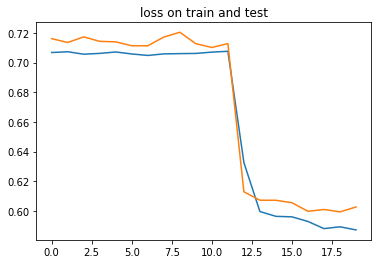

Last loss on train: 0.5872314366619144
Last loss on test: 0.6026909578787653


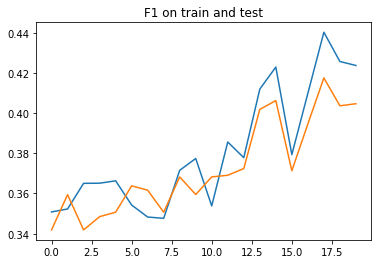

Last F1 on train: 0.42370262794790015
Last F1 on test: 0.40466179581064926


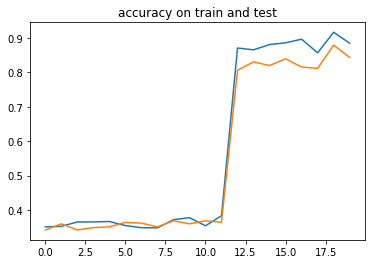

Last accuracy on train: 0.8849552778807361
Last accuracy on test: 0.8439866418116971


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.6020344612829562


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

keine-B ahnung-I .-O
--O ganz-B genau-I .-O
--O hör-B auf-I !-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
keine-B ahnung-I .-O
--O ist-B schon-I gut-I .-O
ist-B schon-I gut-I .-O
na-B gut-I ,-O mein-O schatz-O .-O
warum-B nicht-I ?-O
also-B gut-I .-O
--O das-B stimmt-I nicht-I .-O
was-B soll-I das-I ?-O
im-B ernst-I !-O
überhaupt-B nicht-I .-O
ist-B schon-I ok-I .-O
schon-B gut-I .-O
--O keine-B ahnung-I .-O
wir-O kommen-O alle-O ,-O stimmt-B 's-I ?-O
--O ist-B ja-I schon-I gut-I .-O
hör-B auf-I ,-O valiente-O !-O
--O keine-B ahnung-I .-O
--O stimmt-B 's-I ?-O
oh-O nein-O ,-O ist-B schon-I gut-I .-O
auf-B keinen-I fall-I .-O
lhr-O kennt-O doch-O meinen-O vater-O ,-O stimmt-B 's-I ?-O
keine-B ahnung-I .-O
weiß-B ich-I nicht-I .-O
--O in-B ordnung-I .-O
hör-B auf-I !-O
--O machst-B du-I witze-I ?-O
ich-B weiß-I .-O
nein-O ,-O schon-B gut-I .-O
--O na-B klar-I .-O
keine-B ahnung-I .-O
madame-O kali-O ,-O nicht-B wahr-I ?-O


# Experiment 3, testing cells

* RNN
* uni
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = RNN_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:01, 39.42it/s]

Train loss: 0.7232459743817647


94it [00:02, 40.69it/s]

Train loss: 0.7145636982387966


139it [00:03, 41.91it/s]

Train loss: 0.7099528948465983


182it [00:04, 32.53it/s]

Train loss: 0.7104234013292524


226it [00:06, 35.65it/s]


Train loss: 0.7093507032924228

Evaluating on train...


50it [00:02, 25.75it/s]

Val loss: 0.6987820386886596, Val f1: 0.3665039559205373, Val accuracy: 0.36665079924795363


94it [00:03, 39.51it/s]

Val loss: 0.7152921126948463, Val f1: 0.357226852244801, Val accuracy: 0.35739380882845984


139it [00:04, 42.36it/s]

Val loss: 0.7080319532641658, Val f1: 0.3541495795603152, Val accuracy: 0.3543050909483874


184it [00:05, 41.96it/s]

Val loss: 0.7074867632653978, Val f1: 0.35630903128120633, Val accuracy: 0.356464026371638


226it [00:06, 36.47it/s]


Val loss: 0.7071112457911174, Val f1: 0.351682348118888, Val accuracy: 0.35183788975079855

Evaluating on test...


20it [00:00, 42.21it/s]

Val loss: 0.7120667735735575, Val f1: 0.3776082416375478, Val accuracy: 0.3777777870496114


35it [00:00, 42.76it/s]

Val loss: 0.7157180349032084, Val f1: 0.35537924369176227, Val accuracy: 0.3555555651585261


50it [00:01, 42.24it/s]

Val loss: 0.7181592994266086, Val f1: 0.3479622251457638, Val accuracy: 0.348129047287835


65it [00:01, 41.90it/s]

Val loss: 0.7214515070120494, Val f1: 0.34425284912188847, Val accuracy: 0.3444271256526311


76it [00:01, 42.12it/s]


Val loss: 0.7141209077835083, Val f1: 0.35092913190523783, Val accuracy: 0.35109366655349733

starting Epoch 1
Training...


49it [00:01, 23.22it/s]

Train loss: 0.7103818655014038


94it [00:03, 26.41it/s]

Train loss: 0.7010900497436523


139it [00:05, 23.37it/s]

Train loss: 0.7002991574781913


186it [00:07, 28.77it/s]

Train loss: 0.7046362181504567


226it [00:08, 26.60it/s]


Train loss: 0.7041701486375597

Evaluating on train...


50it [00:01, 47.77it/s]

Val loss: 0.6960235635439554, Val f1: 0.3479998350143433, Val accuracy: 0.34814815786149766


95it [00:02, 46.22it/s]

Val loss: 0.7098620686266157, Val f1: 0.3553884400261773, Val accuracy: 0.3555555651585261


140it [00:03, 44.54it/s]

Val loss: 0.7104865241933752, Val f1: 0.36279450831589877, Val accuracy: 0.36296297245555453


185it [00:04, 42.68it/s]

Val loss: 0.7051294270488951, Val f1: 0.3665039219790035, Val accuracy: 0.36666597608062956


226it [00:05, 44.87it/s]


Val loss: 0.7032533937030369, Val f1: 0.36872852179739213, Val accuracy: 0.3688883382744259

Evaluating on test...


20it [00:00, 43.22it/s]

Val loss: 0.7216260115305583, Val f1: 0.33315421144167584, Val accuracy: 0.3333333432674408


35it [00:00, 41.04it/s]

Val loss: 0.7195394615332286, Val f1: 0.3331558177868525, Val accuracy: 0.3333333432674408


50it [00:01, 42.13it/s]

Val loss: 0.7225526716974047, Val f1: 0.3331520285871294, Val accuracy: 0.3333333432674408


65it [00:01, 43.28it/s]

Val loss: 0.71628644267718, Val f1: 0.35538134078184763, Val accuracy: 0.3555555651585261


76it [00:01, 42.23it/s]


Val loss: 0.7183559465408326, Val f1: 0.35093465765317283, Val accuracy: 0.35111112078030904

starting Epoch 2
Training...


51it [00:01, 39.18it/s]

Train loss: 0.7214110864533319


93it [00:02, 27.23it/s]

Train loss: 0.714567686451806


140it [00:04, 27.48it/s]

Train loss: 0.7134340864640695


185it [00:06, 25.80it/s]

Train loss: 0.7092939648363326


226it [00:07, 29.26it/s]


Train loss: 0.7055755999353197

Evaluating on train...


52it [00:01, 41.66it/s]

Val loss: 0.7028996149698893, Val f1: 0.39243474072880213, Val accuracy: 0.39259260164366827


92it [00:02, 33.58it/s]

Val loss: 0.7042617950174543, Val f1: 0.4072458353307512, Val accuracy: 0.40740741623772514


140it [00:04, 27.33it/s]

Val loss: 0.7109786289709585, Val f1: 0.38748469992920204, Val accuracy: 0.387654330112316


185it [00:05, 27.84it/s]

Val loss: 0.7096713307831023, Val f1: 0.3850176299611727, Val accuracy: 0.38518519434663984


226it [00:07, 30.80it/s]


Val loss: 0.7049860127766927, Val f1: 0.38057856612735325, Val accuracy: 0.3807407499684228

Evaluating on test...


20it [00:00, 42.54it/s]

Val loss: 0.7281052589416503, Val f1: 0.33313704331715904, Val accuracy: 0.33332093358039855


35it [00:00, 42.13it/s]

Val loss: 0.7135405520598094, Val f1: 0.33316069344679516, Val accuracy: 0.3333271384239197


50it [00:01, 42.60it/s]

Val loss: 0.7136514160368178, Val f1: 0.34797193076875477, Val accuracy: 0.34814402129915023


65it [00:01, 42.76it/s]

Val loss: 0.7105652272701264, Val f1: 0.34427391439676286, Val accuracy: 0.34444135179122287


76it [00:01, 42.67it/s]


Val loss: 0.7121585726737976, Val f1: 0.3420513761043549, Val accuracy: 0.3422197500864665

starting Epoch 3
Training...


51it [00:01, 39.52it/s]

Train loss: 0.6980798072285123


95it [00:02, 40.92it/s]

Train loss: 0.701161985264884


140it [00:03, 40.77it/s]

Train loss: 0.7003688459043149


185it [00:04, 40.44it/s]

Train loss: 0.7031692193614112


226it [00:05, 39.77it/s]


Train loss: 0.704901364909278

Evaluating on train...


54it [00:01, 48.84it/s]

Val loss: 0.7084182911449008, Val f1: 0.392424296008216, Val accuracy: 0.39259260164366827


95it [00:01, 45.25it/s]

Val loss: 0.7029691007402208, Val f1: 0.39243249264028335, Val accuracy: 0.39259260164366827


140it [00:02, 42.91it/s]

Val loss: 0.7105989531234459, Val f1: 0.3776076692122, Val accuracy: 0.3777777870496114


185it [00:04, 41.34it/s]

Val loss: 0.7057298441727956, Val f1: 0.3702065199613571, Val accuracy: 0.37037037975258297


226it [00:05, 44.83it/s]


Val loss: 0.7056429269578722, Val f1: 0.36872576740052965, Val accuracy: 0.3688888982931773

Evaluating on test...


19it [00:00, 41.94it/s]

Val loss: 0.7190054217974345, Val f1: 0.3331582049528758, Val accuracy: 0.3333333432674408


34it [00:00, 41.74it/s]

Val loss: 0.7366357306639354, Val f1: 0.33313294053077697, Val accuracy: 0.3333333432674408


49it [00:01, 41.99it/s]

Val loss: 0.7275042017300923, Val f1: 0.3331451521979438, Val accuracy: 0.3333333432674408


64it [00:01, 42.24it/s]

Val loss: 0.7191087692975998, Val f1: 0.33315668950478233, Val accuracy: 0.3333333432674408


76it [00:01, 41.96it/s]


Val loss: 0.7103898676236471, Val f1: 0.3598324473698934, Val accuracy: 0.36000000953674316

starting Epoch 4
Training...


53it [00:01, 38.66it/s]

Train loss: 0.7198750694592794


97it [00:02, 39.89it/s]

Train loss: 0.7067540374067095


142it [00:04, 28.57it/s]

Train loss: 0.7047303875287374


186it [00:05, 40.25it/s]

Train loss: 0.7049595730172263


226it [00:06, 37.11it/s]


Train loss: 0.7039791668785943

Evaluating on train...


51it [00:01, 48.11it/s]

Val loss: 0.7017823656400045, Val f1: 0.3994871199131012, Val accuracy: 0.3975262979666392


97it [00:02, 46.70it/s]

Val loss: 0.7064213520950742, Val f1: 0.3811404728227191, Val accuracy: 0.38024207452932995


142it [00:03, 44.81it/s]

Val loss: 0.7063664392188743, Val f1: 0.36709071574387725, Val accuracy: 0.36592135848822416


188it [00:04, 39.44it/s]

Val loss: 0.7113305671347512, Val f1: 0.3593452797995673, Val accuracy: 0.35823629299799603


226it [00:05, 42.03it/s]


Val loss: 0.7066110812293158, Val f1: 0.3607813221878476, Val accuracy: 0.3599212528599633

Evaluating on test...


20it [00:00, 44.62it/s]

Val loss: 0.7245542168617248, Val f1: 0.3394982198874156, Val accuracy: 0.33703704675038654


35it [00:00, 41.36it/s]

Val loss: 0.7243093212445577, Val f1: 0.33632484873135887, Val accuracy: 0.3351851950089137


50it [00:01, 42.28it/s]

Val loss: 0.7208111418618096, Val f1: 0.3352705650859409, Val accuracy: 0.3345679110950894


65it [00:01, 41.97it/s]

Val loss: 0.7221108098824819, Val f1: 0.3347392494479815, Val accuracy: 0.3342592691381772


76it [00:01, 42.62it/s]


Val loss: 0.7182358717918396, Val f1: 0.337387877702713, Val accuracy: 0.3362949160734812

starting Epoch 5
Training...


50it [00:01, 37.89it/s]

Train loss: 0.7091610087288751


94it [00:02, 40.43it/s]

Train loss: 0.7069152348571354


139it [00:03, 40.65it/s]

Train loss: 0.6988802428598757


184it [00:04, 41.31it/s]

Train loss: 0.6924604147672653


226it [00:05, 39.88it/s]


Train loss: 0.6854721172650655

Evaluating on train...


53it [00:01, 48.64it/s]

Val loss: 0.6495039145151774, Val f1: 0.3647668547100491, Val accuracy: 0.5840854220920139


98it [00:02, 45.75it/s]

Val loss: 0.6519517878691355, Val f1: 0.3669128868314955, Val accuracy: 0.5751019762621985


143it [00:03, 45.16it/s]

Val loss: 0.6534225931874028, Val f1: 0.36732278377921496, Val accuracy: 0.5575273164996395


188it [00:04, 42.74it/s]

Val loss: 0.654579249686665, Val f1: 0.36721301476160684, Val accuracy: 0.5503415678938229


226it [00:05, 45.03it/s]


Val loss: 0.654985359509786, Val f1: 0.3664377012517717, Val accuracy: 0.552980604701572

Evaluating on test...


20it [00:00, 42.67it/s]

Val loss: 0.6885750373204549, Val f1: 0.35395119786262513, Val accuracy: 0.4943598786989848


35it [00:00, 42.14it/s]

Val loss: 0.6742647667725881, Val f1: 0.3612575779358546, Val accuracy: 0.5244513213634491


50it [00:01, 42.19it/s]

Val loss: 0.6733845048480563, Val f1: 0.3650472945637173, Val accuracy: 0.5340394695599874


65it [00:01, 41.85it/s]

Val loss: 0.6693510562181473, Val f1: 0.3680955489476522, Val accuracy: 0.5341569304466247


76it [00:01, 41.99it/s]


Val loss: 0.6664078744252523, Val f1: 0.36636274377504985, Val accuracy: 0.5364629952112834

starting Epoch 6
Training...


52it [00:01, 38.34it/s]

Train loss: 0.6450171536869473


98it [00:02, 41.49it/s]

Train loss: 0.6435742404725816


143it [00:03, 42.11it/s]

Train loss: 0.6453490853309631


188it [00:04, 42.17it/s]

Train loss: 0.6419821288850572


226it [00:05, 39.77it/s]


Train loss: 0.6441149894396464

Evaluating on train...


52it [00:01, 48.73it/s]

Val loss: 0.6447805788781907, Val f1: 0.3731313798162672, Val accuracy: 0.5931376516819


98it [00:02, 45.35it/s]

Val loss: 0.6473199374145931, Val f1: 0.3697502480612861, Val accuracy: 0.5976824823353025


143it [00:03, 43.92it/s]

Val loss: 0.6423464245266385, Val f1: 0.372335132183852, Val accuracy: 0.6001124075165502


188it [00:04, 42.38it/s]

Val loss: 0.6410112539927165, Val f1: 0.370905713737011, Val accuracy: 0.6055232339435154


226it [00:05, 44.36it/s]


Val loss: 0.6396659975581699, Val f1: 0.3741843725575341, Val accuracy: 0.6028350694974264

Evaluating on test...


20it [00:00, 42.12it/s]

Val loss: 0.6611844579378764, Val f1: 0.3766291578610738, Val accuracy: 0.5825316905975342


35it [00:00, 41.41it/s]

Val loss: 0.6541748921076457, Val f1: 0.37834691007932025, Val accuracy: 0.5736213753620784


50it [00:01, 41.17it/s]

Val loss: 0.6513566335042318, Val f1: 0.3772355960475074, Val accuracy: 0.580248025390837


65it [00:01, 41.63it/s]

Val loss: 0.6508497416973114, Val f1: 0.3723404844601949, Val accuracy: 0.5727045267820359


76it [00:01, 41.73it/s]


Val loss: 0.6488802520434062, Val f1: 0.36969943245251974, Val accuracy: 0.5793668572107951

starting Epoch 7
Training...


50it [00:01, 38.01it/s]

Train loss: 0.6405872384707133


96it [00:02, 39.45it/s]

Train loss: 0.6370453059673309


140it [00:03, 40.53it/s]

Train loss: 0.6226039237446255


185it [00:04, 39.66it/s]

Train loss: 0.6172688129875396


226it [00:05, 39.25it/s]


Train loss: 0.6114383278952704

Evaluating on train...


51it [00:01, 47.37it/s]

Val loss: 0.5916671646965874, Val f1: 0.39374743700027465, Val accuracy: 0.8128695170084635


96it [00:02, 43.83it/s]

Val loss: 0.5919971134927537, Val f1: 0.40016983151435853, Val accuracy: 0.8172184146112866


141it [00:03, 42.95it/s]

Val loss: 0.5895649861406397, Val f1: 0.4013027041046708, Val accuracy: 0.8354161900502665


186it [00:04, 42.13it/s]

Val loss: 0.5887770973973804, Val f1: 0.4005916072262658, Val accuracy: 0.8406443941924308


226it [00:05, 43.99it/s]


Val loss: 0.5909200199445088, Val f1: 0.4006818903817071, Val accuracy: 0.8373878910806444

Evaluating on test...


19it [00:00, 41.82it/s]

Val loss: 0.6105331222216288, Val f1: 0.40021341244379677, Val accuracy: 0.7919379393259685


34it [00:00, 42.15it/s]

Val loss: 0.6107222855091095, Val f1: 0.3990470131238302, Val accuracy: 0.819474063316981


49it [00:01, 41.38it/s]

Val loss: 0.6065727644496494, Val f1: 0.39801013271013896, Val accuracy: 0.8382239222526551


64it [00:01, 40.61it/s]

Val loss: 0.6064043998718261, Val f1: 0.3953782285253207, Val accuracy: 0.8270975296696027


76it [00:01, 41.41it/s]


Val loss: 0.6054402677218119, Val f1: 0.39359499216079713, Val accuracy: 0.8209469056129456

starting Epoch 8
Training...


52it [00:01, 38.74it/s]

Train loss: 0.6000269876586066


95it [00:02, 39.67it/s]

Train loss: 0.5963685830434163


139it [00:03, 40.81it/s]

Train loss: 0.5937536990201032


188it [00:04, 40.86it/s]

Train loss: 0.5933835814396541


226it [00:05, 39.16it/s]


Train loss: 0.5920894304911296

Evaluating on train...


51it [00:01, 48.30it/s]

Val loss: 0.5793370379341973, Val f1: 0.4086186760001712, Val accuracy: 0.9257791148291694


96it [00:02, 45.28it/s]

Val loss: 0.5843720124827491, Val f1: 0.40467955436971453, Val accuracy: 0.9131454871760474


141it [00:03, 42.17it/s]

Val loss: 0.586373221874237, Val f1: 0.4016986281783492, Val accuracy: 0.8898929448039443


186it [00:04, 40.88it/s]

Val loss: 0.5866104460424847, Val f1: 0.4022313129570749, Val accuracy: 0.8905205009712114


226it [00:05, 43.31it/s]


Val loss: 0.5870705522431268, Val f1: 0.40283839490678575, Val accuracy: 0.889632897509469

Evaluating on test...


19it [00:00, 40.71it/s]

Val loss: 0.6117077072461446, Val f1: 0.3946305731932322, Val accuracy: 0.8008163770039877


34it [00:00, 41.29it/s]

Val loss: 0.6046613395214081, Val f1: 0.39260158439477283, Val accuracy: 0.8295886178811391


49it [00:01, 41.55it/s]

Val loss: 0.6052341514163547, Val f1: 0.39083840515878465, Val accuracy: 0.8304370509253608


64it [00:01, 40.48it/s]

Val loss: 0.6052443544069926, Val f1: 0.39008437246084215, Val accuracy: 0.8336394319931666


76it [00:01, 40.82it/s]


Val loss: 0.6033404517173767, Val f1: 0.39201228658358256, Val accuracy: 0.8419679403305054

starting Epoch 9
Training...


50it [00:01, 39.36it/s]

Train loss: 0.5812993155585395


98it [00:02, 40.48it/s]

Train loss: 0.5822206397851308


143it [00:03, 40.55it/s]

Train loss: 0.5848215147301002


187it [00:04, 39.97it/s]

Train loss: 0.5858065648211374


226it [00:05, 38.80it/s]


Train loss: 0.5867193317413331

Evaluating on train...


50it [00:01, 47.31it/s]

Val loss: 0.5825211260053846, Val f1: 0.4133128967550066, Val accuracy: 0.9366295801268684


96it [00:02, 44.70it/s]

Val loss: 0.5825554688771566, Val f1: 0.4060901618666119, Val accuracy: 0.9250836928685506


141it [00:03, 43.00it/s]

Val loss: 0.5823873939337554, Val f1: 0.403576249104959, Val accuracy: 0.9123515122466617


186it [00:04, 41.42it/s]

Val loss: 0.5827307939529419, Val f1: 0.4025976083344883, Val accuracy: 0.9022822302248743


226it [00:05, 43.63it/s]


Val loss: 0.583655825191074, Val f1: 0.4033012427224053, Val accuracy: 0.9016312974029117

Evaluating on test...


23it [00:00, 41.77it/s]

Val loss: 0.5874844074249268, Val f1: 0.4007070024808248, Val accuracy: 0.9002295136451721


38it [00:00, 41.48it/s]

Val loss: 0.5883748908837636, Val f1: 0.3916386465231578, Val accuracy: 0.8737310409545899


52it [00:01, 39.80it/s]

Val loss: 0.5944166885481941, Val f1: 0.39047190613216826, Val accuracy: 0.8562036686473422


66it [00:01, 40.89it/s]

Val loss: 0.5950505634148916, Val f1: 0.3927258456746737, Val accuracy: 0.8517777914802234


76it [00:01, 40.24it/s]


Val loss: 0.5974086666107178, Val f1: 0.3928228878974915, Val accuracy: 0.8429345579942068

starting Epoch 10
Training...


49it [00:01, 38.63it/s]

Train loss: 0.5780463748508029


96it [00:02, 40.35it/s]

Train loss: 0.5857400980260637


140it [00:03, 39.42it/s]

Train loss: 0.5851331922743056


185it [00:04, 39.64it/s]

Train loss: 0.5853344910674625


226it [00:05, 39.00it/s]


Train loss: 0.5848262919320001

Evaluating on train...


50it [00:01, 47.09it/s]

Val loss: 0.5800292452176412, Val f1: 0.4224652263853285, Val accuracy: 0.9175173276000552


96it [00:02, 45.85it/s]

Val loss: 0.5812488615512847, Val f1: 0.4176799035734601, Val accuracy: 0.9021897988186942


141it [00:03, 42.42it/s]

Val loss: 0.5830998416300173, Val f1: 0.41753035386403403, Val accuracy: 0.8891362377890835


186it [00:04, 40.45it/s]

Val loss: 0.5841902365287145, Val f1: 0.4191208690404892, Val accuracy: 0.8970376897189353


226it [00:05, 40.60it/s]


Val loss: 0.5837222708596124, Val f1: 0.4180567022164663, Val accuracy: 0.9006661012437609

Evaluating on test...


23it [00:00, 41.42it/s]

Val loss: 0.5909134745597839, Val f1: 0.4015191892782847, Val accuracy: 0.8636409918467204


38it [00:00, 40.97it/s]

Val loss: 0.6003000458081563, Val f1: 0.4057335376739502, Val accuracy: 0.8563014010588328


53it [00:01, 41.12it/s]

Val loss: 0.5980356123712328, Val f1: 0.3959558023346795, Val accuracy: 0.8460799283451504


58it [00:01, 40.72it/s]

Val loss: 0.6012057512998581, Val f1: 0.3990741411844889, Val accuracy: 0.8523249636093776


76it [00:02, 33.93it/s]


Val loss: 0.5976582058270772, Val f1: 0.39781550407409666, Val accuracy: 0.8487450242042541

starting Epoch 11
Training...


49it [00:01, 38.28it/s]

Train loss: 0.5861356642511156


94it [00:02, 38.67it/s]

Train loss: 0.5876001622941759


142it [00:03, 40.35it/s]

Train loss: 0.5851895027690464


187it [00:04, 40.16it/s]

Train loss: 0.5844499895970027


226it [00:05, 38.71it/s]


Train loss: 0.5848463580343458

Evaluating on train...


50it [00:01, 47.23it/s]

Val loss: 0.5861237870322333, Val f1: 0.4134848674138387, Val accuracy: 0.8993714306089613


95it [00:02, 44.63it/s]

Val loss: 0.5833577752113343, Val f1: 0.41972605387369794, Val accuracy: 0.9141804102394316


140it [00:03, 43.01it/s]

Val loss: 0.5824983172946506, Val f1: 0.4221182143246686, Val accuracy: 0.9132358882162306


185it [00:04, 42.02it/s]

Val loss: 0.5830380429824193, Val f1: 0.421966274910503, Val accuracy: 0.9152076711257299


226it [00:05, 43.70it/s]


Val loss: 0.5832556486129761, Val f1: 0.42262753963470456, Val accuracy: 0.9175050146049923

Evaluating on test...


23it [00:00, 40.57it/s]

Val loss: 0.5998466491699219, Val f1: 0.40912145177523296, Val accuracy: 0.8575950165589651


38it [00:00, 40.67it/s]

Val loss: 0.6027377525965373, Val f1: 0.4061555862426758, Val accuracy: 0.8607195943593979


53it [00:01, 40.71it/s]

Val loss: 0.6010692675908407, Val f1: 0.40930049551857844, Val accuracy: 0.8543822586536407


68it [00:01, 40.75it/s]

Val loss: 0.5997278740008672, Val f1: 0.4094284599026044, Val accuracy: 0.8587871034940083


76it [00:01, 40.65it/s]


Val loss: 0.596659316221873, Val f1: 0.4062675392627716, Val accuracy: 0.8724977238972982

starting Epoch 12
Training...


50it [00:01, 38.00it/s]

Train loss: 0.5933545509974162


95it [00:02, 39.54it/s]

Train loss: 0.585671087106069


140it [00:03, 40.61it/s]

Train loss: 0.5850878097392894


185it [00:04, 40.59it/s]

Train loss: 0.5844524337185754


226it [00:05, 38.73it/s]


Train loss: 0.5841959057913886

Evaluating on train...


50it [00:01, 48.05it/s]

Val loss: 0.5780069788297018, Val f1: 0.4069311877091726, Val accuracy: 0.9156167864799499


95it [00:02, 45.56it/s]

Val loss: 0.5781409561634063, Val f1: 0.40515853630171883, Val accuracy: 0.9036521308951908


140it [00:03, 43.79it/s]

Val loss: 0.5811344124652721, Val f1: 0.40552808973524307, Val accuracy: 0.8885025942767107


185it [00:04, 43.01it/s]

Val loss: 0.5809049841430453, Val f1: 0.40492072105407717, Val accuracy: 0.8924977075722482


226it [00:05, 44.32it/s]


Val loss: 0.5823570354779561, Val f1: 0.40668882303767734, Val accuracy: 0.8942339540852441

Evaluating on test...


23it [00:00, 40.62it/s]

Val loss: 0.5997814893722534, Val f1: 0.3957383553187052, Val accuracy: 0.8734388629595439


38it [00:00, 41.61it/s]

Val loss: 0.6004409392674764, Val f1: 0.398222961028417, Val accuracy: 0.8727578123410543


43it [00:01, 40.74it/s]

Val loss: 0.5976417024930318, Val f1: 0.3954577028751373, Val accuracy: 0.8641809476746454


66it [00:01, 32.92it/s]

Val loss: 0.5953430285056432, Val f1: 0.39454008638858795, Val accuracy: 0.8528754820426305


76it [00:02, 29.99it/s]


Val loss: 0.596189161936442, Val f1: 0.3910674047470093, Val accuracy: 0.8219422658284505

starting Epoch 13
Training...


52it [00:01, 39.58it/s]

Train loss: 0.5837512969970703


95it [00:02, 39.70it/s]

Train loss: 0.5828139868047503


139it [00:03, 41.75it/s]

Train loss: 0.5827341220996998


184it [00:04, 38.21it/s]

Train loss: 0.5819515628947152


226it [00:05, 38.76it/s]


Train loss: 0.5826505870289272

Evaluating on train...


50it [00:01, 46.39it/s]

Val loss: 0.5873491578631931, Val f1: 0.40802801383866205, Val accuracy: 0.8883662561575572


95it [00:02, 45.26it/s]

Val loss: 0.5853803866439395, Val f1: 0.40845636526743573, Val accuracy: 0.9163557572497262


140it [00:03, 42.26it/s]

Val loss: 0.5866349026008889, Val f1: 0.4088021633801637, Val accuracy: 0.9123406672919238


185it [00:04, 41.81it/s]

Val loss: 0.585451873143514, Val f1: 0.4117529650529226, Val accuracy: 0.9173274028632376


226it [00:05, 43.61it/s]


Val loss: 0.5853806696997749, Val f1: 0.4098302714029948, Val accuracy: 0.9139881115489535

Evaluating on test...


19it [00:00, 41.07it/s]

Val loss: 0.6128641923268636, Val f1: 0.4070469280083974, Val accuracy: 0.8378749052683513


34it [00:00, 40.73it/s]

Val loss: 0.6091162701447804, Val f1: 0.39985527098178864, Val accuracy: 0.8232929885387421


49it [00:01, 40.67it/s]

Val loss: 0.6044395526250204, Val f1: 0.39698786669307284, Val accuracy: 0.8306243088510301


64it [00:01, 41.60it/s]

Val loss: 0.6031911422808965, Val f1: 0.3956885144114494, Val accuracy: 0.8310413599014282


76it [00:01, 41.05it/s]


Val loss: 0.6000713268915813, Val f1: 0.3954672634601593, Val accuracy: 0.8430890568097432

starting Epoch 14
Training...


51it [00:01, 38.12it/s]

Train loss: 0.5772190835740831


96it [00:02, 40.76it/s]

Train loss: 0.5813326451513502


141it [00:03, 39.51it/s]

Train loss: 0.5818001994380244


185it [00:04, 41.72it/s]

Train loss: 0.5833450502819485


226it [00:05, 39.03it/s]


Train loss: 0.5833574801021152

Evaluating on train...


50it [00:01, 44.80it/s]

Val loss: 0.5857520937919617, Val f1: 0.3811302555931939, Val accuracy: 0.8979883842998081


95it [00:02, 43.73it/s]

Val loss: 0.585383348332511, Val f1: 0.3773160666227341, Val accuracy: 0.8966893467638227


140it [00:03, 41.65it/s]

Val loss: 0.5861866478566771, Val f1: 0.37796292459523234, Val accuracy: 0.8891193204455905


185it [00:04, 41.37it/s]

Val loss: 0.5852886554267671, Val f1: 0.380494346552425, Val accuracy: 0.8972265927328004


226it [00:05, 42.60it/s]


Val loss: 0.5848849919107225, Val f1: 0.3805464633305867, Val accuracy: 0.9044156919585334

Evaluating on test...


19it [00:00, 40.37it/s]

Val loss: 0.5931454340616862, Val f1: 0.3609496494134267, Val accuracy: 0.8706798752148946


34it [00:00, 41.99it/s]

Val loss: 0.5949618101119996, Val f1: 0.36590367754300435, Val accuracy: 0.8644104381402333


49it [00:01, 41.45it/s]

Val loss: 0.600228468577067, Val f1: 0.37178691493140326, Val accuracy: 0.865392980310652


64it [00:01, 39.97it/s]

Val loss: 0.5999846071004867, Val f1: 0.37211572428544365, Val accuracy: 0.8787550161282222


76it [00:01, 40.97it/s]


Val loss: 0.5992406813303629, Val f1: 0.37097169836362204, Val accuracy: 0.868620927731196

starting Epoch 15
Training...


50it [00:01, 39.02it/s]

Train loss: 0.5797177738613553


97it [00:02, 40.08it/s]

Train loss: 0.5815133187505934


140it [00:03, 38.39it/s]

Train loss: 0.5815523946726764


184it [00:04, 40.84it/s]

Train loss: 0.5825928545660443


226it [00:05, 38.84it/s]


Train loss: 0.5828422241740756

Evaluating on train...


50it [00:01, 47.06it/s]

Val loss: 0.5861552437146504, Val f1: 0.3954555749893188, Val accuracy: 0.8560815632343293


95it [00:02, 45.01it/s]

Val loss: 0.5836106439431509, Val f1: 0.40594832135571374, Val accuracy: 0.8879975918266508


140it [00:03, 41.53it/s]

Val loss: 0.5830991299064071, Val f1: 0.4072600234437872, Val accuracy: 0.89346510414724


185it [00:04, 40.86it/s]

Val loss: 0.5820177280240588, Val f1: 0.40865694648689693, Val accuracy: 0.9042665733231439


226it [00:05, 43.04it/s]


Val loss: 0.5806824572881063, Val f1: 0.41148459633191425, Val accuracy: 0.9132159818543328

Evaluating on test...


23it [00:00, 42.15it/s]

Val loss: 0.6004263798395792, Val f1: 0.40381813446680703, Val accuracy: 0.8328162789344787


38it [00:00, 41.38it/s]

Val loss: 0.5952940503756206, Val f1: 0.3945050617059072, Val accuracy: 0.8582951088746389


53it [00:01, 41.19it/s]

Val loss: 0.5969652043448554, Val f1: 0.39722001552581787, Val accuracy: 0.8508486575550503


68it [00:01, 40.44it/s]

Val loss: 0.5979109307130178, Val f1: 0.3956081251303355, Val accuracy: 0.8614726682504018


76it [00:01, 41.06it/s]


Val loss: 0.5966259638468424, Val f1: 0.3949517865975698, Val accuracy: 0.8665120939413706

starting Epoch 16
Training...


49it [00:01, 37.63it/s]

Train loss: 0.5820922586652968


97it [00:02, 40.26it/s]

Train loss: 0.5832837151156531


142it [00:03, 39.99it/s]

Train loss: 0.5837939593527052


184it [00:04, 39.41it/s]

Train loss: 0.584122590886222


226it [00:05, 38.72it/s]


Train loss: 0.5821753334999085

Evaluating on train...


50it [00:01, 47.29it/s]

Val loss: 0.5815900656912062, Val f1: 0.4313960744274987, Val accuracy: 0.8911582582526737


95it [00:02, 43.45it/s]

Val loss: 0.5787030882305569, Val f1: 0.43177029523584576, Val accuracy: 0.8856745670239131


140it [00:03, 41.87it/s]

Val loss: 0.5793733181776823, Val f1: 0.43442326894512884, Val accuracy: 0.8879530529181162


185it [00:04, 41.22it/s]

Val loss: 0.5787194818258286, Val f1: 0.43436769098043443, Val accuracy: 0.9015252909726567


226it [00:05, 43.21it/s]


Val loss: 0.579299099975162, Val f1: 0.4339378249645233, Val accuracy: 0.8993649901284112

Evaluating on test...


23it [00:00, 41.04it/s]

Val loss: 0.6078807512919108, Val f1: 0.3996368070443471, Val accuracy: 0.7785098214944204


38it [00:00, 41.37it/s]

Val loss: 0.5991681098937989, Val f1: 0.40109596252441404, Val accuracy: 0.832278757294019


53it [00:01, 41.25it/s]

Val loss: 0.599165697892507, Val f1: 0.4012402375539144, Val accuracy: 0.8455901841322581


68it [00:01, 40.25it/s]

Val loss: 0.600414444009463, Val f1: 0.40716604044040045, Val accuracy: 0.8505576019485791


76it [00:01, 40.51it/s]


Val loss: 0.5986849474906921, Val f1: 0.4108633907636007, Val accuracy: 0.8635552879174551

starting Epoch 17
Training...


49it [00:01, 37.38it/s]

Train loss: 0.5767872320281134


94it [00:02, 39.57it/s]

Train loss: 0.5795056680838268


142it [00:03, 41.01it/s]

Train loss: 0.578810891840193


184it [00:04, 40.40it/s]

Train loss: 0.5774686565001805


226it [00:06, 36.32it/s]


Train loss: 0.5804340513547261

Evaluating on train...


50it [00:01, 45.90it/s]

Val loss: 0.5853603031900194, Val f1: 0.41291797492239213, Val accuracy: 0.9179716163211399


95it [00:02, 45.71it/s]

Val loss: 0.5816980726189084, Val f1: 0.41574840876791214, Val accuracy: 0.9140357967880037


140it [00:03, 43.27it/s]

Val loss: 0.5801892249672501, Val f1: 0.4138621047691063, Val accuracy: 0.9216991245746613


185it [00:04, 41.54it/s]

Val loss: 0.5794939223262999, Val f1: 0.41285013771719403, Val accuracy: 0.9259893329607116


226it [00:05, 43.35it/s]


Val loss: 0.5782285473081801, Val f1: 0.41250082863701715, Val accuracy: 0.9348926452795664

Evaluating on test...


19it [00:00, 41.35it/s]

Val loss: 0.5930803775787353, Val f1: 0.3935172458489736, Val accuracy: 0.86439022620519


34it [00:00, 40.89it/s]

Val loss: 0.5885077178478241, Val f1: 0.3906829406817754, Val accuracy: 0.8969605545202891


49it [00:01, 41.51it/s]

Val loss: 0.59506287044949, Val f1: 0.3902531537744734, Val accuracy: 0.8637036985821194


64it [00:01, 40.55it/s]

Val loss: 0.5969374338785808, Val f1: 0.3884574015935262, Val accuracy: 0.8517794330914815


76it [00:01, 40.67it/s]


Val loss: 0.5969063218434651, Val f1: 0.38915937423706054, Val accuracy: 0.8431439574559529

starting Epoch 18
Training...


52it [00:01, 38.80it/s]

Train loss: 0.5766631576750013


95it [00:02, 39.39it/s]

Train loss: 0.579457551240921


139it [00:03, 40.69it/s]

Train loss: 0.5789966808425056


184it [00:04, 40.35it/s]

Train loss: 0.578618664542834


226it [00:05, 38.74it/s]


Train loss: 0.5802346534199185

Evaluating on train...


51it [00:01, 47.45it/s]

Val loss: 0.5770715051227145, Val f1: 0.4220059600141313, Val accuracy: 0.9313900927702586


97it [00:02, 45.85it/s]

Val loss: 0.5798704167207082, Val f1: 0.4207381029923757, Val accuracy: 0.929702874355846


142it [00:03, 42.95it/s]

Val loss: 0.5797963787008215, Val f1: 0.41687152363635877, Val accuracy: 0.9215785163420218


187it [00:04, 42.00it/s]

Val loss: 0.5790876872009701, Val f1: 0.4174576110310025, Val accuracy: 0.9319645934634738


226it [00:05, 43.95it/s]


Val loss: 0.5786024864514668, Val f1: 0.4180303676923116, Val accuracy: 0.935444950527615

Evaluating on test...


19it [00:00, 41.75it/s]

Val loss: 0.5954925298690796, Val f1: 0.39674049417177837, Val accuracy: 0.8969752987225851


34it [00:00, 41.99it/s]

Val loss: 0.5950507263342539, Val f1: 0.3954173594713211, Val accuracy: 0.8605602314074834


49it [00:01, 40.83it/s]

Val loss: 0.595248175991906, Val f1: 0.3916968762874603, Val accuracy: 0.861829502052731


64it [00:01, 41.62it/s]

Val loss: 0.5980451871951421, Val f1: 0.3911259353160858, Val accuracy: 0.8547774036725362


76it [00:01, 41.45it/s]


Val loss: 0.5948548793792725, Val f1: 0.39369797150293984, Val accuracy: 0.875417107741038

starting Epoch 19
Training...


46it [00:01, 32.73it/s]

Train loss: 0.5755304190847609


98it [00:02, 40.67it/s]

Train loss: 0.578554634253184


140it [00:04, 40.06it/s]

Train loss: 0.580457623358126


185it [00:05, 40.76it/s]

Train loss: 0.5814697662989299


226it [00:06, 36.41it/s]


Train loss: 0.5813949953185188

Evaluating on train...


51it [00:01, 48.41it/s]

Val loss: 0.5794232845306396, Val f1: 0.3972352511352963, Val accuracy: 0.9299972428215875


96it [00:02, 44.53it/s]

Val loss: 0.580126291513443, Val f1: 0.39545217355092366, Val accuracy: 0.9368091020319197


141it [00:03, 44.21it/s]

Val loss: 0.5787437871650413, Val f1: 0.3961488904776397, Val accuracy: 0.9340048948923747


186it [00:04, 41.21it/s]

Val loss: 0.5791273401843177, Val f1: 0.3963163048028946, Val accuracy: 0.9242033647166358


226it [00:05, 43.67it/s]


Val loss: 0.5798725983831617, Val f1: 0.39503223035070634, Val accuracy: 0.9251956775453356

Evaluating on test...


23it [00:00, 41.24it/s]

Val loss: 0.5937559088071187, Val f1: 0.37229865392049155, Val accuracy: 0.7510352214177449


38it [00:00, 40.85it/s]

Val loss: 0.594885011514028, Val f1: 0.37571161091327665, Val accuracy: 0.8158745229244232


53it [00:01, 40.61it/s]

Val loss: 0.5945264458656311, Val f1: 0.37529358665148416, Val accuracy: 0.8400148510932922


68it [00:01, 41.82it/s]

Val loss: 0.5954779207706451, Val f1: 0.37708677897850673, Val accuracy: 0.8564746280511221


76it [00:01, 41.23it/s]

Val loss: 0.5974396832784017, Val f1: 0.3776598250865936, Val accuracy: 0.8637330913543702


## Graphics

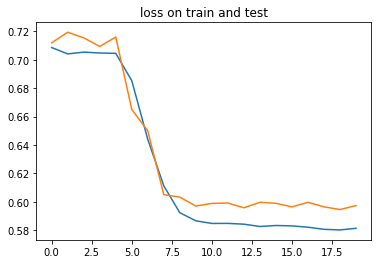

Last loss on train: 0.5813079236355503
Last loss on test: 0.5973102913091057


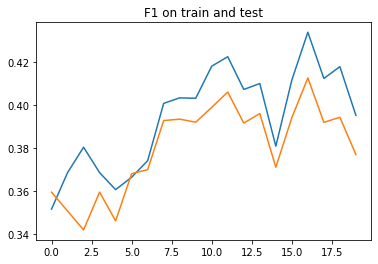

Last F1 on train: 0.39517426833642266
Last F1 on test: 0.3769952447006577


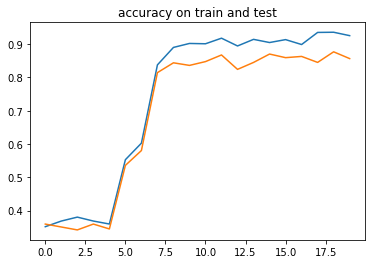

Last accuracy on train: 0.9254979902664117
Last accuracy on test: 0.8565944343021041


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.5315030101723064


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

na-B und-I ?-O
ich-B weiß-I !-O
--O machen-B sie-I witze-I ?-O
schon-B gut-I .-O
--O in-B ordnung-I .-O
weiß-B ich-I nicht-I .-O
--O ganz-B und-I gar-I nicht-I .-O
--O nicht-B wirklich-I .-O
es-O sind-O ja-O nur-O kartons-O ,-O stimmt-B 's-I ?-O
schon-B gut-I .-O
warum-B nicht-I ?-O
na-B und-I ?-O
--O schon-B gut-I .-O
stimmt-B 's-I ?-O
na-B gut-I ,-O kommt-O ,-O 2-O gegen-O einen-O .-O
also-B gut-I .-O
auf-B keinen-I fall-I .-O
--O ist-B schon-I gut-I .-O
--O das-B stimmt-I nicht-I .-O
keine-B ahnung-I .-O
damit-O ist-O das-O mädchen-O erwürgt-O worden-O stimmt-B 's-I ,-O martin-O ?-O
keine-B ahnung-I .-O
in-B ordnung-I ,-O gnädige-O frau-O .-O
--O mit-B vergnügen-I .-O
--O klasse-O --O ich-B weiß-I .-O
das-B geht-I gar-I nicht-I .-O
na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
--O keine-B ahnung-I .-O
keine-B ahnung-I .-O
--O ich-B weiß-I .-O
ja-O ,-O ich-B glaube-I schon-I .-O
--O kein-B problem-I ,-O terry-O .-O
ich-B verstehe-I .-O
du-B hast-I recht-I .-O
--O k

# Experiment 4, testing bi-directional

* RNN
* bi
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = BiRNN(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.005, 1, 1])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:01, 34.82it/s]

Train loss: 0.7142389628622267


91it [00:03, 23.30it/s]

Train loss: 0.7070890062385136


139it [00:05, 25.04it/s]

Train loss: 0.7055277872968603


186it [00:07, 24.96it/s]

Train loss: 0.7058936112456852


226it [00:08, 26.79it/s]


Train loss: 0.7075897537337409

Evaluating on train...


50it [00:01, 45.88it/s]

Val loss: 0.6968257016605801, Val f1: 0.3646341926521725, Val accuracy: 0.3643852074940999


95it [00:02, 43.30it/s]

Val loss: 0.6977508187294006, Val f1: 0.3729651414685779, Val accuracy: 0.3729015264246199


140it [00:03, 40.90it/s]

Val loss: 0.7003043934150979, Val f1: 0.3695682159176579, Val accuracy: 0.36957178204147906


185it [00:04, 40.60it/s]

Val loss: 0.7026172432634565, Val f1: 0.3687952834698889, Val accuracy: 0.3688339304592874


226it [00:06, 36.80it/s]


Val loss: 0.7041473330391778, Val f1: 0.36907156705856325, Val accuracy: 0.36913143078486127

Evaluating on test...


17it [00:00, 21.99it/s]

Val loss: 0.697709306081136, Val f1: 0.33316680987675984, Val accuracy: 0.3332999269167582


32it [00:01, 23.25it/s]

Val loss: 0.7312955935796102, Val f1: 0.35534202456474306, Val accuracy: 0.35551794767379763


50it [00:02, 24.96it/s]

Val loss: 0.7170883125729031, Val f1: 0.347950197590722, Val accuracy: 0.34810670018196105


65it [00:02, 25.18it/s]

Val loss: 0.7253584802150727, Val f1: 0.3442331120371819, Val accuracy: 0.34439899226029713


76it [00:03, 24.11it/s]


Val loss: 0.7173583134015401, Val f1: 0.3531316761175791, Val accuracy: 0.35328729112943014

starting Epoch 1
Training...


52it [00:01, 33.90it/s]

Train loss: 0.6959178103340997


96it [00:02, 33.75it/s]

Train loss: 0.702021923330095


140it [00:04, 33.91it/s]

Train loss: 0.7013230319376345


184it [00:05, 34.21it/s]

Train loss: 0.7058387329181035


226it [00:06, 33.88it/s]


Train loss: 0.7069919366306728

Evaluating on train...


50it [00:01, 45.67it/s]

Val loss: 0.710282317797343, Val f1: 0.34794581598705715, Val accuracy: 0.34807819061809114


95it [00:02, 42.48it/s]

Val loss: 0.7084944552845425, Val f1: 0.35165486103958554, Val accuracy: 0.3517882032526864


137it [00:03, 24.44it/s]

Val loss: 0.7072104096412659, Val f1: 0.3565931695478934, Val accuracy: 0.35672645767529804


185it [00:05, 23.33it/s]

Val loss: 0.7106933802366256, Val f1: 0.3553540666898092, Val accuracy: 0.35549069626463786


226it [00:07, 30.54it/s]


Val loss: 0.7065691248575846, Val f1: 0.3575805826981862, Val accuracy: 0.35771043207910325

Evaluating on test...


18it [00:00, 17.50it/s]

Val loss: 0.7243876894315083, Val f1: 0.33312891324361166, Val accuracy: 0.33328264753023784


34it [00:01, 31.45it/s]

Val loss: 0.7315198560555776, Val f1: 0.35532077054182687, Val accuracy: 0.35547054012616475


51it [00:01, 36.78it/s]

Val loss: 0.7162451187769572, Val f1: 0.35164098342259725, Val accuracy: 0.3517771343390147


64it [00:02, 37.94it/s]

Val loss: 0.7223202308019002, Val f1: 0.3581128939986229, Val accuracy: 0.3582563355565071


76it [00:02, 30.70it/s]


Val loss: 0.7109381238619487, Val f1: 0.36201944947242737, Val accuracy: 0.36215240915616354

starting Epoch 2
Training...


52it [00:01, 34.76it/s]

Train loss: 0.7005349490377638


94it [00:03, 24.27it/s]

Train loss: 0.7095958570639292


139it [00:05, 25.36it/s]

Train loss: 0.7077165347558481


185it [00:06, 26.96it/s]

Train loss: 0.7045337051153183


226it [00:08, 26.11it/s]


Train loss: 0.7069323065545824

Evaluating on train...


49it [00:01, 25.42it/s]

Val loss: 0.6976591110229492, Val f1: 0.36279483768675064, Val accuracy: 0.36292989585134716


93it [00:03, 15.37it/s]

Val loss: 0.7040914369954003, Val f1: 0.3553762647840712, Val accuracy: 0.3555142435762617


138it [00:06, 16.08it/s]

Val loss: 0.7028458405424047, Val f1: 0.3590835701536249, Val accuracy: 0.35922117674792253


184it [00:08, 25.41it/s]

Val loss: 0.7011080145835876, Val f1: 0.36093663258685005, Val accuracy: 0.3610729472504722


226it [00:10, 21.68it/s]


Val loss: 0.7062534983952841, Val f1: 0.3553767800331116, Val accuracy: 0.35552050431569415

Evaluating on test...


18it [00:00, 25.13it/s]

Val loss: 0.7559779008229573, Val f1: 0.33306604822476704, Val accuracy: 0.33325345516204835


33it [00:01, 25.34it/s]

Val loss: 0.7347415665785472, Val f1: 0.3331070005893707, Val accuracy: 0.33327595591545106


50it [00:01, 30.98it/s]

Val loss: 0.7394623637199402, Val f1: 0.33310893972714745, Val accuracy: 0.33329039017359413


66it [00:02, 36.16it/s]

Val loss: 0.7238183011611302, Val f1: 0.35535135318835576, Val accuracy: 0.35551528731981913


76it [00:02, 29.33it/s]


Val loss: 0.7181822935740153, Val f1: 0.35980513056119284, Val accuracy: 0.35996461153030396

starting Epoch 3
Training...


49it [00:01, 34.32it/s]

Train loss: 0.6988558650016785


97it [00:02, 36.37it/s]

Train loss: 0.7038859731621212


141it [00:04, 35.58it/s]

Train loss: 0.7033615469932556


185it [00:05, 32.96it/s]

Train loss: 0.7031375229358673


226it [00:06, 34.18it/s]


Train loss: 0.7051994813813104

Evaluating on train...


50it [00:01, 45.99it/s]

Val loss: 0.7006026241514418, Val f1: 0.34797095325258043, Val accuracy: 0.3481023609638214


95it [00:02, 43.33it/s]

Val loss: 0.7052859114276038, Val f1: 0.34981887771023645, Val accuracy: 0.34995952083004844


140it [00:03, 41.59it/s]

Val loss: 0.7045706077858254, Val f1: 0.3499072540689398, Val accuracy: 0.3498350865311093


184it [00:04, 39.31it/s]

Val loss: 0.7067056129376094, Val f1: 0.34942084319061706, Val accuracy: 0.3494042514099015


226it [00:05, 42.35it/s]


Val loss: 0.7057826042175293, Val f1: 0.3497241371207767, Val accuracy: 0.3498868032296499

Evaluating on test...


20it [00:00, 37.98it/s]

Val loss: 0.6739482124646504, Val f1: 0.38874998887379963, Val accuracy: 0.3888670881589254


37it [00:00, 38.74it/s]

Val loss: 0.6851214369138082, Val f1: 0.4053826113541921, Val accuracy: 0.40549028317133584


50it [00:01, 38.28it/s]

Val loss: 0.7018501308229235, Val f1: 0.38129350874159074, Val accuracy: 0.38142453498310513


66it [00:01, 36.84it/s]

Val loss: 0.706785969932874, Val f1: 0.3803647801280022, Val accuracy: 0.38050715972979865


76it [00:02, 37.85it/s]


Val loss: 0.711377325852712, Val f1: 0.3709173389275869, Val accuracy: 0.3710667637983958

starting Epoch 4
Training...


49it [00:01, 34.40it/s]

Train loss: 0.7042184167438084


97it [00:02, 34.56it/s]

Train loss: 0.7002396610048082


141it [00:04, 31.73it/s]

Train loss: 0.7040274893796002


185it [00:05, 32.63it/s]

Train loss: 0.7094266441133287


226it [00:06, 33.53it/s]


Train loss: 0.7069351172447205

Evaluating on train...


50it [00:01, 45.24it/s]

Val loss: 0.6996732923719619, Val f1: 0.4072386066118876, Val accuracy: 0.4073846790525648


95it [00:02, 42.40it/s]

Val loss: 0.7085143307844798, Val f1: 0.38500883910391065, Val accuracy: 0.38516482081678177


140it [00:03, 41.85it/s]

Val loss: 0.7063000135951572, Val f1: 0.37759916340863264, Val accuracy: 0.37774576522685865


185it [00:04, 40.51it/s]

Val loss: 0.7112990372710758, Val f1: 0.36740676479207146, Val accuracy: 0.3675599949227439


226it [00:05, 42.13it/s]


Val loss: 0.7058270573616028, Val f1: 0.3635230342547099, Val accuracy: 0.3636667369471656

Evaluating on test...


22it [00:00, 38.83it/s]

Val loss: 0.7289878368377686, Val f1: 0.33313401142756144, Val accuracy: 0.333315372467041


36it [00:00, 39.26it/s]

Val loss: 0.7194842616717021, Val f1: 0.33314879139264425, Val accuracy: 0.33331751624743144


49it [00:01, 38.76it/s]

Val loss: 0.7160796138975355, Val f1: 0.34796441263622707, Val accuracy: 0.3481284472677443


65it [00:01, 37.49it/s]

Val loss: 0.7160874754190445, Val f1: 0.3442578305800756, Val accuracy: 0.34441888084014255


76it [00:01, 38.55it/s]


Val loss: 0.7179249509175618, Val f1: 0.34203127066294353, Val accuracy: 0.3421908668677012

starting Epoch 5
Training...


49it [00:01, 33.92it/s]

Train loss: 0.6949687971009149


93it [00:02, 35.13it/s]

Train loss: 0.7101308597458733


141it [00:04, 34.10it/s]

Train loss: 0.7089746757789894


185it [00:05, 34.51it/s]

Train loss: 0.7105216297838423


226it [00:06, 33.85it/s]


Train loss: 0.7083802604675293

Evaluating on train...


50it [00:01, 44.95it/s]

Val loss: 0.6892194628715516, Val f1: 0.34799126187960305, Val accuracy: 0.3481201297707028


95it [00:02, 42.85it/s]

Val loss: 0.7052867862913343, Val f1: 0.3479667557610406, Val accuracy: 0.3481117324696647


140it [00:03, 40.80it/s]

Val loss: 0.706096065044403, Val f1: 0.3430315046398728, Val accuracy: 0.3431785367153309


185it [00:04, 41.19it/s]

Val loss: 0.709094833334287, Val f1: 0.3442638137274318, Val accuracy: 0.3444153454568651


226it [00:05, 42.28it/s]


Val loss: 0.7060437605116102, Val f1: 0.3538961398601532, Val accuracy: 0.35404205600420635

Evaluating on test...


20it [00:00, 37.95it/s]

Val loss: 0.7222705006599426, Val f1: 0.3331587016582489, Val accuracy: 0.3333333432674408


37it [00:00, 37.81it/s]

Val loss: 0.7145275592803955, Val f1: 0.33316160837809244, Val accuracy: 0.3333271404107412


50it [00:01, 38.13it/s]

Val loss: 0.7076210074954563, Val f1: 0.34797763890690275, Val accuracy: 0.34813110166125827


66it [00:01, 37.49it/s]

Val loss: 0.7175588528315227, Val f1: 0.3442522575457891, Val accuracy: 0.34441265811522803


76it [00:02, 37.87it/s]


Val loss: 0.7137268575032553, Val f1: 0.3509261000156403, Val accuracy: 0.3510851232210795

starting Epoch 6
Training...


49it [00:01, 34.08it/s]

Train loss: 0.6943156864908007


97it [00:02, 34.99it/s]

Train loss: 0.6907190912299686


141it [00:04, 35.77it/s]

Train loss: 0.7001388991320575


185it [00:05, 35.80it/s]

Train loss: 0.7033689936002095


226it [00:06, 33.83it/s]


Train loss: 0.703587704234653

Evaluating on train...


50it [00:01, 46.59it/s]

Val loss: 0.6983510441250271, Val f1: 0.392440265417099, Val accuracy: 0.39259260164366827


95it [00:02, 43.59it/s]

Val loss: 0.7003473692470127, Val f1: 0.3702159646484587, Val accuracy: 0.37037037975258297


140it [00:03, 39.60it/s]

Val loss: 0.7071172665666651, Val f1: 0.377615338784677, Val accuracy: 0.3777777870496114


188it [00:04, 40.53it/s]

Val loss: 0.7052044077052011, Val f1: 0.3702106432782279, Val accuracy: 0.37037037975258297


226it [00:05, 41.93it/s]


Val loss: 0.7049068954255846, Val f1: 0.368729572031233, Val accuracy: 0.3688888982931773

Evaluating on test...


23it [00:00, 39.71it/s]

Val loss: 0.7300873359044393, Val f1: 0.3331414500872294, Val accuracy: 0.3333333432674408


35it [00:00, 37.24it/s]

Val loss: 0.7305763800938924, Val f1: 0.33313839733600614, Val accuracy: 0.3333333432674408


52it [00:01, 38.50it/s]

Val loss: 0.7291350510385302, Val f1: 0.33314192758666145, Val accuracy: 0.3333333432674408


64it [00:01, 38.03it/s]

Val loss: 0.7211794793605805, Val f1: 0.36648432662089664, Val accuracy: 0.3666666761040688


76it [00:01, 38.23it/s]


Val loss: 0.7149820041656494, Val f1: 0.3598257907231649, Val accuracy: 0.36000000953674316

starting Epoch 7
Training...


49it [00:01, 34.35it/s]

Train loss: 0.7102880809042189


93it [00:02, 33.93it/s]

Train loss: 0.7060730636119843


141it [00:04, 33.18it/s]

Train loss: 0.7033324656663118


185it [00:05, 34.68it/s]

Train loss: 0.7086095124483108


226it [00:06, 33.71it/s]


Train loss: 0.70586486392551

Evaluating on train...


50it [00:01, 45.65it/s]

Val loss: 0.7044828746053907, Val f1: 0.347985710700353, Val accuracy: 0.34814815786149766


95it [00:02, 44.20it/s]

Val loss: 0.7072539422247145, Val f1: 0.3702060206068887, Val accuracy: 0.37037037975258297


140it [00:03, 41.03it/s]

Val loss: 0.7077803413073221, Val f1: 0.37267580495940317, Val accuracy: 0.3728395155182591


185it [00:04, 40.40it/s]

Val loss: 0.7067524827188916, Val f1: 0.373909768793318, Val accuracy: 0.3740740834010972


226it [00:05, 42.03it/s]


Val loss: 0.7065291992823283, Val f1: 0.36872478445370993, Val accuracy: 0.3688888982931773

Evaluating on test...


22it [00:00, 40.26it/s]

Val loss: 0.6938254753748576, Val f1: 0.37762749393781025, Val accuracy: 0.3777777870496114


35it [00:00, 39.32it/s]

Val loss: 0.7099948108196259, Val f1: 0.3553894201914469, Val accuracy: 0.3555555651585261


52it [00:01, 38.99it/s]

Val loss: 0.716646503077613, Val f1: 0.3479751514063941, Val accuracy: 0.34814815786149766


64it [00:01, 37.94it/s]

Val loss: 0.7112346599499385, Val f1: 0.36649949798981346, Val accuracy: 0.3666666761040688


76it [00:01, 38.60it/s]


Val loss: 0.7115650113423665, Val f1: 0.3687211271127065, Val accuracy: 0.3688888982931773

starting Epoch 8
Training...


52it [00:01, 34.39it/s]

Train loss: 0.6944607628716363


96it [00:02, 35.29it/s]

Train loss: 0.7069082657496134


140it [00:04, 22.76it/s]

Train loss: 0.7029307299190097


184it [00:05, 35.23it/s]

Train loss: 0.7070585350195567


226it [00:07, 31.96it/s]


Train loss: 0.7051516021622551

Evaluating on train...


50it [00:01, 41.47it/s]

Val loss: 0.6979620854059855, Val f1: 0.3776255640718672, Val accuracy: 0.3777777870496114


95it [00:02, 43.21it/s]

Val loss: 0.6972789916727278, Val f1: 0.3554053601291445, Val accuracy: 0.3555555651585261


140it [00:03, 38.79it/s]

Val loss: 0.6989980026527688, Val f1: 0.357871076575032, Val accuracy: 0.35802470092420224


184it [00:04, 40.71it/s]

Val loss: 0.7013405998547871, Val f1: 0.3591022370590104, Val accuracy: 0.35925926880704034


226it [00:05, 41.36it/s]


Val loss: 0.7060993615786234, Val f1: 0.3568740220864614, Val accuracy: 0.3570370466179318

Evaluating on test...


21it [00:00, 37.81it/s]

Val loss: 0.6863458434740702, Val f1: 0.42208375334739684, Val accuracy: 0.422222230831782


38it [00:00, 38.90it/s]

Val loss: 0.6932506402333577, Val f1: 0.37763157685597737, Val accuracy: 0.3777777870496114


50it [00:01, 38.81it/s]

Val loss: 0.7090325487984551, Val f1: 0.39242475032806395, Val accuracy: 0.39259260164366827


66it [00:01, 37.42it/s]

Val loss: 0.7079455743233363, Val f1: 0.37761280486981075, Val accuracy: 0.3777777870496114


76it [00:02, 37.92it/s]


Val loss: 0.7088870334625245, Val f1: 0.3687228413422902, Val accuracy: 0.3688888982931773

starting Epoch 9
Training...


48it [00:01, 34.64it/s]

Train loss: 0.7107043425242107


96it [00:02, 35.51it/s]

Train loss: 0.709574486149682


140it [00:04, 35.11it/s]

Train loss: 0.7026754467575639


184it [00:05, 33.10it/s]

Train loss: 0.7007529377937317


226it [00:06, 33.71it/s]


Train loss: 0.7050784142812093

Evaluating on train...


50it [00:01, 45.67it/s]

Val loss: 0.6960025721126133, Val f1: 0.3776289165019989, Val accuracy: 0.3777777870496114


95it [00:02, 42.27it/s]

Val loss: 0.7017587979634603, Val f1: 0.3850288907686869, Val accuracy: 0.38518519434663984


140it [00:03, 41.73it/s]

Val loss: 0.7024373522511235, Val f1: 0.3825587917257238, Val accuracy: 0.3827160585809637


185it [00:04, 39.83it/s]

Val loss: 0.7030161910586887, Val f1: 0.3813231342368656, Val accuracy: 0.38148149069812565


226it [00:05, 38.96it/s]


Val loss: 0.7060587443245782, Val f1: 0.3746524715423584, Val accuracy: 0.37481482413080003

Evaluating on test...


20it [00:00, 37.73it/s]

Val loss: 0.7238649845123291, Val f1: 0.3775878647963206, Val accuracy: 0.3777777870496114


37it [00:00, 38.29it/s]

Val loss: 0.7207768499851227, Val f1: 0.35537427763144175, Val accuracy: 0.3555555651585261


49it [00:01, 37.18it/s]

Val loss: 0.7160062260097928, Val f1: 0.36278692947493657, Val accuracy: 0.36296297245555453


65it [00:01, 36.80it/s]

Val loss: 0.7086509386698405, Val f1: 0.3665000081062317, Val accuracy: 0.3666666761040688


76it [00:02, 37.55it/s]


Val loss: 0.7130464498202006, Val f1: 0.3598283123970032, Val accuracy: 0.36000000953674316

starting Epoch 10
Training...


52it [00:01, 33.69it/s]

Train loss: 0.7118302875094944


96it [00:02, 34.73it/s]

Train loss: 0.7112603452470567


140it [00:04, 33.90it/s]

Train loss: 0.7079067080109208


184it [00:05, 34.69it/s]

Train loss: 0.7053558442327711


226it [00:06, 33.61it/s]


Train loss: 0.7030878043174744

Evaluating on train...


50it [00:01, 45.50it/s]

Val loss: 0.713774213525984, Val f1: 0.37760477463404335, Val accuracy: 0.3777777870496114


95it [00:02, 43.91it/s]

Val loss: 0.7016959541373783, Val f1: 0.3776207605997721, Val accuracy: 0.3777777870496114


140it [00:03, 41.10it/s]

Val loss: 0.7056210429580123, Val f1: 0.37267791363928054, Val accuracy: 0.3728395155182591


185it [00:04, 40.60it/s]

Val loss: 0.7046017706394195, Val f1: 0.3628027187453376, Val accuracy: 0.36296297245555453


226it [00:05, 42.47it/s]


Val loss: 0.7052276055018107, Val f1: 0.36576429843902586, Val accuracy: 0.3659259353743659

Evaluating on test...


22it [00:00, 39.36it/s]

Val loss: 0.7134290258089702, Val f1: 0.3776042362054189, Val accuracy: 0.3777777870496114


34it [00:00, 38.75it/s]

Val loss: 0.7145765721797943, Val f1: 0.3553819566965103, Val accuracy: 0.3555555651585261


51it [00:01, 38.83it/s]

Val loss: 0.7249221086502076, Val f1: 0.3627742330233256, Val accuracy: 0.36296297245555453


67it [00:01, 36.50it/s]

Val loss: 0.7140030175447464, Val f1: 0.38871212701002755, Val accuracy: 0.3888888979951541


76it [00:01, 38.17it/s]


Val loss: 0.714773600101471, Val f1: 0.38649000922838844, Val accuracy: 0.3866666758060455

starting Epoch 11
Training...


49it [00:01, 32.74it/s]

Train loss: 0.6882973167631361


93it [00:02, 35.10it/s]

Train loss: 0.6984109156661563


141it [00:04, 34.85it/s]

Train loss: 0.7012844853931003


185it [00:05, 34.78it/s]

Train loss: 0.7022790826029248


226it [00:06, 33.68it/s]


Train loss: 0.7046298019091288

Evaluating on train...


50it [00:01, 46.11it/s]

Val loss: 0.7037687142690022, Val f1: 0.3331767135196262, Val accuracy: 0.3333333432674408


95it [00:02, 44.19it/s]

Val loss: 0.7192492710219489, Val f1: 0.34056243399779, Val accuracy: 0.34074075056446923


140it [00:03, 41.13it/s]

Val loss: 0.7167051355044047, Val f1: 0.3529095749060313, Val accuracy: 0.35308642939284995


185it [00:04, 39.93it/s]

Val loss: 0.710040036506123, Val f1: 0.3553870861728986, Val accuracy: 0.3555555651585261


226it [00:05, 41.99it/s]


Val loss: 0.7085896084043715, Val f1: 0.35687043600612217, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 38.69it/s]

Val loss: 0.7530115485191345, Val f1: 0.33311588962872823, Val accuracy: 0.3333333432674408


36it [00:00, 36.88it/s]

Val loss: 0.741787870724996, Val f1: 0.3331275343894958, Val accuracy: 0.3333333432674408


52it [00:01, 37.72it/s]

Val loss: 0.739219249619378, Val f1: 0.34794354836146035, Val accuracy: 0.34814815786149766


65it [00:01, 38.57it/s]

Val loss: 0.728207927942276, Val f1: 0.3664762432376544, Val accuracy: 0.3666666761040688


76it [00:02, 37.66it/s]


Val loss: 0.716104150613149, Val f1: 0.3687134265899658, Val accuracy: 0.3688888982931773

starting Epoch 12
Training...


52it [00:01, 34.94it/s]

Train loss: 0.7120467040273878


96it [00:02, 35.54it/s]

Train loss: 0.7186620791753133


140it [00:04, 34.62it/s]

Train loss: 0.7048578452180934


184it [00:05, 34.29it/s]

Train loss: 0.7069576197200351


226it [00:06, 33.71it/s]


Train loss: 0.7065615476502313

Evaluating on train...


50it [00:01, 45.78it/s]

Val loss: 0.7049477895100912, Val f1: 0.3479881842931112, Val accuracy: 0.34814815786149766


95it [00:02, 44.22it/s]

Val loss: 0.7105426616138882, Val f1: 0.36279452012644875, Val accuracy: 0.36296297245555453


140it [00:03, 41.46it/s]

Val loss: 0.7046075820922851, Val f1: 0.3578641485284876, Val accuracy: 0.35802470092420224


185it [00:04, 39.34it/s]

Val loss: 0.7048932807313071, Val f1: 0.36280226078298355, Val accuracy: 0.36296297245555453


226it [00:05, 41.85it/s]


Val loss: 0.706362608273824, Val f1: 0.35687475800514223, Val accuracy: 0.3570370466179318

Evaluating on test...


20it [00:00, 37.26it/s]

Val loss: 0.7121774315834045, Val f1: 0.33316964109738667, Val accuracy: 0.3333333432674408


36it [00:00, 37.24it/s]

Val loss: 0.7083526233832041, Val f1: 0.3331710994243622, Val accuracy: 0.3333333432674408


52it [00:01, 37.95it/s]

Val loss: 0.7087801747851902, Val f1: 0.3331707888179355, Val accuracy: 0.3333333432674408


64it [00:01, 38.05it/s]

Val loss: 0.7152844309806824, Val f1: 0.3442718302210172, Val accuracy: 0.3444444542129835


76it [00:02, 37.73it/s]


Val loss: 0.7173429807027181, Val f1: 0.34204750537872314, Val accuracy: 0.3422222320238749

starting Epoch 13
Training...


49it [00:01, 33.94it/s]

Train loss: 0.6931358827484979


93it [00:02, 30.82it/s]

Train loss: 0.70890374912156


138it [00:05, 17.89it/s]

Train loss: 0.7092782228081315


185it [00:07, 22.88it/s]

Train loss: 0.7078434990512


226it [00:09, 25.08it/s]


Train loss: 0.7051224676767985

Evaluating on train...


50it [00:01, 45.89it/s]

Val loss: 0.7003121031655206, Val f1: 0.36280884477827285, Val accuracy: 0.36296297245555453


95it [00:02, 43.56it/s]

Val loss: 0.6999755872620477, Val f1: 0.3479939189222124, Val accuracy: 0.34814815786149766


140it [00:03, 40.77it/s]

Val loss: 0.7047674894332886, Val f1: 0.3578633193616514, Val accuracy: 0.35802470092420224


185it [00:04, 39.47it/s]

Val loss: 0.7035157677200106, Val f1: 0.36280375089910294, Val accuracy: 0.36296297245555453


226it [00:05, 41.81it/s]


Val loss: 0.7063301536771986, Val f1: 0.36279985785484314, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 38.84it/s]

Val loss: 0.6922757824261984, Val f1: 0.42207295894622804, Val accuracy: 0.422222230831782


36it [00:00, 37.75it/s]

Val loss: 0.7170130054155985, Val f1: 0.3775978058576584, Val accuracy: 0.3777777870496114


53it [00:01, 38.96it/s]

Val loss: 0.7217200716336568, Val f1: 0.3775927656226688, Val accuracy: 0.3777777870496114


65it [00:01, 39.05it/s]

Val loss: 0.7151610096295674, Val f1: 0.37760048458973566, Val accuracy: 0.3777777870496114


76it [00:01, 38.34it/s]


Val loss: 0.7101441502571106, Val f1: 0.38649601936340333, Val accuracy: 0.3866666758060455

starting Epoch 14
Training...


49it [00:01, 33.70it/s]

Train loss: 0.7086679816246033


97it [00:02, 34.83it/s]

Train loss: 0.707938262489107


141it [00:04, 33.99it/s]

Train loss: 0.7073782660343029


185it [00:05, 32.96it/s]

Train loss: 0.7082291487190459


226it [00:06, 33.40it/s]


Train loss: 0.707205080986023

Evaluating on train...


50it [00:01, 44.45it/s]

Val loss: 0.7130811373392741, Val f1: 0.3479777216911316, Val accuracy: 0.34814815786149766


95it [00:02, 44.17it/s]

Val loss: 0.7021626041995155, Val f1: 0.35539863208929695, Val accuracy: 0.3555555651585261


140it [00:03, 42.14it/s]

Val loss: 0.7061473775793005, Val f1: 0.352923595905304, Val accuracy: 0.35308642939284995


185it [00:04, 41.13it/s]

Val loss: 0.7042026764816708, Val f1: 0.3665048170420859, Val accuracy: 0.3666666761040688


226it [00:05, 39.11it/s]


Val loss: 0.7048416283395555, Val f1: 0.3687260850270589, Val accuracy: 0.3688888982931773

Evaluating on test...


20it [00:00, 37.94it/s]

Val loss: 0.7295396208763123, Val f1: 0.3331304391225179, Val accuracy: 0.3333333432674408


36it [00:00, 37.15it/s]

Val loss: 0.716425625483195, Val f1: 0.37759611109892527, Val accuracy: 0.3777777870496114


52it [00:01, 38.17it/s]

Val loss: 0.7151252097553678, Val f1: 0.36278630097707115, Val accuracy: 0.36296297245555453


64it [00:01, 38.22it/s]

Val loss: 0.7089135179917018, Val f1: 0.3664984852075577, Val accuracy: 0.3666666761040688


76it [00:02, 37.89it/s]


Val loss: 0.7139257963498433, Val f1: 0.36871341864267987, Val accuracy: 0.3688888982931773

starting Epoch 15
Training...


49it [00:01, 34.53it/s]

Train loss: 0.6987104919221666


93it [00:02, 33.70it/s]

Train loss: 0.7116529862085978


141it [00:04, 33.55it/s]

Train loss: 0.7083400183253818


185it [00:05, 34.60it/s]

Train loss: 0.7099279873900943


226it [00:06, 33.34it/s]


Train loss: 0.7066736541854011

Evaluating on train...


52it [00:01, 39.68it/s]

Val loss: 0.7134359651141696, Val f1: 0.362794037659963, Val accuracy: 0.36296297245555453


96it [00:02, 40.17it/s]

Val loss: 0.7072141680452558, Val f1: 0.36280083490742576, Val accuracy: 0.36296297245555453


140it [00:03, 39.49it/s]

Val loss: 0.7067532186154966, Val f1: 0.3628019176147602, Val accuracy: 0.36296297245555453


188it [00:04, 40.16it/s]

Val loss: 0.7085490673780441, Val f1: 0.35539246251185735, Val accuracy: 0.3555555651585261


226it [00:05, 39.24it/s]


Val loss: 0.706189881960551, Val f1: 0.35983916030989754, Val accuracy: 0.36000000953674316

Evaluating on test...


21it [00:00, 37.65it/s]

Val loss: 0.7085727651913961, Val f1: 0.3331701040267944, Val accuracy: 0.3333333432674408


37it [00:00, 37.53it/s]

Val loss: 0.7140249371528625, Val f1: 0.3331635743379593, Val accuracy: 0.3333333432674408


49it [00:01, 36.98it/s]

Val loss: 0.7162700613339742, Val f1: 0.3479741175969442, Val accuracy: 0.34814815786149766


65it [00:01, 36.78it/s]

Val loss: 0.7122327228387196, Val f1: 0.34427548001209896, Val accuracy: 0.3444444542129835


76it [00:02, 37.15it/s]


Val loss: 0.7136157043774922, Val f1: 0.3687170445919037, Val accuracy: 0.3688888982931773

starting Epoch 16
Training...


49it [00:01, 33.95it/s]

Train loss: 0.7234805398517185


97it [00:02, 34.88it/s]

Train loss: 0.7130279945002662


141it [00:04, 33.05it/s]

Train loss: 0.7147779173321194


185it [00:05, 35.05it/s]

Train loss: 0.7076092835929658


226it [00:06, 33.32it/s]


Train loss: 0.7035341686672635

Evaluating on train...


50it [00:01, 44.58it/s]

Val loss: 0.7123939288987053, Val f1: 0.37760822243160674, Val accuracy: 0.3777777870496114


95it [00:02, 43.85it/s]

Val loss: 0.7128747575812869, Val f1: 0.37019927865929075, Val accuracy: 0.37037037975258297


140it [00:03, 41.25it/s]

Val loss: 0.7076963623364766, Val f1: 0.35786027797946224, Val accuracy: 0.35802470092420224


184it [00:04, 38.15it/s]

Val loss: 0.7058687931961484, Val f1: 0.36002332104576956, Val accuracy: 0.36018519467777677


226it [00:05, 41.01it/s]


Val loss: 0.7067371026674907, Val f1: 0.36057794173558555, Val accuracy: 0.3607407502333323

Evaluating on test...


20it [00:00, 36.91it/s]

Val loss: 0.6794364929199219, Val f1: 0.37764851848284403, Val accuracy: 0.3777777870496114


36it [00:00, 37.27it/s]

Val loss: 0.7150747160116832, Val f1: 0.3776042948166529, Val accuracy: 0.3777777870496114


52it [00:01, 36.69it/s]

Val loss: 0.7105206622017755, Val f1: 0.39242400195863514, Val accuracy: 0.39259260164366827


64it [00:01, 36.19it/s]

Val loss: 0.7126323441664378, Val f1: 0.3776078482468923, Val accuracy: 0.3777777870496114


76it [00:02, 36.65it/s]


Val loss: 0.7113321979840597, Val f1: 0.3687197697162628, Val accuracy: 0.3688888982931773

starting Epoch 17
Training...


50it [00:01, 27.46it/s]

Train loss: 0.6958160678545634


94it [00:03, 33.79it/s]

Train loss: 0.702368739578459


138it [00:04, 34.00it/s]

Train loss: 0.7051929147155197


186it [00:06, 32.95it/s]

Train loss: 0.7055148631334305


226it [00:07, 31.20it/s]


Train loss: 0.7043628295262655

Evaluating on train...


50it [00:01, 43.11it/s]

Val loss: 0.7113611923323737, Val f1: 0.3627904540962643, Val accuracy: 0.36296297245555453


95it [00:02, 43.14it/s]

Val loss: 0.7070288810465071, Val f1: 0.362797236111429, Val accuracy: 0.36296297245555453


140it [00:03, 40.48it/s]

Val loss: 0.7058125094131187, Val f1: 0.3726760188738505, Val accuracy: 0.3728395155182591


184it [00:04, 40.31it/s]

Val loss: 0.7043279200792313, Val f1: 0.37020997554063795, Val accuracy: 0.37037037975258297


226it [00:05, 41.53it/s]


Val loss: 0.7060616331630283, Val f1: 0.3746517558892568, Val accuracy: 0.37481482413080003

Evaluating on test...


20it [00:00, 38.33it/s]

Val loss: 0.7356288830439249, Val f1: 0.37757904728253683, Val accuracy: 0.3777777870496114


36it [00:00, 36.80it/s]

Val loss: 0.7273978153864543, Val f1: 0.35536951621373497, Val accuracy: 0.3555555651585261


52it [00:01, 36.25it/s]

Val loss: 0.7179372760984633, Val f1: 0.362787926197052, Val accuracy: 0.36296297245555453


64it [00:01, 37.40it/s]

Val loss: 0.717116669813792, Val f1: 0.3553806280096372, Val accuracy: 0.3555555651585261


76it [00:02, 37.56it/s]


Val loss: 0.714999258518219, Val f1: 0.3598270257314046, Val accuracy: 0.36000000953674316

starting Epoch 18
Training...


49it [00:01, 34.44it/s]

Train loss: 0.7182996657159594


97it [00:02, 35.28it/s]

Train loss: 0.707170362604989


141it [00:04, 34.14it/s]

Train loss: 0.709521785488835


185it [00:05, 33.96it/s]

Train loss: 0.7106609374284745


226it [00:06, 33.24it/s]


Train loss: 0.7044462294048733

Evaluating on train...


50it [00:01, 45.28it/s]

Val loss: 0.7207770493295458, Val f1: 0.3331519756052229, Val accuracy: 0.3333333432674408


95it [00:02, 43.36it/s]

Val loss: 0.7097826600074768, Val f1: 0.340574883752399, Val accuracy: 0.34074075056446923


140it [00:03, 40.92it/s]

Val loss: 0.7060790799282215, Val f1: 0.3529248899883694, Val accuracy: 0.35308642939284995


186it [00:04, 39.96it/s]

Val loss: 0.7033218764596515, Val f1: 0.35909995006190404, Val accuracy: 0.35925926880704034


226it [00:05, 41.71it/s]


Val loss: 0.7042031468285455, Val f1: 0.3628023836347792, Val accuracy: 0.36296297245555453

Evaluating on test...


20it [00:00, 37.42it/s]

Val loss: 0.704932717482249, Val f1: 0.3331775883833567, Val accuracy: 0.3333333432674408


37it [00:00, 39.21it/s]

Val loss: 0.7067415754000346, Val f1: 0.3331734587748845, Val accuracy: 0.3333333432674408


49it [00:01, 37.13it/s]

Val loss: 0.7165822823842366, Val f1: 0.33316066397560967, Val accuracy: 0.3333333432674408


65it [00:01, 37.49it/s]

Val loss: 0.7124814381202061, Val f1: 0.35538704295953116, Val accuracy: 0.3555555651585261


76it [00:02, 37.41it/s]


Val loss: 0.7116421135266622, Val f1: 0.3687204722563426, Val accuracy: 0.3688888982931773

starting Epoch 19
Training...


49it [00:01, 33.58it/s]

Train loss: 0.7125936733351813


93it [00:02, 33.41it/s]

Train loss: 0.6995037456353506


141it [00:04, 33.42it/s]

Train loss: 0.7031370626555549


185it [00:05, 32.00it/s]

Train loss: 0.7039138638310962


226it [00:06, 33.21it/s]


Train loss: 0.7065690615442064

Evaluating on train...


50it [00:01, 45.26it/s]

Val loss: 0.7037844803598192, Val f1: 0.34798819820086163, Val accuracy: 0.34814815786149766


95it [00:02, 43.11it/s]

Val loss: 0.708802404668596, Val f1: 0.35538863506582047, Val accuracy: 0.3555555651585261


140it [00:03, 41.00it/s]

Val loss: 0.7057864913234004, Val f1: 0.3578611928003806, Val accuracy: 0.35802470092420224


188it [00:04, 38.51it/s]

Val loss: 0.7061870641178555, Val f1: 0.36279887441131803, Val accuracy: 0.36296297245555453


226it [00:05, 40.94it/s]


Val loss: 0.7064652056164211, Val f1: 0.35983572549290127, Val accuracy: 0.36000000953674316

Evaluating on test...


20it [00:00, 37.94it/s]

Val loss: 0.7278909683227539, Val f1: 0.33313984870910646, Val accuracy: 0.3333333432674408


36it [00:00, 36.12it/s]

Val loss: 0.6979660173257192, Val f1: 0.3776212394237518, Val accuracy: 0.3777777870496114


52it [00:01, 37.88it/s]

Val loss: 0.7052073968781365, Val f1: 0.3776120556725396, Val accuracy: 0.3777777870496114


64it [00:01, 38.05it/s]

Val loss: 0.7043548037608465, Val f1: 0.36650380343198774, Val accuracy: 0.3666666761040688


76it [00:02, 37.13it/s]

Val loss: 0.7121279811859131, Val f1: 0.3598287244637807, Val accuracy: 0.36000000953674316


## Graphics

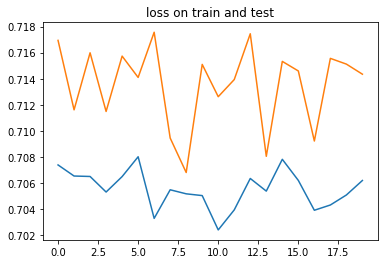

Last loss on train: 0.7062045886980749
Last loss on test: 0.7143491051698986


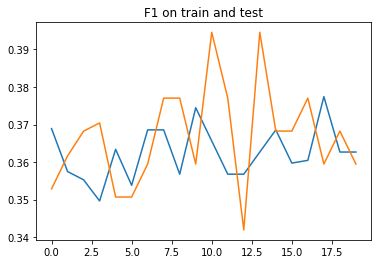

Last F1 on train: 0.3626683107783309
Last F1 on test: 0.3594747193549809


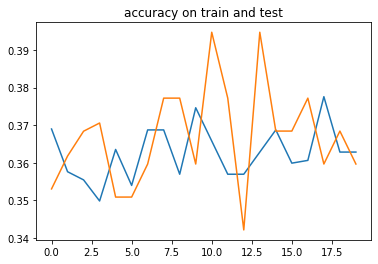

Last accuracy on train: 0.3628318679016248
Last accuracy on test: 0.3596491323489892


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.987440315549097


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

Доля предложений с ДФ среди правильных 0.0
Количество предложений с ДФ среди правильных 0


# Experiment 4, testing bi-directional with weights (0.001734, 1, 0.72)

* RNN
* bi
* 1 cell
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = BiRNN(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


50it [00:02, 27.39it/s]

Train loss: 0.6880868527624342


93it [00:03, 30.20it/s]

Train loss: 0.6618993964460161


136it [00:05, 24.14it/s]

Train loss: 0.6498434865916217


183it [00:08, 16.87it/s]

Train loss: 0.6431702974769804


226it [00:09, 22.63it/s]


Train loss: 0.6352809569570753

Evaluating on train...


48it [00:01, 26.95it/s]

Val loss: 0.5937274403042263, Val f1: 0.375566695133845, Val accuracy: 0.9276563372876909


93it [00:03, 25.49it/s]

Val loss: 0.5961197555065155, Val f1: 0.37683371901512147, Val accuracy: 0.9144462916586135


141it [00:04, 38.07it/s]

Val loss: 0.6002963971208644, Val f1: 0.37953283301106205, Val accuracy: 0.9038826717270745


185it [00:06, 36.84it/s]

Val loss: 0.6002760827541351, Val f1: 0.3789917677640915, Val accuracy: 0.8991474045647515


226it [00:07, 31.74it/s]


Val loss: 0.6001729583740234, Val f1: 0.37983317573865255, Val accuracy: 0.8960675863424937

Evaluating on test...


22it [00:00, 38.70it/s]

Val loss: 0.6124691446622212, Val f1: 0.38084806203842164, Val accuracy: 0.900746738910675


34it [00:00, 39.33it/s]

Val loss: 0.6234208782513936, Val f1: 0.37758499880631763, Val accuracy: 0.8814935127894084


52it [00:01, 38.15it/s]

Val loss: 0.6144528574413723, Val f1: 0.37488974067899916, Val accuracy: 0.8587322248352899


64it [00:01, 37.62it/s]

Val loss: 0.625607818365097, Val f1: 0.37731809516747794, Val accuracy: 0.8469797556598981


76it [00:01, 38.36it/s]


Val loss: 0.6234960015614828, Val f1: 0.3776598223050435, Val accuracy: 0.8447527134418488

starting Epoch 1
Training...


49it [00:01, 32.85it/s]

Train loss: 0.597559302382999


93it [00:02, 34.02it/s]

Train loss: 0.5891388542122311


141it [00:04, 34.22it/s]

Train loss: 0.5918983883327908


185it [00:05, 33.95it/s]

Train loss: 0.5949804060988956


226it [00:06, 33.39it/s]


Train loss: 0.5943609094619751

Evaluating on train...


50it [00:01, 45.62it/s]

Val loss: 0.5782667795817057, Val f1: 0.3922069052855174, Val accuracy: 0.9277071641551123


95it [00:02, 43.99it/s]

Val loss: 0.5779772546556261, Val f1: 0.3994835876756244, Val accuracy: 0.9397326704528597


140it [00:03, 40.84it/s]

Val loss: 0.579694570435418, Val f1: 0.3998740918106503, Val accuracy: 0.9314476317829556


188it [00:04, 40.46it/s]

Val loss: 0.579410578807195, Val f1: 0.39969914472765394, Val accuracy: 0.934566107392311


226it [00:05, 41.59it/s]


Val loss: 0.5784155707889133, Val f1: 0.3987779574924045, Val accuracy: 0.9291138989395565

Evaluating on test...


16it [00:00, 27.72it/s]

Val loss: 0.5976747353871663, Val f1: 0.39010673960049946, Val accuracy: 0.8659605324268341


31it [00:01, 21.36it/s]

Val loss: 0.6037097334861755, Val f1: 0.3842387855052948, Val accuracy: 0.8632267653942108


49it [00:02, 23.77it/s]

Val loss: 0.6060622731844584, Val f1: 0.3865025712384118, Val accuracy: 0.8661192735036214


64it [00:02, 23.80it/s]

Val loss: 0.6047326644261678, Val f1: 0.3871786187092463, Val accuracy: 0.8739290644725164


76it [00:03, 24.15it/s]


Val loss: 0.6015368858973186, Val f1: 0.3932868198553721, Val accuracy: 0.8890005485216776

starting Epoch 2
Training...


48it [00:02, 24.54it/s]

Train loss: 0.5889798098140293


97it [00:03, 33.43it/s]

Train loss: 0.5884563465913136


138it [00:05, 25.87it/s]

Train loss: 0.582574893368615


183it [00:07, 25.14it/s]

Train loss: 0.5832947350210613


226it [00:08, 25.53it/s]


Train loss: 0.5832132792472839

Evaluating on train...


48it [00:01, 27.16it/s]

Val loss: 0.5733849498960707, Val f1: 0.3878908700413174, Val accuracy: 0.950648832321167


93it [00:03, 25.80it/s]

Val loss: 0.5752217590808868, Val f1: 0.38684612645043265, Val accuracy: 0.9400765144162708


142it [00:05, 33.71it/s]

Val loss: 0.5750390233816924, Val f1: 0.3861342456605699, Val accuracy: 0.9479509024708359


186it [00:06, 37.25it/s]

Val loss: 0.5736520419518153, Val f1: 0.386337395840221, Val accuracy: 0.9465854543778631


226it [00:07, 30.01it/s]


Val loss: 0.5737608705626593, Val f1: 0.38701131582260134, Val accuracy: 0.9525195801258087

Evaluating on test...


20it [00:00, 37.94it/s]

Val loss: 0.5790971557299296, Val f1: 0.39563645323117574, Val accuracy: 0.9517019907633464


36it [00:00, 38.04it/s]

Val loss: 0.5879317502180735, Val f1: 0.3877063304185867, Val accuracy: 0.9458438674608867


52it [00:01, 36.71it/s]

Val loss: 0.5906473477681478, Val f1: 0.38547720909118655, Val accuracy: 0.9431271394093831


64it [00:01, 36.54it/s]

Val loss: 0.5913699060678482, Val f1: 0.38443129062652587, Val accuracy: 0.9318702588478724


76it [00:02, 37.57it/s]


Val loss: 0.5873312290509541, Val f1: 0.3834683815638224, Val accuracy: 0.9430305687586467

starting Epoch 3
Training...


49it [00:01, 33.00it/s]

Train loss: 0.5686185518900554


93it [00:02, 34.39it/s]

Train loss: 0.5702786823113759


141it [00:04, 34.70it/s]

Train loss: 0.5729502311459294


185it [00:05, 34.89it/s]

Train loss: 0.577637979388237


226it [00:06, 33.61it/s]


Train loss: 0.5765168354246352

Evaluating on train...


50it [00:01, 44.99it/s]

Val loss: 0.5792869475152758, Val f1: 0.451434193054835, Val accuracy: 0.8788004689746433


95it [00:02, 43.06it/s]

Val loss: 0.5834294120470683, Val f1: 0.46135947273837197, Val accuracy: 0.9028173334068722


140it [00:03, 41.08it/s]

Val loss: 0.5886841791647451, Val f1: 0.4599114709430271, Val accuracy: 0.8944996471758242


185it [00:04, 40.44it/s]

Val loss: 0.5861830098761452, Val f1: 0.46190577099720637, Val accuracy: 0.8946127603451411


226it [00:05, 40.57it/s]


Val loss: 0.585023869143592, Val f1: 0.466644374926885, Val accuracy: 0.9037012206183539

Evaluating on test...


18it [00:00, 24.79it/s]

Val loss: 0.6327499429384867, Val f1: 0.47275853554407754, Val accuracy: 0.8889552036921183


33it [00:01, 24.08it/s]

Val loss: 0.6408066511154175, Val f1: 0.4591852287451426, Val accuracy: 0.8298283010721207


50it [00:01, 30.55it/s]

Val loss: 0.6256109913190205, Val f1: 0.4535638299253252, Val accuracy: 0.8655368241998884


63it [00:02, 25.01it/s]

Val loss: 0.6189592142899831, Val f1: 0.4472188199559847, Val accuracy: 0.8521357019742329


76it [00:03, 24.90it/s]


Val loss: 0.6157898465792339, Val f1: 0.44693716684977214, Val accuracy: 0.8656469718615214

starting Epoch 4
Training...


47it [00:02, 23.91it/s]

Train loss: 0.5764887796507941


95it [00:04, 24.61it/s]

Train loss: 0.5744943029350704


139it [00:05, 25.26it/s]

Train loss: 0.5758811381128099


184it [00:07, 22.71it/s]

Train loss: 0.5755341880851321


226it [00:09, 23.64it/s]


Train loss: 0.5736004983054267

Evaluating on train...


49it [00:01, 26.60it/s]

Val loss: 0.5684031446774801, Val f1: 0.3986250850889418, Val accuracy: 0.9396293818950653


94it [00:03, 25.65it/s]

Val loss: 0.5688354147805108, Val f1: 0.40520702799161273, Val accuracy: 0.9531786352396011


140it [00:04, 36.32it/s]

Val loss: 0.5684328706176193, Val f1: 0.40434064776809125, Val accuracy: 0.958646606736713


185it [00:06, 37.68it/s]

Val loss: 0.5698899216122097, Val f1: 0.40434668627050185, Val accuracy: 0.9518153076370557


226it [00:07, 31.28it/s]


Val loss: 0.5691497643788656, Val f1: 0.40434262381659614, Val accuracy: 0.9591081665621863

Evaluating on test...


20it [00:00, 37.32it/s]

Val loss: 0.5714145580927531, Val f1: 0.39049404064814247, Val accuracy: 0.937621800104777


36it [00:00, 37.28it/s]

Val loss: 0.5963090022404989, Val f1: 0.39332933525244396, Val accuracy: 0.9105498810609182


52it [00:01, 36.80it/s]

Val loss: 0.5939135167333814, Val f1: 0.3946673181321886, Val accuracy: 0.9084339605437385


64it [00:01, 36.25it/s]

Val loss: 0.5889521876970927, Val f1: 0.3929593741893768, Val accuracy: 0.915051660935084


76it [00:02, 36.84it/s]


Val loss: 0.585137533346812, Val f1: 0.3920261466503143, Val accuracy: 0.9202107091744741

starting Epoch 5
Training...


52it [00:01, 34.30it/s]

Train loss: 0.5764888816409641


96it [00:02, 33.30it/s]

Train loss: 0.5738072408570184


140it [00:04, 34.70it/s]

Train loss: 0.5724279827541775


184it [00:05, 33.65it/s]

Train loss: 0.5701988256639905


226it [00:06, 33.05it/s]


Train loss: 0.5704875702328153

Evaluating on train...


50it [00:01, 47.03it/s]

Val loss: 0.569930448797014, Val f1: 0.412241612540351, Val accuracy: 0.9254698210292392


95it [00:02, 43.06it/s]

Val loss: 0.5678032908174727, Val f1: 0.41564477648999953, Val accuracy: 0.9489221327834659


140it [00:03, 40.14it/s]

Val loss: 0.5668405241436428, Val f1: 0.41695367164082, Val accuracy: 0.957255384657118


184it [00:04, 39.13it/s]

Val loss: 0.569045501947403, Val f1: 0.4168585651450687, Val accuracy: 0.953556799226337


226it [00:05, 41.37it/s]


Val loss: 0.567589697043101, Val f1: 0.417250043021308, Val accuracy: 0.9615853865941365

Evaluating on test...


20it [00:00, 21.69it/s]

Val loss: 0.5789841850598653, Val f1: 0.4113355576992035, Val accuracy: 0.9174951831499736


36it [00:01, 31.83it/s]

Val loss: 0.5846677939097087, Val f1: 0.40915117661158246, Val accuracy: 0.9176919023195903


52it [00:01, 34.87it/s]

Val loss: 0.5802393794059754, Val f1: 0.40096035136116875, Val accuracy: 0.9232611020406087


64it [00:02, 37.17it/s]

Val loss: 0.582208850979805, Val f1: 0.40313419898351033, Val accuracy: 0.9169535929958026


76it [00:02, 30.73it/s]


Val loss: 0.5838639108339946, Val f1: 0.40216057340304057, Val accuracy: 0.921162627140681

starting Epoch 6
Training...


48it [00:01, 33.76it/s]

Train loss: 0.5665080044004652


96it [00:02, 33.36it/s]

Train loss: 0.5717071712017059


140it [00:04, 34.47it/s]

Train loss: 0.5726710571183099


184it [00:05, 33.83it/s]

Train loss: 0.5740850528081258


226it [00:06, 33.11it/s]


Train loss: 0.5726234637366401

Evaluating on train...


50it [00:01, 44.36it/s]

Val loss: 0.5650322741932339, Val f1: 0.44773403406143186, Val accuracy: 0.9377747091982099


95it [00:02, 40.65it/s]

Val loss: 0.5643382794327206, Val f1: 0.44667134384314217, Val accuracy: 0.9473942438761394


143it [00:03, 39.30it/s]

Val loss: 0.5644008932290254, Val f1: 0.4455676663804937, Val accuracy: 0.944699294478805


184it [00:04, 36.27it/s]

Val loss: 0.5639060967498355, Val f1: 0.4476633252369033, Val accuracy: 0.9557121104664272


226it [00:06, 37.44it/s]


Val loss: 0.5648841730753581, Val f1: 0.4476025297906664, Val accuracy: 0.9569183452924093

Evaluating on test...


20it [00:00, 36.05it/s]

Val loss: 0.5860260287920634, Val f1: 0.4437379638353984, Val accuracy: 0.9367333173751831


36it [00:01, 35.49it/s]

Val loss: 0.5962628066539765, Val f1: 0.43560782372951506, Val accuracy: 0.9190285682678223


52it [00:01, 36.59it/s]

Val loss: 0.591209426191118, Val f1: 0.42572606205940244, Val accuracy: 0.9305004080136617


64it [00:01, 37.00it/s]

Val loss: 0.5842758347590764, Val f1: 0.4217547362049421, Val accuracy: 0.9455035179853439


76it [00:02, 36.15it/s]


Val loss: 0.5848622783025106, Val f1: 0.42370154182116193, Val accuracy: 0.928619178533554

starting Epoch 7
Training...


49it [00:01, 33.15it/s]

Train loss: 0.5669688675138685


97it [00:02, 34.41it/s]

Train loss: 0.5673954460355971


141it [00:04, 32.70it/s]

Train loss: 0.5658016637519554


185it [00:05, 33.65it/s]

Train loss: 0.5674685835838318


226it [00:06, 32.71it/s]


Train loss: 0.5702497092882792

Evaluating on train...


54it [00:01, 43.71it/s]

Val loss: 0.5769085499975416, Val f1: 0.3796762618753645, Val accuracy: 0.9132271938853793


94it [00:02, 39.73it/s]

Val loss: 0.5727259238560994, Val f1: 0.3844497554832035, Val accuracy: 0.9418855369091034


139it [00:03, 40.05it/s]

Val loss: 0.572675425918014, Val f1: 0.3863962908585866, Val accuracy: 0.9387145514841433


188it [00:04, 39.48it/s]

Val loss: 0.5717899166875415, Val f1: 0.38777245531479515, Val accuracy: 0.9426997097002136


226it [00:05, 40.12it/s]


Val loss: 0.5711820138825311, Val f1: 0.38667789856592816, Val accuracy: 0.9398133005036248

Evaluating on test...


20it [00:00, 37.07it/s]

Val loss: 0.5758006890614827, Val f1: 0.3740452229976654, Val accuracy: 0.9207217693328857


36it [00:00, 36.36it/s]

Val loss: 0.5757590532302856, Val f1: 0.37886292139689126, Val accuracy: 0.9504738529523213


52it [00:01, 37.44it/s]

Val loss: 0.5786225080490113, Val f1: 0.37912129163742064, Val accuracy: 0.9546929200490316


64it [00:01, 35.89it/s]

Val loss: 0.5783182114362717, Val f1: 0.3792092055082321, Val accuracy: 0.9586250603199005


76it [00:02, 36.54it/s]


Val loss: 0.5823253647486368, Val f1: 0.3787047282854716, Val accuracy: 0.9558620198567709

starting Epoch 8
Training...


51it [00:01, 33.17it/s]

Train loss: 0.5634207619561089


95it [00:02, 34.15it/s]

Train loss: 0.5674460828304291


139it [00:04, 34.40it/s]

Train loss: 0.5712081101205614


183it [00:05, 35.23it/s]

Train loss: 0.5707484056552251


226it [00:06, 33.46it/s]


Train loss: 0.5717874895201789

Evaluating on train...


50it [00:01, 43.72it/s]

Val loss: 0.5691055946879917, Val f1: 0.41875802278518676, Val accuracy: 0.9679907116625044


95it [00:02, 42.11it/s]

Val loss: 0.5678009423944685, Val f1: 0.4112333784500758, Val accuracy: 0.9548215107785331


140it [00:03, 40.08it/s]

Val loss: 0.5665409198513738, Val f1: 0.41092510179237085, Val accuracy: 0.9462450519756035


184it [00:04, 39.36it/s]

Val loss: 0.5684875475035773, Val f1: 0.4104986326562034, Val accuracy: 0.9297495679722891


226it [00:05, 41.17it/s]


Val loss: 0.5687272800339593, Val f1: 0.4096945967939165, Val accuracy: 0.9368901247448391

Evaluating on test...


20it [00:00, 37.89it/s]

Val loss: 0.5742459694544474, Val f1: 0.3983794649442037, Val accuracy: 0.9781844178835551


36it [00:00, 38.23it/s]

Val loss: 0.5842322786649068, Val f1: 0.39771912594636283, Val accuracy: 0.9602877080440522


52it [00:01, 38.38it/s]

Val loss: 0.5819939759042528, Val f1: 0.39395535323354935, Val accuracy: 0.9459457284874386


64it [00:01, 36.96it/s]

Val loss: 0.5821720570325851, Val f1: 0.3904742136597633, Val accuracy: 0.9505160306890805


76it [00:02, 37.72it/s]


Val loss: 0.5841279617945353, Val f1: 0.39441356976826986, Val accuracy: 0.9503494425614675

starting Epoch 9
Training...


49it [00:01, 33.35it/s]

Train loss: 0.5724616805712383


93it [00:02, 33.93it/s]

Train loss: 0.5689991348319583


141it [00:04, 34.38it/s]

Train loss: 0.5666291175065217


185it [00:05, 32.69it/s]

Train loss: 0.5679567837052875


226it [00:06, 33.03it/s]


Train loss: 0.5709368424945408

Evaluating on train...


50it [00:01, 43.37it/s]

Val loss: 0.5680382953749763, Val f1: 0.4351850324206882, Val accuracy: 0.9641702784432306


95it [00:02, 42.07it/s]

Val loss: 0.5689614521132575, Val f1: 0.4401563925875558, Val accuracy: 0.9562479313876894


139it [00:03, 39.30it/s]

Val loss: 0.5667673693762885, Val f1: 0.43823045205186917, Val accuracy: 0.9614242796544675


185it [00:04, 39.28it/s]

Val loss: 0.56731968290276, Val f1: 0.4413354767693414, Val accuracy: 0.9637383311986923


226it [00:05, 39.88it/s]


Val loss: 0.566658414999644, Val f1: 0.4409109440114763, Val accuracy: 0.9675261635250515

Evaluating on test...


20it [00:00, 36.93it/s]

Val loss: 0.5907392660776775, Val f1: 0.4346023182074229, Val accuracy: 0.9528127868970235


36it [00:00, 36.56it/s]

Val loss: 0.5872557580471038, Val f1: 0.4250199774901072, Val accuracy: 0.9382351517677308


52it [00:01, 37.70it/s]

Val loss: 0.583400030930837, Val f1: 0.4166536059644487, Val accuracy: 0.9454080833329095


64it [00:01, 37.65it/s]

Val loss: 0.5811152944962183, Val f1: 0.4133936976393064, Val accuracy: 0.949852720896403


76it [00:02, 36.75it/s]


Val loss: 0.5822909537951152, Val f1: 0.41132071256637576, Val accuracy: 0.9400995802879334

starting Epoch 10
Training...


49it [00:01, 34.41it/s]

Train loss: 0.5634596414036221


97it [00:03, 33.30it/s]

Train loss: 0.5626129918628269


141it [00:04, 33.37it/s]

Train loss: 0.5657492853977062


185it [00:05, 34.14it/s]

Train loss: 0.5677990784247716


226it [00:06, 33.24it/s]


Train loss: 0.5688294437196519

Evaluating on train...


50it [00:01, 44.46it/s]

Val loss: 0.5638837006356981, Val f1: 0.427038053671519, Val accuracy: 0.9930629822942946


95it [00:02, 42.94it/s]

Val loss: 0.5656206819746229, Val f1: 0.42825639413462746, Val accuracy: 0.9782523433367412


140it [00:03, 40.42it/s]

Val loss: 0.5661811153093974, Val f1: 0.42526397969987656, Val accuracy: 0.9514627902596086


185it [00:04, 37.89it/s]

Val loss: 0.566662170820766, Val f1: 0.42761836846669515, Val accuracy: 0.9559062868356705


226it [00:05, 40.34it/s]


Val loss: 0.5673692809210883, Val f1: 0.42713468816545275, Val accuracy: 0.9428009004063076

Evaluating on test...


20it [00:00, 37.71it/s]

Val loss: 0.5683734178543091, Val f1: 0.405079452196757, Val accuracy: 0.8990710794925689


36it [00:00, 37.65it/s]

Val loss: 0.5888250847657521, Val f1: 0.4030673712491989, Val accuracy: 0.901472756266594


52it [00:01, 36.75it/s]

Val loss: 0.5878524621327718, Val f1: 0.4036223901642693, Val accuracy: 0.9051943156454298


64it [00:01, 37.29it/s]

Val loss: 0.5848165373007457, Val f1: 0.4029239003856977, Val accuracy: 0.9117026487986247


76it [00:02, 36.79it/s]


Val loss: 0.5821591393152873, Val f1: 0.4025271693865458, Val accuracy: 0.9069166946411132

starting Epoch 11
Training...


51it [00:01, 33.24it/s]

Train loss: 0.563126798470815


95it [00:02, 33.53it/s]

Train loss: 0.5640274153815376


139it [00:04, 34.39it/s]

Train loss: 0.5675845203576264


183it [00:05, 33.23it/s]

Train loss: 0.5656273053752051


226it [00:06, 33.02it/s]


Train loss: 0.5686056839095222

Evaluating on train...


50it [00:01, 43.83it/s]

Val loss: 0.5728347301483154, Val f1: 0.4388186103767819, Val accuracy: 0.9025084575017294


95it [00:02, 39.99it/s]

Val loss: 0.56953943239318, Val f1: 0.43701586259735953, Val accuracy: 0.926167627175649


142it [00:03, 38.19it/s]

Val loss: 0.569608790786178, Val f1: 0.43979999820391336, Val accuracy: 0.927990182240804


187it [00:04, 37.10it/s]

Val loss: 0.5681881010532379, Val f1: 0.43799756119648614, Val accuracy: 0.9321662945879831


226it [00:05, 39.67it/s]


Val loss: 0.5686463446087308, Val f1: 0.44050634344418843, Val accuracy: 0.9385400054189894

Evaluating on test...


20it [00:00, 37.46it/s]

Val loss: 0.5847914973894756, Val f1: 0.41681618690490724, Val accuracy: 0.9227151314417521


36it [00:00, 36.73it/s]

Val loss: 0.5829444944858551, Val f1: 0.42061089475949603, Val accuracy: 0.9330748577912649


52it [00:01, 37.04it/s]

Val loss: 0.5855897969669766, Val f1: 0.4133331961101956, Val accuracy: 0.9228128280904558


64it [00:01, 35.47it/s]

Val loss: 0.5855105578899383, Val f1: 0.4105045845111211, Val accuracy: 0.8945230027039845


76it [00:02, 36.61it/s]


Val loss: 0.5869369435310364, Val f1: 0.4098391091823578, Val accuracy: 0.9040335369110107

starting Epoch 12
Training...


48it [00:01, 34.39it/s]

Train loss: 0.5648855235841539


96it [00:02, 33.85it/s]

Train loss: 0.5667485581503974


140it [00:04, 32.71it/s]

Train loss: 0.5691863254264549


184it [00:05, 33.96it/s]

Train loss: 0.5688821954859627


226it [00:06, 33.01it/s]


Train loss: 0.5684871096081204

Evaluating on train...


50it [00:01, 42.90it/s]

Val loss: 0.5580702119403416, Val f1: 0.5148015598456065, Val accuracy: 0.9343108422226376


95it [00:02, 41.79it/s]

Val loss: 0.5616431726349724, Val f1: 0.5134601884418064, Val accuracy: 0.9335127532482147


142it [00:03, 40.52it/s]

Val loss: 0.56214024093416, Val f1: 0.5122977654139201, Val accuracy: 0.9303694519731733


187it [00:04, 39.44it/s]

Val loss: 0.5640187581380208, Val f1: 0.5133625408013661, Val accuracy: 0.9341583011878861


226it [00:05, 37.85it/s]


Val loss: 0.5639596435758802, Val f1: 0.5134876798258887, Val accuracy: 0.94077345278528

Evaluating on test...


20it [00:00, 37.71it/s]

Val loss: 0.6025479157765706, Val f1: 0.4509970247745514, Val accuracy: 0.887347815434138


36it [00:00, 36.38it/s]

Val loss: 0.5939446330070496, Val f1: 0.4421228458484014, Val accuracy: 0.8975342710812887


52it [00:01, 35.79it/s]

Val loss: 0.5875949488745795, Val f1: 0.4467480699221293, Val accuracy: 0.9186587731043497


64it [00:01, 36.44it/s]

Val loss: 0.5874178985754649, Val f1: 0.4440754845738411, Val accuracy: 0.8877381771802902


76it [00:02, 36.62it/s]


Val loss: 0.5867151792844136, Val f1: 0.44910377224286396, Val accuracy: 0.8980129710833231

starting Epoch 13
Training...


49it [00:01, 32.69it/s]

Train loss: 0.5709927664862738


97it [00:02, 34.92it/s]

Train loss: 0.5669336014323765


141it [00:04, 33.50it/s]

Train loss: 0.5677287499109904


185it [00:05, 34.86it/s]

Train loss: 0.5658967137336731


226it [00:06, 33.29it/s]


Train loss: 0.5658684778213501

Evaluating on train...


50it [00:01, 44.67it/s]

Val loss: 0.5700452380710178, Val f1: 0.4783639669418335, Val accuracy: 0.9435107800695631


95it [00:02, 41.01it/s]

Val loss: 0.5653467138608297, Val f1: 0.4627712736527125, Val accuracy: 0.9356414549880557


140it [00:03, 40.90it/s]

Val loss: 0.5646065266044051, Val f1: 0.45880066686206394, Val accuracy: 0.9367807481024001


184it [00:04, 40.21it/s]

Val loss: 0.5657815075582928, Val f1: 0.4664223353068034, Val accuracy: 0.9468166109588411


226it [00:05, 40.73it/s]


Val loss: 0.5655185670322842, Val f1: 0.4648959406216939, Val accuracy: 0.9451066974798839

Evaluating on test...


20it [00:00, 37.58it/s]

Val loss: 0.5713379780451456, Val f1: 0.40947611927986144, Val accuracy: 0.9181570529937744


36it [00:00, 37.81it/s]

Val loss: 0.5824537456035614, Val f1: 0.41139688392480217, Val accuracy: 0.8912068406740824


52it [00:01, 37.75it/s]

Val loss: 0.5861248731613159, Val f1: 0.4187935895389981, Val accuracy: 0.8813864721192254


64it [00:01, 37.24it/s]

Val loss: 0.589770625034968, Val f1: 0.4243719354271889, Val accuracy: 0.8912693520387014


76it [00:02, 37.44it/s]


Val loss: 0.5902286076545715, Val f1: 0.4251643669605255, Val accuracy: 0.9005373446146647

starting Epoch 14
Training...


45it [00:01, 33.93it/s]

Train loss: 0.5697515580389235


95it [00:03, 33.98it/s]

Train loss: 0.5674813032150269


139it [00:04, 34.45it/s]

Train loss: 0.5672852630968447


183it [00:05, 33.51it/s]

Train loss: 0.5671611461374495


226it [00:07, 31.49it/s]


Train loss: 0.5679585324393378

Evaluating on train...


50it [00:01, 44.73it/s]

Val loss: 0.5604393415980868, Val f1: 0.5105113493071662, Val accuracy: 0.9492933928966523


95it [00:02, 42.42it/s]

Val loss: 0.5632534245649974, Val f1: 0.5212829977273941, Val accuracy: 0.9557250635491477


140it [00:03, 39.79it/s]

Val loss: 0.5653222905264961, Val f1: 0.5251667583430255, Val accuracy: 0.9494098091567004


185it [00:04, 37.49it/s]

Val loss: 0.5644530293014315, Val f1: 0.5251719751291805, Val accuracy: 0.9547018138898744


226it [00:05, 40.60it/s]


Val loss: 0.5636686772770352, Val f1: 0.5269191078344981, Val accuracy: 0.9545274460315705

Evaluating on test...


20it [00:00, 35.95it/s]

Val loss: 0.5916630983352661, Val f1: 0.4396742363770803, Val accuracy: 0.8425986429055532


36it [00:00, 36.95it/s]

Val loss: 0.5838390509287517, Val f1: 0.4565226435661316, Val accuracy: 0.9073944598436355


52it [00:01, 36.68it/s]

Val loss: 0.5868048522207472, Val f1: 0.461107517613305, Val accuracy: 0.9161538302898407


64it [00:01, 34.88it/s]

Val loss: 0.5910950471957525, Val f1: 0.45641359488169353, Val accuracy: 0.9037097712357839


76it [00:02, 36.39it/s]


Val loss: 0.5894619131088257, Val f1: 0.4524903945128123, Val accuracy: 0.9121173230806986

starting Epoch 15
Training...


48it [00:01, 32.85it/s]

Train loss: 0.5649257487720913


96it [00:02, 32.70it/s]

Train loss: 0.5676155335373348


140it [00:04, 33.73it/s]

Train loss: 0.5662368898038511


184it [00:05, 34.29it/s]

Train loss: 0.5689870910512076


226it [00:06, 33.09it/s]


Train loss: 0.567544895807902

Evaluating on train...


50it [00:01, 44.52it/s]

Val loss: 0.5688953081766764, Val f1: 0.43354281915558707, Val accuracy: 0.9631458441416423


95it [00:02, 42.43it/s]

Val loss: 0.5692813363340166, Val f1: 0.43093260924021404, Val accuracy: 0.9560459600554572


143it [00:03, 40.55it/s]

Val loss: 0.5672238137986925, Val f1: 0.4336795237329271, Val accuracy: 0.9581261310312483


185it [00:04, 39.40it/s]

Val loss: 0.5680855896737841, Val f1: 0.43193867852290474, Val accuracy: 0.9543577303489049


226it [00:05, 41.25it/s]


Val loss: 0.5679057052400377, Val f1: 0.4317647025320265, Val accuracy: 0.9573604122797648

Evaluating on test...


20it [00:00, 37.16it/s]

Val loss: 0.6125250856081644, Val f1: 0.39238717158635456, Val accuracy: 0.9039681553840637


36it [00:00, 37.51it/s]

Val loss: 0.6057420313358307, Val f1: 0.3894672195116679, Val accuracy: 0.8901618828376134


52it [00:01, 37.49it/s]

Val loss: 0.5951281865437825, Val f1: 0.39513414965735544, Val accuracy: 0.9165345635679033


64it [00:01, 35.88it/s]

Val loss: 0.5914544095595677, Val f1: 0.3931722248593966, Val accuracy: 0.9049958099921545


76it [00:02, 36.55it/s]


Val loss: 0.5893712639808655, Val f1: 0.3965113115310669, Val accuracy: 0.9161894249916077

starting Epoch 16
Training...


48it [00:01, 33.90it/s]

Train loss: 0.5646021922429403


96it [00:02, 32.43it/s]

Train loss: 0.5654325412379371


140it [00:04, 34.42it/s]

Train loss: 0.5653626768677323


184it [00:05, 34.33it/s]

Train loss: 0.5648305445909501


226it [00:06, 33.36it/s]


Train loss: 0.5665796979268392

Evaluating on train...


50it [00:01, 44.67it/s]

Val loss: 0.562713278664483, Val f1: 0.5287047379546695, Val accuracy: 0.9663420445389218


95it [00:02, 41.81it/s]

Val loss: 0.5661212040318383, Val f1: 0.527759928173489, Val accuracy: 0.9476848747995165


140it [00:03, 40.99it/s]

Val loss: 0.5671021986890722, Val f1: 0.5240706061875379, Val accuracy: 0.9474491841263242


187it [00:04, 38.96it/s]

Val loss: 0.5660371505551868, Val f1: 0.5255304626292653, Val accuracy: 0.9518754366371367


226it [00:05, 40.83it/s]


Val loss: 0.5654060281647576, Val f1: 0.5247124531533983, Val accuracy: 0.9526044220394558

Evaluating on test...


20it [00:00, 36.02it/s]

Val loss: 0.593901522954305, Val f1: 0.4721034606297811, Val accuracy: 0.8899254163106283


36it [00:00, 36.78it/s]

Val loss: 0.5829336365063985, Val f1: 0.4633725027243296, Val accuracy: 0.927510819832484


52it [00:01, 37.51it/s]

Val loss: 0.583813664648268, Val f1: 0.46451187200016447, Val accuracy: 0.9339696619245741


64it [00:01, 37.42it/s]

Val loss: 0.5897966543833415, Val f1: 0.4601948584119479, Val accuracy: 0.9041511277357738


76it [00:02, 36.75it/s]


Val loss: 0.5938162700335184, Val f1: 0.46107441981633507, Val accuracy: 0.9015648563702902

starting Epoch 17
Training...


52it [00:01, 34.27it/s]

Train loss: 0.559211450152927


96it [00:02, 32.85it/s]

Train loss: 0.5690982520580292


140it [00:04, 34.49it/s]

Train loss: 0.5681082712279426


184it [00:05, 34.49it/s]

Train loss: 0.5678438074058957


226it [00:06, 33.27it/s]


Train loss: 0.568976268503401

Evaluating on train...


50it [00:01, 44.12it/s]

Val loss: 0.5750204112794665, Val f1: 0.5379896574550205, Val accuracy: 0.9466617518001132


95it [00:02, 40.45it/s]

Val loss: 0.5744637456205156, Val f1: 0.5192724459701115, Val accuracy: 0.946344044804573


139it [00:03, 37.39it/s]

Val loss: 0.5729733180116724, Val f1: 0.5154539123729424, Val accuracy: 0.9502824670738644


188it [00:04, 37.85it/s]

Val loss: 0.5716996520757676, Val f1: 0.5118856738011043, Val accuracy: 0.948430225915379


226it [00:05, 39.15it/s]


Val loss: 0.5707616464296976, Val f1: 0.5109499593575796, Val accuracy: 0.9541333640946282

Evaluating on test...


20it [00:00, 37.24it/s]

Val loss: 0.5983660419782003, Val f1: 0.4624652008215586, Val accuracy: 0.9243337432543437


36it [00:00, 35.56it/s]

Val loss: 0.602595865726471, Val f1: 0.4465763042370478, Val accuracy: 0.8956584284702936


52it [00:01, 35.78it/s]

Val loss: 0.5990883058971829, Val f1: 0.4504003683725993, Val accuracy: 0.8742158194382985


64it [00:01, 35.59it/s]

Val loss: 0.5971087574958801, Val f1: 0.4483179976542791, Val accuracy: 0.8794197430213292


76it [00:02, 36.02it/s]


Val loss: 0.6020544751485188, Val f1: 0.4494995665550232, Val accuracy: 0.8698203746477763

starting Epoch 18
Training...


49it [00:01, 32.50it/s]

Train loss: 0.5748915089501275


93it [00:02, 34.76it/s]

Train loss: 0.5725467986530728


141it [00:04, 34.33it/s]

Train loss: 0.5709102246496413


185it [00:05, 34.64it/s]

Train loss: 0.5687339537673526


226it [00:06, 33.13it/s]


Train loss: 0.5680332536167568

Evaluating on train...


50it [00:01, 44.20it/s]

Val loss: 0.5653261144955953, Val f1: 0.5040353337923685, Val accuracy: 0.9181460618972779


95it [00:02, 39.72it/s]

Val loss: 0.5635735683970982, Val f1: 0.5071440603997972, Val accuracy: 0.924399710032675


140it [00:03, 38.40it/s]

Val loss: 0.5630890144242181, Val f1: 0.5053715961950797, Val accuracy: 0.9301393789273721


185it [00:04, 38.79it/s]

Val loss: 0.5634869592057334, Val f1: 0.5129920578665204, Val accuracy: 0.9382547953062588


226it [00:05, 40.38it/s]


Val loss: 0.5645962701903449, Val f1: 0.5090466541714138, Val accuracy: 0.9388888086213006

Evaluating on test...


21it [00:00, 37.61it/s]

Val loss: 0.6137548287709554, Val f1: 0.4328945279121399, Val accuracy: 0.8116737882296244


37it [00:01, 36.42it/s]

Val loss: 0.5960132976373037, Val f1: 0.439055468638738, Val accuracy: 0.8599724392096202


49it [00:01, 37.18it/s]

Val loss: 0.601999678876665, Val f1: 0.4407356917858124, Val accuracy: 0.8537492738829718


65it [00:01, 34.64it/s]

Val loss: 0.5960055619478226, Val f1: 0.4462528283397357, Val accuracy: 0.88006764849027


76it [00:02, 30.81it/s]


Val loss: 0.5942046610514323, Val f1: 0.4440154731273651, Val accuracy: 0.8884986829757691

starting Epoch 19
Training...


51it [00:01, 32.60it/s]

Train loss: 0.565427831808726


95it [00:02, 34.82it/s]

Train loss: 0.5658951289123959


139it [00:04, 34.67it/s]

Train loss: 0.5646400831363819


183it [00:05, 33.48it/s]

Train loss: 0.5660893119043774


226it [00:06, 33.28it/s]


Train loss: 0.565714094903734

Evaluating on train...


50it [00:01, 44.76it/s]

Val loss: 0.5672525617811415, Val f1: 0.410450056526396, Val accuracy: 0.9609371013111538


95it [00:02, 43.05it/s]

Val loss: 0.5659080836508009, Val f1: 0.4063596434063382, Val accuracy: 0.9535458064741559


140it [00:03, 40.03it/s]

Val loss: 0.5676539756633617, Val f1: 0.406383979762042, Val accuracy: 0.947874551349216


184it [00:04, 39.29it/s]

Val loss: 0.5677837623490227, Val f1: 0.40765291154384614, Val accuracy: 0.9416110237439473


226it [00:05, 41.12it/s]


Val loss: 0.5676569986343384, Val f1: 0.40996787163946363, Val accuracy: 0.9442484001318614

Evaluating on test...


20it [00:00, 37.55it/s]

Val loss: 0.6049733519554138, Val f1: 0.3835508863131205, Val accuracy: 0.8789798140525817


36it [00:00, 37.46it/s]

Val loss: 0.6015434463818868, Val f1: 0.38378008306026457, Val accuracy: 0.9047191719214122


52it [00:01, 36.86it/s]

Val loss: 0.6000830862257216, Val f1: 0.3872139838006761, Val accuracy: 0.9174111485481262


64it [00:01, 36.57it/s]

Val loss: 0.5928961207469304, Val f1: 0.38932963063319526, Val accuracy: 0.9339901109536489


76it [00:02, 36.77it/s]

Val loss: 0.589713294506073, Val f1: 0.38465394973754885, Val accuracy: 0.9313819781939189


## Graphics

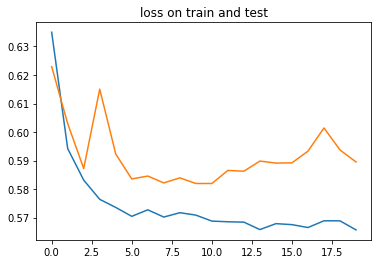

Last loss on train: 0.5657043106260553
Last loss on test: 0.5895105882694847


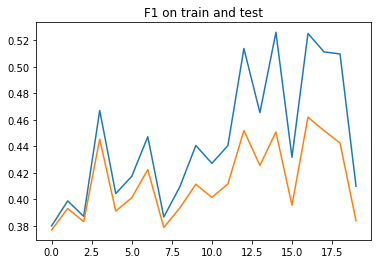

Last F1 on train: 0.4099864445428933
Last F1 on test: 0.3839264645388252


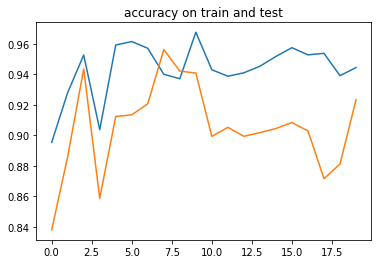

Last accuracy on train: 0.9444704787657324
Last accuracy on test: 0.9234097180397887


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.6453705625908241


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

tja-O ,-O keine-B ahnung-I .-O
--O ich-B bin-I dabei-I .-O
ich-B denke-I schon-I .-O
du-B hast-I recht-I .-O
da-B hast-I du-I recht-I .-O
ja-O ,-O gute-B idee-I .-O
--O aber-B natürlich-I .-O
keine-B ahnung-I .-O
schon-B gut-I .-O
du-B hast-I recht-I .-O
--O keine-B ahnung-I .-O
das-B stimmt-I .-O
--O auf-B keinen-I fall-I .-O
na-B gut-I ,-O mein-O schatz-O .-O
schon-B gut-I .-O
na-B gut-I ,-O kommt-O ,-O 2-O gegen-O einen-O .-O
--O hör-B auf-I .-O
ich-B weiß-I ,-O aber-O die-O neue-O wohnung-O ist-O nun-O wirklich-O groß-O genug-O und-O ...-O
lhr-O kennt-O doch-O meinen-O vater-O ,-O stimmt-B 's-I ?-O
--O ist-B schon-I gut-I .-O
hör-B auf-I !-O
--O na-B klar-I .-O
na-B gut-I ,-O äh-O ,-O wir-O sehen-O uns-O dann-O nachher-O .-O
--O ganz-B genau-I .-O
--O na-B klar-I .-O
ich-O brauch-O keine-O ,-O stimmt-B 's-I ?-O
--O so-O eine-O art-O ,-O ich-B weiß-I schon-I .-O
also-B gut-I .-O
--O ganz-B und-I gar-I nicht-I .-O
--O du-B hast-I recht-I .-O
ja-O ,-O ich-B verstehe-I .-O
ich-B verste

# Experiment 5, testing bi-directional 2 Cells

* RNN
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation

## Training

In [ ]:
model = BiRNN_2Cells(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


48it [00:02, 22.25it/s]

Train loss: 0.7159965753555297


93it [00:04, 24.79it/s]

Train loss: 0.681977266073227


139it [00:05, 25.09it/s]

Train loss: 0.6578214817576938


184it [00:07, 23.51it/s]

Train loss: 0.6454545057482189


226it [00:09, 24.04it/s]


Train loss: 0.6387337480651007

Evaluating on train...


48it [00:01, 25.24it/s]

Val loss: 0.5901827229393853, Val f1: 0.36497622662120394, Val accuracy: 0.9212738904688094


93it [00:03, 24.46it/s]

Val loss: 0.5917155279053582, Val f1: 0.3713013655609555, Val accuracy: 0.9249684953027302


139it [00:04, 37.77it/s]

Val loss: 0.5905775935561569, Val f1: 0.36979850022881117, Val accuracy: 0.9176227830074452


184it [00:05, 37.93it/s]

Val loss: 0.5898410866657893, Val f1: 0.36824853122234347, Val accuracy: 0.9142383414838049


226it [00:07, 32.19it/s]


Val loss: 0.5921897975603739, Val f1: 0.36935985657903886, Val accuracy: 0.9128778896066878

Evaluating on test...


20it [00:00, 37.59it/s]

Val loss: 0.6329646031061809, Val f1: 0.3630858282248179, Val accuracy: 0.8837529818216959


36it [00:00, 38.17it/s]

Val loss: 0.6204384525616964, Val f1: 0.3671204219261805, Val accuracy: 0.8914785067240397


49it [00:01, 39.03it/s]

Val loss: 0.6124381727642483, Val f1: 0.36745254397392274, Val accuracy: 0.908732455306583


66it [00:01, 37.32it/s]

Val loss: 0.6098526020844778, Val f1: 0.3671642442544301, Val accuracy: 0.9142443895339966


76it [00:02, 37.88it/s]


Val loss: 0.6114303024609884, Val f1: 0.36690814097722374, Val accuracy: 0.9138715799649556

starting Epoch 1
Training...


49it [00:01, 36.51it/s]

Train loss: 0.594441470834944


94it [00:02, 36.62it/s]

Train loss: 0.589321004682117


142it [00:03, 36.44it/s]

Train loss: 0.5873086567278262


186it [00:05, 37.29it/s]

Train loss: 0.5887301269504759


226it [00:06, 35.88it/s]


Train loss: 0.5891611817147997

Evaluating on train...


50it [00:01, 44.46it/s]

Val loss: 0.5804134832488166, Val f1: 0.3931083818276723, Val accuracy: 0.9251557939582401


95it [00:02, 43.28it/s]

Val loss: 0.5797942737738292, Val f1: 0.39184504316912755, Val accuracy: 0.9387126545111338


140it [00:03, 43.07it/s]

Val loss: 0.5791813408886944, Val f1: 0.3922470390796661, Val accuracy: 0.9484446556479843


185it [00:04, 40.55it/s]

Val loss: 0.5785579598612256, Val f1: 0.3920228110419379, Val accuracy: 0.9438672160108884


226it [00:05, 41.97it/s]


Val loss: 0.5773779673046536, Val f1: 0.39256276342603896, Val accuracy: 0.9449149664243063

Evaluating on test...


21it [00:00, 37.49it/s]

Val loss: 0.5876050194104513, Val f1: 0.3862257341543833, Val accuracy: 0.9231892983118694


35it [00:00, 39.25it/s]

Val loss: 0.5977315763632457, Val f1: 0.3857127825419108, Val accuracy: 0.8920289119084676


51it [00:01, 38.57it/s]

Val loss: 0.5959911730554369, Val f1: 0.3896618121200138, Val accuracy: 0.9056289699342516


64it [00:01, 38.96it/s]

Val loss: 0.5970511943101883, Val f1: 0.38976672490437825, Val accuracy: 0.9123590817054112


76it [00:01, 38.80it/s]


Val loss: 0.5969807473818461, Val f1: 0.38717082142829895, Val accuracy: 0.9057871552308401

starting Epoch 2
Training...


49it [00:02, 22.38it/s]

Train loss: 0.5800750666194492


94it [00:03, 25.35it/s]

Train loss: 0.5843404372533162


139it [00:05, 25.81it/s]

Train loss: 0.5842652956644694


183it [00:07, 24.93it/s]

Train loss: 0.5809684743483862


226it [00:09, 22.78it/s]


Train loss: 0.5794748218854269

Evaluating on train...


49it [00:01, 26.61it/s]

Val loss: 0.571597711245219, Val f1: 0.39818942017025416, Val accuracy: 0.9356640974680582


95it [00:03, 26.37it/s]

Val loss: 0.5724549366368188, Val f1: 0.40246150626076593, Val accuracy: 0.9560989949438307


139it [00:05, 24.04it/s]

Val loss: 0.5756800792835377, Val f1: 0.3997621662086911, Val accuracy: 0.9538188581113463


184it [00:07, 24.65it/s]

Val loss: 0.5766471829679277, Val f1: 0.3980426033337911, Val accuracy: 0.9445085164573458


226it [00:08, 25.83it/s]


Val loss: 0.5763472488191392, Val f1: 0.39940759499867756, Val accuracy: 0.9502050370640225

Evaluating on test...


18it [00:00, 26.02it/s]

Val loss: 0.5817369023958842, Val f1: 0.3915888408819834, Val accuracy: 0.8686723311742147


33it [00:01, 24.92it/s]

Val loss: 0.5973089853922526, Val f1: 0.3998482624689738, Val accuracy: 0.882251912355423


48it [00:01, 25.88it/s]

Val loss: 0.6024901774194505, Val f1: 0.39008386201328704, Val accuracy: 0.840383607811398


63it [00:02, 25.80it/s]

Val loss: 0.5971252848704656, Val f1: 0.3898776426911354, Val accuracy: 0.8711728682120641


76it [00:02, 26.03it/s]


Val loss: 0.5982838972409567, Val f1: 0.3908121983210246, Val accuracy: 0.8584949239095052

starting Epoch 3
Training...


52it [00:01, 35.26it/s]

Train loss: 0.5720107184516059


96it [00:03, 36.98it/s]

Train loss: 0.571823752588696


141it [00:04, 36.13it/s]

Train loss: 0.5733191896367956


186it [00:06, 35.67it/s]

Train loss: 0.5718230648173226


226it [00:07, 31.70it/s]


Train loss: 0.5743798968527052

Evaluating on train...


50it [00:01, 45.30it/s]

Val loss: 0.565468160311381, Val f1: 0.49008885423342385, Val accuracy: 0.9655073251989152


95it [00:02, 42.30it/s]

Val loss: 0.5732251822948455, Val f1: 0.4781953036785126, Val accuracy: 0.9330095042785008


140it [00:03, 39.79it/s]

Val loss: 0.5711815745742232, Val f1: 0.4821754005220201, Val accuracy: 0.9441490232944488


188it [00:04, 39.70it/s]

Val loss: 0.5713343063990275, Val f1: 0.48184115671449235, Val accuracy: 0.949967413312859


226it [00:05, 41.20it/s]


Val loss: 0.5705705748664008, Val f1: 0.47757848660151164, Val accuracy: 0.9440741646289825

Evaluating on test...


20it [00:00, 38.27it/s]

Val loss: 0.5785821437835693, Val f1: 0.47007790207862854, Val accuracy: 0.8990887006123861


37it [00:00, 38.99it/s]

Val loss: 0.5798493802547455, Val f1: 0.46643623113632204, Val accuracy: 0.907153527935346


49it [00:01, 37.03it/s]

Val loss: 0.5857851081424289, Val f1: 0.45131138894293044, Val accuracy: 0.9022171874841054


65it [00:01, 35.84it/s]

Val loss: 0.5909707287947337, Val f1: 0.4559630314509074, Val accuracy: 0.9035473838448524


76it [00:02, 37.66it/s]


Val loss: 0.5917910321553548, Val f1: 0.4591648205121358, Val accuracy: 0.908050597111384

starting Epoch 4
Training...


50it [00:01, 38.19it/s]

Train loss: 0.5731577078501383


94it [00:02, 37.01it/s]

Train loss: 0.5744374904367658


139it [00:03, 36.34it/s]

Train loss: 0.573844912317064


184it [00:05, 21.54it/s]

Train loss: 0.5750654485490587


226it [00:07, 29.91it/s]


Train loss: 0.5745008752081129

Evaluating on train...


48it [00:01, 26.27it/s]

Val loss: 0.567601756254832, Val f1: 0.4981325619750553, Val accuracy: 0.9653212600284152


93it [00:03, 25.48it/s]

Val loss: 0.5720347238911523, Val f1: 0.5026532974508073, Val accuracy: 0.9635875609185961


138it [00:05, 26.34it/s]

Val loss: 0.567867041517187, Val f1: 0.501384460705298, Val accuracy: 0.957799960286529


183it [00:07, 25.21it/s]

Val loss: 0.5668958624204, Val f1: 0.496743374897374, Val accuracy: 0.9509779961572753


226it [00:08, 27.24it/s]


Val loss: 0.5680370744069417, Val f1: 0.4905571214358012, Val accuracy: 0.9403923250569237

Evaluating on test...


17it [00:00, 17.20it/s]

Val loss: 0.6081648627916972, Val f1: 0.4431785007317861, Val accuracy: 0.8591995358467102


31it [00:01, 19.28it/s]

Val loss: 0.5917201777299245, Val f1: 0.4472417136033376, Val accuracy: 0.9015876491864522


47it [00:02, 17.01it/s]

Val loss: 0.5911363230811225, Val f1: 0.4584357950422499, Val accuracy: 0.8990084840191735


67it [00:03, 29.55it/s]

Val loss: 0.5953766763210296, Val f1: 0.4654420172174772, Val accuracy: 0.8979720368981361


76it [00:03, 19.56it/s]


Val loss: 0.5936442828178405, Val f1: 0.4621873954931895, Val accuracy: 0.8993725009759267

starting Epoch 5
Training...


50it [00:02, 23.58it/s]

Train loss: 0.5699338144726224


95it [00:04, 24.05it/s]

Train loss: 0.5742039567894406


140it [00:06, 24.73it/s]

Train loss: 0.5706612423614219


182it [00:07, 22.79it/s]

Train loss: 0.5724140279822879


226it [00:09, 22.98it/s]


Train loss: 0.5728749105665418

Evaluating on train...


50it [00:01, 39.43it/s]

Val loss: 0.5633215573098924, Val f1: 0.40874183177948, Val accuracy: 0.9781190660264757


94it [00:02, 39.57it/s]

Val loss: 0.568346764643987, Val f1: 0.4084241678317388, Val accuracy: 0.9646752619081074


140it [00:04, 39.15it/s]

Val loss: 0.5711599703188296, Val f1: 0.4086833024466479, Val accuracy: 0.9429148499612455


186it [00:05, 37.76it/s]

Val loss: 0.5694306906726625, Val f1: 0.40854430943727493, Val accuracy: 0.9547809728317791


226it [00:06, 35.95it/s]


Val loss: 0.5688941878742642, Val f1: 0.4108610549237993, Val accuracy: 0.9580936480893029

Evaluating on test...


22it [00:00, 39.13it/s]

Val loss: 0.59251975218455, Val f1: 0.40005191961924236, Val accuracy: 0.903805406888326


34it [00:00, 36.74it/s]

Val loss: 0.5933865586916606, Val f1: 0.39349034825960794, Val accuracy: 0.8885894308487574


50it [00:01, 38.74it/s]

Val loss: 0.5926958918571472, Val f1: 0.4035432928138309, Val accuracy: 0.9096819195482466


67it [00:01, 38.61it/s]

Val loss: 0.5886907587448756, Val f1: 0.39761524001757304, Val accuracy: 0.9232716992497444


76it [00:01, 38.65it/s]


Val loss: 0.5863740372657776, Val f1: 0.3961148945490519, Val accuracy: 0.8969710469245911

starting Epoch 6
Training...


50it [00:01, 37.00it/s]

Train loss: 0.5710900108019511


93it [00:03, 24.54it/s]

Train loss: 0.5680524435308244


138it [00:05, 25.46it/s]

Train loss: 0.5709424826833936


183it [00:06, 26.01it/s]

Train loss: 0.5711518969800737


226it [00:08, 26.44it/s]


Train loss: 0.5719525167677137

Evaluating on train...


48it [00:01, 26.75it/s]

Val loss: 0.5658456630176968, Val f1: 0.40385684967041013, Val accuracy: 0.9422320889102088


93it [00:03, 26.10it/s]

Val loss: 0.5699645121892293, Val f1: 0.41135723027918075, Val accuracy: 0.9454285035530726


142it [00:05, 35.10it/s]

Val loss: 0.5700040733372723, Val f1: 0.41476224572570236, Val accuracy: 0.955761123807342


184it [00:06, 40.02it/s]

Val loss: 0.5697889139254888, Val f1: 0.41533388843139013, Val accuracy: 0.9510088120897611


226it [00:07, 31.25it/s]


Val loss: 0.5679537153244019, Val f1: 0.42046604818767974, Val accuracy: 0.9566003898779551

Evaluating on test...


18it [00:00, 40.10it/s]

Val loss: 0.6019739468892416, Val f1: 0.40289894143740335, Val accuracy: 0.8756357292334239


33it [00:00, 40.68it/s]

Val loss: 0.5906405210494995, Val f1: 0.4039370059967041, Val accuracy: 0.9237740486860275


53it [00:01, 39.90it/s]

Val loss: 0.5862229983011882, Val f1: 0.40330438017845155, Val accuracy: 0.9401537557442983


67it [00:01, 39.02it/s]

Val loss: 0.5872279832760493, Val f1: 0.40328373908996584, Val accuracy: 0.9317596470316251


76it [00:01, 39.93it/s]


Val loss: 0.584769941965739, Val f1: 0.40527883330980935, Val accuracy: 0.9388877991835276

starting Epoch 7
Training...


49it [00:01, 37.55it/s]

Train loss: 0.5654403911696539


97it [00:02, 37.53it/s]

Train loss: 0.5693575819333394


141it [00:03, 35.59it/s]

Train loss: 0.5713080768231993


185it [00:05, 36.47it/s]

Train loss: 0.571591329243448


226it [00:06, 35.87it/s]


Train loss: 0.5708794723616706

Evaluating on train...


50it [00:01, 47.73it/s]

Val loss: 0.5675588726997376, Val f1: 0.5160254697004955, Val accuracy: 0.9652921319007873


96it [00:02, 43.25it/s]

Val loss: 0.5672567877504561, Val f1: 0.5034944428337945, Val accuracy: 0.9529941711160872


141it [00:03, 43.47it/s]

Val loss: 0.5651102136682581, Val f1: 0.49279518370275144, Val accuracy: 0.9510189864370558


186it [00:04, 41.65it/s]

Val loss: 0.5668923480643167, Val f1: 0.4949384546942181, Val accuracy: 0.9478711484207047


226it [00:05, 42.82it/s]


Val loss: 0.5676653117603726, Val f1: 0.4992125556204054, Val accuracy: 0.9495695755216811

Evaluating on test...


21it [00:00, 38.84it/s]

Val loss: 0.594055954615275, Val f1: 0.46987269520759584, Val accuracy: 0.9013711194197337


34it [00:00, 39.30it/s]

Val loss: 0.5930948535601298, Val f1: 0.4488891035318375, Val accuracy: 0.877874106168747


49it [00:01, 40.11it/s]

Val loss: 0.5939919590950012, Val f1: 0.45736080673005847, Val accuracy: 0.8847885211308797


67it [00:01, 38.54it/s]

Val loss: 0.5967022915681203, Val f1: 0.4547378197312355, Val accuracy: 0.8735238522291183


76it [00:01, 39.19it/s]


Val loss: 0.5947014983495077, Val f1: 0.4539232722918193, Val accuracy: 0.8798440408706665

starting Epoch 8
Training...


49it [00:01, 35.00it/s]

Train loss: 0.5692312823401557


97it [00:02, 36.99it/s]

Train loss: 0.5686285184489356


141it [00:03, 36.55it/s]

Train loss: 0.5692575843245895


185it [00:05, 37.05it/s]

Train loss: 0.5704182303614087


226it [00:06, 35.85it/s]


Train loss: 0.5707224085595872

Evaluating on train...


50it [00:01, 41.85it/s]

Val loss: 0.5705556498633491, Val f1: 0.4397823777463701, Val accuracy: 0.9335797627766927


95it [00:02, 41.73it/s]

Val loss: 0.570274156332016, Val f1: 0.4505265514055888, Val accuracy: 0.9517707334624397


140it [00:03, 40.47it/s]

Val loss: 0.5681560463375516, Val f1: 0.45408653307844093, Val accuracy: 0.9540244067156757


183it [00:04, 37.93it/s]

Val loss: 0.5672921839687559, Val f1: 0.45287154995732837, Val accuracy: 0.9436088118288252


226it [00:05, 40.84it/s]


Val loss: 0.5658477867974175, Val f1: 0.45573114090495637, Val accuracy: 0.950075491534339

Evaluating on test...


20it [00:00, 38.59it/s]

Val loss: 0.5881634791692097, Val f1: 0.43584814071655276, Val accuracy: 0.9385577281316121


36it [00:00, 38.65it/s]

Val loss: 0.58827143907547, Val f1: 0.42646244664986926, Val accuracy: 0.9396613359451294


49it [00:01, 38.49it/s]

Val loss: 0.5851604567633735, Val f1: 0.42782612906561956, Val accuracy: 0.9462269597583347


66it [00:01, 38.75it/s]

Val loss: 0.5897866040468216, Val f1: 0.42995303918917976, Val accuracy: 0.9297327056527138


76it [00:01, 38.44it/s]


Val loss: 0.58994921763738, Val f1: 0.42521742701530457, Val accuracy: 0.912066832780838

starting Epoch 9
Training...


49it [00:01, 35.15it/s]

Train loss: 0.5618164406882392


97it [00:02, 36.39it/s]

Train loss: 0.5626033544540405


141it [00:04, 36.82it/s]

Train loss: 0.5639282045540986


185it [00:05, 35.20it/s]

Train loss: 0.5673090911573834


226it [00:06, 35.51it/s]


Train loss: 0.566001816060808

Evaluating on train...


50it [00:01, 45.44it/s]

Val loss: 0.5640480015012953, Val f1: 0.541989247004191, Val accuracy: 0.937530501683553


95it [00:02, 41.53it/s]

Val loss: 0.5667342795266046, Val f1: 0.5473517169555028, Val accuracy: 0.9393708768818113


140it [00:03, 40.93it/s]

Val loss: 0.5691111997321799, Val f1: 0.5525171573515292, Val accuracy: 0.9336449525974415


183it [00:04, 25.65it/s]

Val loss: 0.56696701016691, Val f1: 0.5586900977624787, Val accuracy: 0.9361912272042698


226it [00:05, 38.63it/s]


Val loss: 0.5691498038503858, Val f1: 0.5640366045633952, Val accuracy: 0.9347717934184604

Evaluating on test...


20it [00:00, 38.39it/s]

Val loss: 0.6023484786351522, Val f1: 0.5369608660538991, Val accuracy: 0.9005465865135193


37it [00:00, 38.46it/s]

Val loss: 0.6074924468994141, Val f1: 0.5134805391232172, Val accuracy: 0.8906249503294627


49it [00:01, 38.72it/s]

Val loss: 0.6048935068978204, Val f1: 0.5242627435260349, Val accuracy: 0.8826758517159357


67it [00:01, 39.30it/s]

Val loss: 0.5971357017755509, Val f1: 0.513534373541673, Val accuracy: 0.8759730810920398


76it [00:01, 38.48it/s]


Val loss: 0.5957493837674459, Val f1: 0.5085678072770436, Val accuracy: 0.8880819269021352

starting Epoch 10
Training...


49it [00:01, 36.67it/s]

Train loss: 0.5707608275943332


94it [00:02, 36.53it/s]

Train loss: 0.5665481885274252


142it [00:04, 36.34it/s]

Train loss: 0.5678323136435615


186it [00:05, 35.57it/s]

Train loss: 0.5717229260338678


226it [00:06, 35.53it/s]


Train loss: 0.5722418287065294

Evaluating on train...


50it [00:01, 45.48it/s]

Val loss: 0.56277457608117, Val f1: 0.46141707830958895, Val accuracy: 0.943532747692532


95it [00:02, 42.57it/s]

Val loss: 0.5630654884709252, Val f1: 0.46318851543797385, Val accuracy: 0.957921044031779


140it [00:03, 41.04it/s]

Val loss: 0.5641270853854992, Val f1: 0.459630705471392, Val accuracy: 0.9413806131592504


185it [00:04, 39.99it/s]

Val loss: 0.5648614509238137, Val f1: 0.46087016099029116, Val accuracy: 0.9450466255346934


226it [00:05, 41.93it/s]


Val loss: 0.5664178776741028, Val f1: 0.46236659990416634, Val accuracy: 0.944797242614958

Evaluating on test...


21it [00:00, 38.28it/s]

Val loss: 0.5952586650848388, Val f1: 0.43593037525812783, Val accuracy: 0.8962863087654114


37it [00:00, 39.11it/s]

Val loss: 0.5934042513370514, Val f1: 0.43371325731277466, Val accuracy: 0.9170091966787974


50it [00:01, 39.27it/s]

Val loss: 0.5942980183495415, Val f1: 0.42653441031773887, Val accuracy: 0.9243937147988214


66it [00:01, 37.83it/s]

Val loss: 0.5914972623189291, Val f1: 0.42948278139034907, Val accuracy: 0.9308472375075022


76it [00:01, 38.48it/s]


Val loss: 0.5909306764602661, Val f1: 0.427058828274409, Val accuracy: 0.9296825059254964

starting Epoch 11
Training...


49it [00:01, 35.83it/s]

Train loss: 0.5693516307406955


94it [00:02, 34.53it/s]

Train loss: 0.5699386762248145


142it [00:04, 35.62it/s]

Train loss: 0.5669697108092131


186it [00:05, 36.31it/s]

Train loss: 0.567789242333836


226it [00:06, 35.37it/s]


Train loss: 0.5676596596505907

Evaluating on train...


50it [00:01, 45.91it/s]

Val loss: 0.563801998562283, Val f1: 0.5062132855256398, Val accuracy: 0.9827600399653117


95it [00:02, 40.72it/s]

Val loss: 0.5654792010784149, Val f1: 0.4990227023760478, Val accuracy: 0.9497346288628048


140it [00:03, 39.75it/s]

Val loss: 0.5642196050396672, Val f1: 0.49624180528852674, Val accuracy: 0.9464044650395711


187it [00:04, 38.30it/s]

Val loss: 0.5633789012829463, Val f1: 0.5017214503553179, Val accuracy: 0.9461444528566466


226it [00:05, 40.75it/s]


Val loss: 0.565094255871243, Val f1: 0.5000817954540253, Val accuracy: 0.9407006710105472

Evaluating on test...


21it [00:00, 39.10it/s]

Val loss: 0.5973066528638203, Val f1: 0.4420546213785807, Val accuracy: 0.8260780016581217


37it [00:00, 37.03it/s]

Val loss: 0.60405961672465, Val f1: 0.4417421112457911, Val accuracy: 0.8642159442106883


50it [00:01, 36.98it/s]

Val loss: 0.6011423495080735, Val f1: 0.4466423061158922, Val accuracy: 0.8828833487298754


66it [00:01, 37.25it/s]

Val loss: 0.5951190034548441, Val f1: 0.44005924959977466, Val accuracy: 0.8877385725577672


76it [00:02, 37.92it/s]


Val loss: 0.5914659651120504, Val f1: 0.4425425394376119, Val accuracy: 0.9036525869369507

starting Epoch 12
Training...


49it [00:01, 36.53it/s]

Train loss: 0.5568716949886746


97it [00:02, 36.07it/s]

Train loss: 0.5614564067787594


141it [00:04, 37.03it/s]

Train loss: 0.5645038962364197


185it [00:05, 35.37it/s]

Train loss: 0.5666977352566189


226it [00:06, 35.46it/s]


Train loss: 0.5664163282182482

Evaluating on train...


53it [00:01, 29.36it/s]

Val loss: 0.5719178610377842, Val f1: 0.38340766959720185, Val accuracy: 0.9558061242103577


97it [00:02, 39.82it/s]

Val loss: 0.5775054070684645, Val f1: 0.38154994116889107, Val accuracy: 0.9203429440657298


140it [00:03, 39.66it/s]

Val loss: 0.5745721989207797, Val f1: 0.3829336901505788, Val accuracy: 0.9288867436073445


187it [00:04, 38.65it/s]

Val loss: 0.5748061226473914, Val f1: 0.38463645974795024, Val accuracy: 0.9413234291805161


226it [00:05, 37.78it/s]


Val loss: 0.57332906987932, Val f1: 0.3859953678978814, Val accuracy: 0.938944556845559

Evaluating on test...


20it [00:00, 37.69it/s]

Val loss: 0.5846507986386617, Val f1: 0.3709475815296173, Val accuracy: 0.9653273542722066


36it [00:00, 35.83it/s]

Val loss: 0.5928669730822246, Val f1: 0.3727452129125595, Val accuracy: 0.9379014452298482


52it [00:01, 37.45it/s]

Val loss: 0.5914964225557116, Val f1: 0.37330672211117216, Val accuracy: 0.9456741650899251


64it [00:01, 37.33it/s]

Val loss: 0.5928090214729309, Val f1: 0.37036482195059456, Val accuracy: 0.943369432290395


76it [00:02, 37.32it/s]


Val loss: 0.5920084770520528, Val f1: 0.37092950582504275, Val accuracy: 0.9391394444306691

starting Epoch 13
Training...


49it [00:01, 35.70it/s]

Train loss: 0.5643913918071323


93it [00:02, 36.81it/s]

Train loss: 0.5653738266891903


141it [00:04, 36.51it/s]

Train loss: 0.5668352674554895


185it [00:05, 36.15it/s]

Train loss: 0.5679222146670023


226it [00:06, 35.22it/s]


Train loss: 0.5678211866484748

Evaluating on train...


50it [00:01, 46.74it/s]

Val loss: 0.5677014390627543, Val f1: 0.4222829600175222, Val accuracy: 0.9659915950563219


95it [00:02, 44.64it/s]

Val loss: 0.5654151585366991, Val f1: 0.4214966850148307, Val accuracy: 0.9784046471118927


140it [00:03, 41.50it/s]

Val loss: 0.5663808827046994, Val f1: 0.4155877128795341, Val accuracy: 0.9668519647033126


185it [00:04, 41.64it/s]

Val loss: 0.5672921889358097, Val f1: 0.4183675178223186, Val accuracy: 0.9629505972067515


226it [00:05, 42.73it/s]


Val loss: 0.5673258278104995, Val f1: 0.41559266421529983, Val accuracy: 0.9577297258377075

Evaluating on test...


20it [00:00, 37.89it/s]

Val loss: 0.5939735968907675, Val f1: 0.3926619589328766, Val accuracy: 0.9430255889892578


34it [00:00, 39.61it/s]

Val loss: 0.5823760608832041, Val f1: 0.3899006803830465, Val accuracy: 0.9427389363447826


52it [00:01, 39.58it/s]

Val loss: 0.593277985519833, Val f1: 0.3865516159269545, Val accuracy: 0.9307610445552402


65it [00:01, 39.69it/s]

Val loss: 0.5929416328668594, Val f1: 0.3876406411329905, Val accuracy: 0.9330173810323079


76it [00:01, 38.90it/s]


Val loss: 0.5898358066876729, Val f1: 0.3894427998860677, Val accuracy: 0.9395611476898194

starting Epoch 14
Training...


49it [00:01, 36.52it/s]

Train loss: 0.5650143265724182


97it [00:02, 36.53it/s]

Train loss: 0.5664211365911695


141it [00:03, 37.40it/s]

Train loss: 0.5691023221722356


187it [00:05, 37.05it/s]

Train loss: 0.569387784269121


226it [00:06, 36.07it/s]


Train loss: 0.569861138926612

Evaluating on train...


50it [00:01, 47.92it/s]

Val loss: 0.5688215984238518, Val f1: 0.43894137541453043, Val accuracy: 0.9660112573040857


95it [00:02, 40.22it/s]

Val loss: 0.5669060150782267, Val f1: 0.4461488985353046, Val accuracy: 0.9670536869102054


142it [00:03, 38.67it/s]

Val loss: 0.566298661408601, Val f1: 0.44619176299483687, Val accuracy: 0.9628751816572967


187it [00:04, 39.12it/s]

Val loss: 0.5667565481530296, Val f1: 0.44664400104019375, Val accuracy: 0.9587737792068057


226it [00:05, 41.32it/s]


Val loss: 0.566058808962504, Val f1: 0.4433380801147885, Val accuracy: 0.9551462973488701

Evaluating on test...


19it [00:00, 40.03it/s]

Val loss: 0.5849374890327453, Val f1: 0.39708611170450847, Val accuracy: 0.959599765141805


34it [00:00, 40.39it/s]

Val loss: 0.5907811164855957, Val f1: 0.3955514907836914, Val accuracy: 0.9308525303999583


53it [00:01, 40.15it/s]

Val loss: 0.586390569474962, Val f1: 0.40011263291041055, Val accuracy: 0.9280409044689603


68it [00:01, 40.00it/s]

Val loss: 0.5889882713556289, Val f1: 0.4034076198935509, Val accuracy: 0.9310299038887024


76it [00:01, 39.88it/s]


Val loss: 0.587485335667928, Val f1: 0.4010604707400004, Val accuracy: 0.9242906451225281

starting Epoch 15
Training...


50it [00:01, 37.05it/s]

Train loss: 0.5679056445757548


94it [00:02, 37.36it/s]

Train loss: 0.5702464706367917


142it [00:04, 36.17it/s]

Train loss: 0.5694607540413186


186it [00:05, 35.59it/s]

Train loss: 0.5678414112991756


226it [00:06, 35.79it/s]


Train loss: 0.5678764594925775

Evaluating on train...


51it [00:01, 46.53it/s]

Val loss: 0.5675173507796394, Val f1: 0.5123014940155877, Val accuracy: 0.9303881876998478


96it [00:02, 43.42it/s]

Val loss: 0.5644796583387587, Val f1: 0.5192444427145853, Val accuracy: 0.9355266855822669


141it [00:03, 42.56it/s]

Val loss: 0.5649049321810404, Val f1: 0.5178546883441784, Val accuracy: 0.9414295571821707


186it [00:04, 41.92it/s]

Val loss: 0.5660074787007437, Val f1: 0.5185495873292287, Val accuracy: 0.9426289248797629


226it [00:05, 42.91it/s]


Val loss: 0.5652521573172675, Val f1: 0.5142269551753997, Val accuracy: 0.9421034048663245

Evaluating on test...


21it [00:00, 39.39it/s]

Val loss: 0.5890708168347677, Val f1: 0.4260819713274638, Val accuracy: 0.8525257150332133


37it [00:00, 37.04it/s]

Val loss: 0.5877304097016652, Val f1: 0.4442783792813619, Val accuracy: 0.8980957945187886


49it [00:01, 37.98it/s]

Val loss: 0.591643856631385, Val f1: 0.4449149277475145, Val accuracy: 0.8860769046677484


65it [00:01, 37.81it/s]

Val loss: 0.5878601332505544, Val f1: 0.4455565497279167, Val accuracy: 0.8729723155498504


76it [00:01, 38.29it/s]


Val loss: 0.586815132300059, Val f1: 0.4419047812620799, Val accuracy: 0.8721719026565552

starting Epoch 16
Training...


51it [00:01, 33.82it/s]

Train loss: 0.5620423475901286


96it [00:02, 37.80it/s]

Train loss: 0.5629091123739879


140it [00:03, 35.51it/s]

Train loss: 0.5692587486019841


185it [00:05, 28.83it/s]

Train loss: 0.5667797810501523


226it [00:06, 33.66it/s]


Train loss: 0.5672373231252035

Evaluating on train...


50it [00:01, 46.48it/s]

Val loss: 0.5670786513222589, Val f1: 0.4968374689420064, Val accuracy: 0.9600372433662414


95it [00:02, 44.32it/s]

Val loss: 0.5701829135417938, Val f1: 0.5012513680590523, Val accuracy: 0.9385621011257171


140it [00:03, 41.92it/s]

Val loss: 0.5667857889775877, Val f1: 0.5027066343360477, Val accuracy: 0.9506697548760308


184it [00:04, 38.35it/s]

Val loss: 0.5668462273147371, Val f1: 0.49910369829999074, Val accuracy: 0.9451733753085136


226it [00:05, 42.26it/s]


Val loss: 0.5670862968762715, Val f1: 0.500546911822425, Val accuracy: 0.9453420617845323

Evaluating on test...


22it [00:00, 39.63it/s]

Val loss: 0.5727147738138835, Val f1: 0.43825199206670123, Val accuracy: 0.9194271504878998


34it [00:00, 39.15it/s]

Val loss: 0.5809545735518138, Val f1: 0.4460397273302078, Val accuracy: 0.9271070828040441


52it [00:01, 39.50it/s]

Val loss: 0.5913227081298829, Val f1: 0.4369881225956811, Val accuracy: 0.8831638594468435


65it [00:01, 39.14it/s]

Val loss: 0.5950142025947571, Val f1: 0.43728165825208026, Val accuracy: 0.8842781359950701


76it [00:01, 38.99it/s]


Val loss: 0.5954489405949911, Val f1: 0.43539923906326294, Val accuracy: 0.8871852576732635

starting Epoch 17
Training...


52it [00:01, 37.46it/s]

Train loss: 0.5726063357459175


94it [00:02, 36.85it/s]

Train loss: 0.5660477340221405


139it [00:03, 37.38it/s]

Train loss: 0.5662440728258203


187it [00:05, 35.47it/s]

Train loss: 0.5689984132846196


226it [00:06, 35.90it/s]


Train loss: 0.5694482435120477

Evaluating on train...


50it [00:01, 46.62it/s]

Val loss: 0.5592026074727376, Val f1: 0.5127829498714871, Val accuracy: 0.9325896733336978


95it [00:02, 43.21it/s]

Val loss: 0.5621652954154545, Val f1: 0.5050446430842082, Val accuracy: 0.956816264324718


140it [00:03, 42.97it/s]

Val loss: 0.5623539708278797, Val f1: 0.49559483307379265, Val accuracy: 0.951338670651118


185it [00:04, 40.17it/s]

Val loss: 0.5627669245004654, Val f1: 0.4947890215449863, Val accuracy: 0.9446641847491264


226it [00:05, 42.92it/s]


Val loss: 0.5632782022158305, Val f1: 0.49268335064252217, Val accuracy: 0.9454641615019904

Evaluating on test...


20it [00:00, 38.54it/s]

Val loss: 0.5793571949005127, Val f1: 0.41008052229881287, Val accuracy: 0.9084614912668864


37it [00:00, 38.81it/s]

Val loss: 0.5827613194783529, Val f1: 0.4221355934937795, Val accuracy: 0.9263066569964091


50it [00:01, 39.34it/s]

Val loss: 0.5895232995351155, Val f1: 0.4331558810340034, Val accuracy: 0.9276191009415521


67it [00:01, 38.86it/s]

Val loss: 0.5889119456211726, Val f1: 0.4288292497396469, Val accuracy: 0.92913343111674


76it [00:01, 38.89it/s]


Val loss: 0.5885485998789469, Val f1: 0.42735923051834107, Val accuracy: 0.931053573290507

starting Epoch 18
Training...


50it [00:01, 37.94it/s]

Train loss: 0.5621170560518901


94it [00:02, 37.72it/s]

Train loss: 0.5664052029450735


142it [00:04, 35.40it/s]

Train loss: 0.5653848921811139


186it [00:05, 37.06it/s]

Train loss: 0.5663178761800131


226it [00:06, 35.62it/s]


Train loss: 0.5669854993290372

Evaluating on train...


50it [00:01, 47.22it/s]

Val loss: 0.5767078624831306, Val f1: 0.4053640968269772, Val accuracy: 0.9675509240892198


95it [00:02, 43.72it/s]

Val loss: 0.5726309597492218, Val f1: 0.4059967507918676, Val accuracy: 0.9742330352465312


140it [00:03, 41.72it/s]

Val loss: 0.5714130617954113, Val f1: 0.40544578035672507, Val accuracy: 0.9583125622184189


185it [00:04, 40.74it/s]

Val loss: 0.5695610559648938, Val f1: 0.40513059033287896, Val accuracy: 0.9664604978428947


226it [00:05, 42.35it/s]


Val loss: 0.568856721189287, Val f1: 0.4043954779042138, Val accuracy: 0.9678188505437639

Evaluating on test...


21it [00:00, 39.24it/s]

Val loss: 0.585503876209259, Val f1: 0.3833313842614492, Val accuracy: 0.9458698312441508


35it [00:00, 39.57it/s]

Val loss: 0.58868993918101, Val f1: 0.3792355676492055, Val accuracy: 0.9224427034457524


53it [00:01, 39.64it/s]

Val loss: 0.5927791568968032, Val f1: 0.37749720282024807, Val accuracy: 0.9264090942011939


67it [00:01, 39.77it/s]

Val loss: 0.5931687136491139, Val f1: 0.3789770384629568, Val accuracy: 0.9333952014644941


76it [00:01, 39.25it/s]


Val loss: 0.5907207791010539, Val f1: 0.3795307743549347, Val accuracy: 0.9316260627905528

starting Epoch 19
Training...


49it [00:01, 36.44it/s]

Train loss: 0.567732122209337


97it [00:02, 38.17it/s]

Train loss: 0.5664344754483964


141it [00:03, 37.58it/s]

Train loss: 0.5684333642323812


185it [00:05, 35.59it/s]

Train loss: 0.5681369579500622


226it [00:06, 35.96it/s]


Train loss: 0.5667712145381504

Evaluating on train...


51it [00:01, 47.41it/s]

Val loss: 0.5666134701834784, Val f1: 0.5157449278566573, Val accuracy: 0.9637148896853129


96it [00:02, 42.84it/s]

Val loss: 0.5630394385920631, Val f1: 0.5283772120873134, Val accuracy: 0.9531987700197432


141it [00:03, 41.35it/s]

Val loss: 0.5626274360550775, Val f1: 0.5300068418184917, Val accuracy: 0.9633281615045336


186it [00:04, 39.94it/s]

Val loss: 0.5640622794628143, Val f1: 0.536337201959557, Val accuracy: 0.9602465513679717


226it [00:05, 42.15it/s]


Val loss: 0.5634939421547783, Val f1: 0.5375039623843298, Val accuracy: 0.965684310860104

Evaluating on test...


20it [00:00, 40.39it/s]

Val loss: 0.6135077953338623, Val f1: 0.4561709364255269, Val accuracy: 0.8891869147618612


37it [00:00, 38.84it/s]

Val loss: 0.5936127702395121, Val f1: 0.45157057642936704, Val accuracy: 0.9301581740379333


51it [00:01, 39.81it/s]

Val loss: 0.5895295911365085, Val f1: 0.44628494845496286, Val accuracy: 0.932172507709927


67it [00:01, 38.20it/s]

Val loss: 0.5928055057923, Val f1: 0.4461350843310356, Val accuracy: 0.9134085014462471


76it [00:01, 39.36it/s]

Val loss: 0.5921765915552775, Val f1: 0.4458762900034587, Val accuracy: 0.9181217205524445


## Graphics

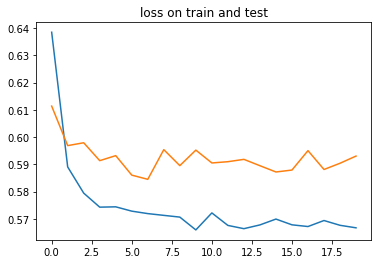

Last loss on train: 0.5667165979347398
Last loss on test: 0.5930369245378595


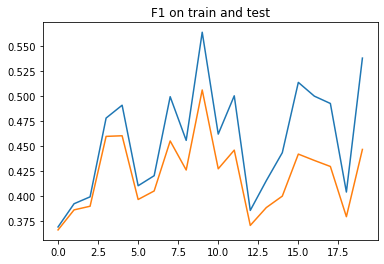

Last F1 on train: 0.5381210186576422
Last F1 on test: 0.44680543165457876


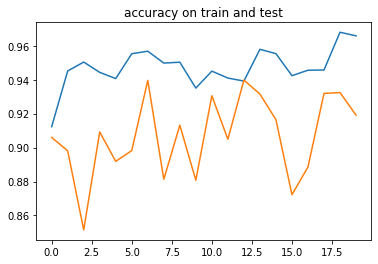

Last accuracy on train: 0.9658308390494996
Last accuracy on test: 0.9191275564463515


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8629852605356031


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

--O nicht-B wahr-I ?-O
mir-B auch-I recht-I .-O
du-B hast-I recht-I .-O
--O ich-B weiß-I .-O
aber-B so-I ist-I es-I eben-I .-O
sieht-B so-I aus-I .-O
das-B geht-I gar-I nicht-I .-O
keine-B ahnung-I .-O
es-B geht-I nicht-I .-O
keine-B ursache-I .-O
ich-B weiß-I !-O
--O machen-B sie-I witze-I ?-O
tja-O ,-O keine-B ahnung-I .-O
ja-O ,-O warum-B nicht-I ?-O
na-B und-I ?-O
--O so-B sei-I es-I !-O
--O ach-B ja-I ?-O
es-O sind-O ja-O nur-O kartons-O ,-O stimmt-B 's-I ?-O
aber-B natürlich-I .-O
keine-B ahnung-I .-O
machst-B du-I witze-I ?-O
keine-B ahnung-I .-O
nein-O ,-O ich-O will-O es-O nicht-O wissen-O ,-O auf-B gar-I keinen-I fall-I .-O
ist-B schon-I gut-I .-O
keine-B ahnung-I .-O
ich-O brauch-O keine-O ,-O stimmt-B 's-I ?-O
ja-O ,-O na-B und-I ?-O
--O keine-B ahnung-I .-O
gar-B nicht-I .-O
ich-B weiß-I .-O
--O kein-B problem-I .-O
nein-O ,-O das-B geht-I nicht-I .-O
na-B und-I ?-O
--O auf-B keinen-I fall-I .-O
--O hör-B auf-I .-O
ganz-B sicher-I nicht-I .-O
es-B geht-I nicht-I !-O
im-B e

# Experiment 6, testing embeddings

* RNN
* bi
* 2 cells
* 1 layer
* 1 sentence limitation
* 5 tokens limitation
* embeddings

## Training 

In [ ]:
model = BiRNN_2Cells_Embs(vocab_size=len(word2id), num_layers=1, embedding_dim=300, hidden_size=256, subject_num=3, weights=weights, DEVICE=DEVICE)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.001734, 1, 0.72])) 

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

optimizer = optim.RMSprop(model.parameters(), lr=0.005)

In [ ]:
f1 = F1Score(num_classes=3, average='macro').to(DEVICE)
accuracy = Accuracy(num_classes=3, average='macro').to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []
accuracies = []
accuracy_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    accuracy_on_train, f1_on_train, _ = evaluate(model, train_iterator, criterion, f1, accuracy)
    f1s.append(f1_on_train)
    accuracies.append(accuracy_on_train)
    print('\nEvaluating on test...')
    accuracy_on_test, f1_on_test, epoch_loss_on_test = evaluate(model, test_iterator, criterion, f1, accuracy)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)
    accuracy_eval.append(accuracy_on_test)


starting Epoch 0
Training...


48it [00:02, 22.52it/s]

Train loss: 0.8510141121016608


93it [00:04, 23.08it/s]

Train loss: 0.7858750111526913


138it [00:06, 23.90it/s]

Train loss: 0.7428476638264127


183it [00:08, 23.72it/s]

Train loss: 0.711838083797031


226it [00:09, 22.64it/s]


Train loss: 0.6910168584187826

Evaluating on train...


48it [00:01, 25.03it/s]

Val loss: 0.5971215923627218, Val f1: 0.3822115235858493, Val accuracy: 0.884665232234531


96it [00:03, 35.78it/s]

Val loss: 0.5941119352976482, Val f1: 0.3839760406149758, Val accuracy: 0.9031843271520402


140it [00:04, 30.53it/s]

Val loss: 0.591206161181132, Val f1: 0.3820099069012536, Val accuracy: 0.9000934106332285


184it [00:06, 22.70it/s]

Val loss: 0.590735787153244, Val f1: 0.3817481314142545, Val accuracy: 0.9031526709596316


226it [00:08, 27.81it/s]


Val loss: 0.5931623223092821, Val f1: 0.38178100956810845, Val accuracy: 0.9027683831585778

Evaluating on test...


18it [00:00, 24.09it/s]

Val loss: 0.6101571122805277, Val f1: 0.3815583209196726, Val accuracy: 0.9161699453989665


33it [00:01, 26.07it/s]

Val loss: 0.6216759463151296, Val f1: 0.380262503027916, Val accuracy: 0.8830709040164948


48it [00:01, 25.63it/s]

Val loss: 0.6160826086997986, Val f1: 0.3788907938533359, Val accuracy: 0.8982411901156108


63it [00:02, 25.79it/s]

Val loss: 0.6137717227141063, Val f1: 0.37834355533123015, Val accuracy: 0.8974986841281255


76it [00:02, 25.35it/s]


Val loss: 0.6137784544626872, Val f1: 0.3789104708035787, Val accuracy: 0.8983082453409831

starting Epoch 1
Training...


48it [00:02, 23.33it/s]

Train loss: 0.5869419733683269


93it [00:04, 24.61it/s]

Train loss: 0.5902184506257375


138it [00:05, 24.65it/s]

Train loss: 0.5909380828892743


183it [00:07, 23.68it/s]

Train loss: 0.591742045018408


226it [00:09, 24.79it/s]


Train loss: 0.5900806628333197

Evaluating on train...


50it [00:01, 43.22it/s]

Val loss: 0.58867939180798, Val f1: 0.4679645723766751, Val accuracy: 0.9060621400674184


95it [00:02, 40.81it/s]

Val loss: 0.5843964907858107, Val f1: 0.45852423310279844, Val accuracy: 0.9007299519247479


142it [00:03, 38.57it/s]

Val loss: 0.5834319547370628, Val f1: 0.4601079603036245, Val accuracy: 0.9016229603025648


182it [00:04, 37.63it/s]

Val loss: 0.5825314730405807, Val f1: 0.4623968851235178, Val accuracy: 0.9113679395781623


226it [00:07, 32.00it/s]


Val loss: 0.5845076272222731, Val f1: 0.4632436162895627, Val accuracy: 0.9109398378266229

Evaluating on test...


18it [00:00, 23.43it/s]

Val loss: 0.5922157843907674, Val f1: 0.46193413337071737, Val accuracy: 0.9212166865666708


33it [00:01, 24.29it/s]

Val loss: 0.6021041452884675, Val f1: 0.44932208259900414, Val accuracy: 0.8736978600422541


48it [00:01, 24.53it/s]

Val loss: 0.6115279833475749, Val f1: 0.4461461087067922, Val accuracy: 0.8600947108533648


63it [00:02, 25.03it/s]

Val loss: 0.6113596697648366, Val f1: 0.4450358922282855, Val accuracy: 0.8516443421443304


76it [00:03, 24.44it/s]


Val loss: 0.6159628009796143, Val f1: 0.4452964993317922, Val accuracy: 0.8420602281888326

starting Epoch 2
Training...


47it [00:02, 22.73it/s]

Train loss: 0.5846781333287557


92it [00:04, 22.57it/s]

Train loss: 0.5861981014410654


138it [00:06, 24.30it/s]

Train loss: 0.5826206030669036


183it [00:07, 23.96it/s]

Train loss: 0.5826432012849384


226it [00:09, 23.07it/s]


Train loss: 0.5810072461764018

Evaluating on train...


48it [00:01, 24.82it/s]

Val loss: 0.5766840961244372, Val f1: 0.42332243323326113, Val accuracy: 0.9523023049036662


95it [00:03, 29.62it/s]

Val loss: 0.5765349321895176, Val f1: 0.4220949477619595, Val accuracy: 0.9610666500197517


140it [00:05, 24.73it/s]

Val loss: 0.5776307547533953, Val f1: 0.4178441345691681, Val accuracy: 0.9447709416901624


182it [00:07, 24.95it/s]

Val loss: 0.5768152041567697, Val f1: 0.41997058043877283, Val accuracy: 0.9470893967482779


226it [00:08, 25.18it/s]


Val loss: 0.5753848173883226, Val f1: 0.42243425448735555, Val accuracy: 0.949302071068022

Evaluating on test...


18it [00:00, 25.59it/s]

Val loss: 0.5834014534950256, Val f1: 0.40805060267448423, Val accuracy: 0.8881957670052846


33it [00:01, 24.91it/s]

Val loss: 0.5940233667691549, Val f1: 0.40873473485310874, Val accuracy: 0.8436063488324483


48it [00:01, 24.06it/s]

Val loss: 0.5917937835057576, Val f1: 0.4073142866293589, Val accuracy: 0.876933315065172


64it [00:02, 27.83it/s]

Val loss: 0.5918455163637797, Val f1: 0.41006757269303, Val accuracy: 0.8920144865910212


76it [00:02, 25.49it/s]


Val loss: 0.5980013696352641, Val f1: 0.41117790738741555, Val accuracy: 0.8938027858734131

starting Epoch 3
Training...


48it [00:02, 23.78it/s]

Train loss: 0.583340256743961


93it [00:03, 24.64it/s]

Train loss: 0.5786372171507941


138it [00:06, 20.44it/s]

Train loss: 0.5788582015920568


184it [00:08, 23.54it/s]

Train loss: 0.5760143842962053


226it [00:10, 21.46it/s]


Train loss: 0.577021963596344

Evaluating on train...


48it [00:01, 24.49it/s]

Val loss: 0.581539327568478, Val f1: 0.440193506081899, Val accuracy: 0.9509123656484816


93it [00:03, 23.53it/s]

Val loss: 0.5775423453913795, Val f1: 0.44136140247186023, Val accuracy: 0.9414983401695888


138it [00:05, 24.15it/s]

Val loss: 0.5754071867024457, Val f1: 0.4466896487606896, Val accuracy: 0.9452396289066032


183it [00:07, 24.33it/s]

Val loss: 0.5755073765913645, Val f1: 0.44742100685834885, Val accuracy: 0.9387823652889994


226it [00:09, 24.13it/s]


Val loss: 0.5770123563872444, Val f1: 0.44754060082965424, Val accuracy: 0.9355310005611843

Evaluating on test...


18it [00:00, 24.38it/s]

Val loss: 0.5978003780047099, Val f1: 0.4114633639653524, Val accuracy: 0.8726485331853231


33it [00:01, 24.31it/s]

Val loss: 0.5873668769995372, Val f1: 0.4208529770374298, Val accuracy: 0.8740225434303284


48it [00:01, 24.47it/s]

Val loss: 0.597661386595832, Val f1: 0.4311966432465447, Val accuracy: 0.8815209004614089


65it [00:02, 30.85it/s]

Val loss: 0.5985915044943492, Val f1: 0.43030159920454025, Val accuracy: 0.8767997076114019


76it [00:02, 26.80it/s]


Val loss: 0.6016264994939168, Val f1: 0.43223829627037047, Val accuracy: 0.8712347861131032

starting Epoch 4
Training...


52it [00:01, 35.32it/s]

Train loss: 0.5718175927797954


96it [00:02, 35.07it/s]

Train loss: 0.5773352430926428


140it [00:04, 35.42it/s]

Train loss: 0.5781718748587149


184it [00:05, 35.73it/s]

Train loss: 0.5769883318079843


226it [00:06, 34.51it/s]


Train loss: 0.5754496100213793

Evaluating on train...


45it [00:01, 37.10it/s]

Val loss: 0.5731860491964552, Val f1: 0.47597867250442505, Val accuracy: 0.9514824774530198


95it [00:02, 37.27it/s]

Val loss: 0.5706191645728217, Val f1: 0.48805239200592043, Val accuracy: 0.9475950333807204


142it [00:03, 37.98it/s]

Val loss: 0.5704036580191718, Val f1: 0.48608021956902964, Val accuracy: 0.9458314939781471


186it [00:05, 37.56it/s]

Val loss: 0.5694153712855445, Val f1: 0.485734134250217, Val accuracy: 0.9437473941180441


226it [00:06, 36.30it/s]


Val loss: 0.5706258588367038, Val f1: 0.4859949833816952, Val accuracy: 0.9474125031630198

Evaluating on test...


20it [00:00, 36.53it/s]

Val loss: 0.600959857304891, Val f1: 0.4645952761173248, Val accuracy: 0.8565687656402587


36it [00:00, 37.43it/s]

Val loss: 0.6078311701615652, Val f1: 0.4502484887838364, Val accuracy: 0.8160095383723577


52it [00:01, 36.63it/s]

Val loss: 0.6014239920510186, Val f1: 0.45501337713665435, Val accuracy: 0.8609233385986752


64it [00:01, 36.60it/s]

Val loss: 0.5980905294418335, Val f1: 0.45301479548215867, Val accuracy: 0.8691060160597165


76it [00:02, 36.75it/s]


Val loss: 0.5970601479212443, Val f1: 0.4611045054594676, Val accuracy: 0.8804928696155548

starting Epoch 5
Training...


51it [00:01, 33.17it/s]

Train loss: 0.5650454998016358


95it [00:02, 34.11it/s]

Train loss: 0.5639966381920709


139it [00:04, 34.74it/s]

Train loss: 0.5676524745093452


183it [00:05, 36.15it/s]

Train loss: 0.5687557684050666


226it [00:06, 34.10it/s]


Train loss: 0.5707222535875108

Evaluating on train...


50it [00:01, 43.15it/s]

Val loss: 0.5697703003883362, Val f1: 0.45642683108647664, Val accuracy: 0.9681139734056261


95it [00:02, 41.16it/s]

Val loss: 0.5650897251235114, Val f1: 0.4608327200015386, Val accuracy: 0.979990898238288


143it [00:03, 39.97it/s]

Val loss: 0.5678508290538081, Val f1: 0.45429761564290083, Val accuracy: 0.9558872803493782


187it [00:04, 37.27it/s]

Val loss: 0.566519949833552, Val f1: 0.45444445444477927, Val accuracy: 0.9561036775509516


226it [00:05, 39.66it/s]


Val loss: 0.5675230839517381, Val f1: 0.45470000293519763, Val accuracy: 0.9538861452208625

Evaluating on test...


20it [00:00, 35.88it/s]

Val loss: 0.5880725979804993, Val f1: 0.43308993577957156, Val accuracy: 0.907341992855072


36it [00:01, 36.33it/s]

Val loss: 0.5891840994358063, Val f1: 0.43069548110167183, Val accuracy: 0.9048680524031322


52it [00:01, 35.23it/s]

Val loss: 0.5918749372164408, Val f1: 0.4298744042714437, Val accuracy: 0.8957913511329227


64it [00:01, 35.83it/s]

Val loss: 0.593871025244395, Val f1: 0.42826023052136103, Val accuracy: 0.8980424736936887


76it [00:02, 36.02it/s]


Val loss: 0.5919386219978332, Val f1: 0.4283763579527537, Val accuracy: 0.8958403591314952

starting Epoch 6
Training...


51it [00:01, 35.26it/s]

Train loss: 0.5740114397472805


95it [00:02, 35.50it/s]

Train loss: 0.5693433245023092


139it [00:04, 34.53it/s]

Train loss: 0.5711627408310219


187it [00:05, 35.14it/s]

Train loss: 0.5727872550487518


226it [00:06, 34.32it/s]


Train loss: 0.573364392651452

Evaluating on train...


53it [00:01, 42.08it/s]

Val loss: 0.5694525784916348, Val f1: 0.40254282421535914, Val accuracy: 0.9699705494774713


98it [00:02, 41.62it/s]

Val loss: 0.573923941453298, Val f1: 0.40301414397027757, Val accuracy: 0.9601395454671647


141it [00:03, 38.90it/s]

Val loss: 0.57211007365474, Val f1: 0.401548484298918, Val accuracy: 0.9477718556368793


186it [00:04, 38.92it/s]

Val loss: 0.5702012247509427, Val f1: 0.39960243619150587, Val accuracy: 0.9516337835126453


226it [00:05, 40.03it/s]


Val loss: 0.570291334523095, Val f1: 0.3995436265733507, Val accuracy: 0.954631805949741

Evaluating on test...


20it [00:00, 37.38it/s]

Val loss: 0.5759196758270264, Val f1: 0.37311288714408875, Val accuracy: 0.8434716324011485


36it [00:00, 36.73it/s]

Val loss: 0.5965104003747305, Val f1: 0.37903632819652555, Val accuracy: 0.8710297932227452


52it [00:01, 37.02it/s]

Val loss: 0.5954279051886664, Val f1: 0.3839838173654344, Val accuracy: 0.8706655263900757


64it [00:01, 37.57it/s]

Val loss: 0.5919629802306493, Val f1: 0.3854528769850731, Val accuracy: 0.8938568870226542


76it [00:02, 36.34it/s]


Val loss: 0.5904376300175985, Val f1: 0.3862775186697642, Val accuracy: 0.9031700102488199

starting Epoch 7
Training...


48it [00:03, 15.62it/s]

Train loss: 0.5757696919971043


92it [00:05, 19.62it/s]

Train loss: 0.5743210156758626


139it [00:07, 20.10it/s]

Train loss: 0.5714503292684202


186it [00:09, 35.96it/s]

Train loss: 0.5713966505395042


226it [00:10, 21.76it/s]


Train loss: 0.5707867376009623

Evaluating on train...


49it [00:01, 44.53it/s]

Val loss: 0.5606149660216437, Val f1: 0.49203100403149924, Val accuracy: 0.9410103837649028


94it [00:02, 41.70it/s]

Val loss: 0.5685578531689114, Val f1: 0.5015113827255037, Val accuracy: 0.9444433848063151


142it [00:03, 39.10it/s]

Val loss: 0.5673278658478348, Val f1: 0.5022401279873319, Val accuracy: 0.9475329290937494


184it [00:04, 37.85it/s]

Val loss: 0.5670005440711975, Val f1: 0.4975004336900181, Val accuracy: 0.9403900899820857


226it [00:05, 40.85it/s]


Val loss: 0.5654625376065572, Val f1: 0.4947639008363088, Val accuracy: 0.9417207962936825

Evaluating on test...


20it [00:00, 37.08it/s]

Val loss: 0.576728081703186, Val f1: 0.4570946991443634, Val accuracy: 0.9484996795654297


36it [00:00, 37.53it/s]

Val loss: 0.5838290512561798, Val f1: 0.45595016578833264, Val accuracy: 0.919544659058253


52it [00:01, 38.62it/s]

Val loss: 0.5844790723588732, Val f1: 0.46610547966427274, Val accuracy: 0.9172374235259162


64it [00:01, 36.41it/s]

Val loss: 0.5865687121947606, Val f1: 0.4579998145500819, Val accuracy: 0.9041556383172671


76it [00:02, 37.53it/s]


Val loss: 0.5869069337844849, Val f1: 0.45639270583788555, Val accuracy: 0.9054438050587972

starting Epoch 8
Training...


49it [00:01, 33.34it/s]

Train loss: 0.5700013518333436


97it [00:02, 35.42it/s]

Train loss: 0.5664497037728627


141it [00:04, 36.80it/s]

Train loss: 0.5663835048675537


185it [00:05, 37.43it/s]

Train loss: 0.5669459101226595


226it [00:06, 35.23it/s]


Train loss: 0.5687728211614821

Evaluating on train...


50it [00:01, 43.82it/s]

Val loss: 0.5700790723164876, Val f1: 0.46145021849208406, Val accuracy: 0.9380604969130621


95it [00:02, 40.91it/s]

Val loss: 0.5699116044574314, Val f1: 0.45961955222818585, Val accuracy: 0.9332157125075659


140it [00:03, 40.73it/s]

Val loss: 0.5727949027661924, Val f1: 0.4594668904940287, Val accuracy: 0.9332189668107915


184it [00:04, 37.89it/s]

Val loss: 0.5715133739842309, Val f1: 0.46376181691884993, Val accuracy: 0.9440310244758924


226it [00:05, 40.53it/s]


Val loss: 0.5707132572597927, Val f1: 0.46492534425523546, Val accuracy: 0.947037785715527

Evaluating on test...


20it [00:00, 37.80it/s]

Val loss: 0.5840067505836487, Val f1: 0.4251358290513357, Val accuracy: 0.8956829686959584


36it [00:00, 37.83it/s]

Val loss: 0.5954388797283172, Val f1: 0.4184335500001907, Val accuracy: 0.8555227567752203


53it [00:01, 38.58it/s]

Val loss: 0.590459328227573, Val f1: 0.425861222214169, Val accuracy: 0.8937813235653771


65it [00:01, 37.99it/s]

Val loss: 0.5915605992078781, Val f1: 0.42594093481699624, Val accuracy: 0.8997354075312615


76it [00:02, 37.89it/s]


Val loss: 0.5893807109196981, Val f1: 0.4280604620774587, Val accuracy: 0.9003203868865967

starting Epoch 9
Training...


48it [00:01, 35.15it/s]

Train loss: 0.5742757850223117


96it [00:02, 35.10it/s]

Train loss: 0.5684223108821445


140it [00:04, 35.33it/s]

Train loss: 0.5674944237426475


184it [00:05, 35.73it/s]

Train loss: 0.5689630627632141


226it [00:06, 35.21it/s]


Train loss: 0.567888670232561

Evaluating on train...


50it [00:01, 45.74it/s]

Val loss: 0.5701244288020664, Val f1: 0.5279083549976349, Val accuracy: 0.9566407667265998


95it [00:02, 42.32it/s]

Val loss: 0.5678482598728604, Val f1: 0.5052366952101389, Val accuracy: 0.9479004912906223


140it [00:03, 40.98it/s]

Val loss: 0.5652987568466752, Val f1: 0.5033883167637719, Val accuracy: 0.9324801676803165


188it [00:04, 40.07it/s]

Val loss: 0.564448262254397, Val f1: 0.5076032403442595, Val accuracy: 0.9427363293038474


226it [00:05, 41.38it/s]


Val loss: 0.5650469507111443, Val f1: 0.507004130019082, Val accuracy: 0.9438344866699643

Evaluating on test...


20it [00:00, 36.62it/s]

Val loss: 0.5896807551383972, Val f1: 0.4593852718671163, Val accuracy: 0.9308700323104858


38it [00:00, 39.09it/s]

Val loss: 0.577982763449351, Val f1: 0.451741036772728, Val accuracy: 0.9268809179464976


50it [00:01, 38.62it/s]

Val loss: 0.5899774299727546, Val f1: 0.45111129946178863, Val accuracy: 0.915683388710022


66it [00:01, 37.76it/s]

Val loss: 0.5954268763462702, Val f1: 0.4528706565499306, Val accuracy: 0.8909202982982


76it [00:01, 38.06it/s]


Val loss: 0.5945651825269064, Val f1: 0.45749831199645996, Val accuracy: 0.9014471316337586

starting Epoch 10
Training...


52it [00:01, 36.07it/s]

Train loss: 0.5670490039719476


96it [00:02, 35.90it/s]

Train loss: 0.5683126495944129


140it [00:04, 36.46it/s]

Train loss: 0.56671830062513


184it [00:05, 35.56it/s]

Train loss: 0.5692207134432263


226it [00:06, 35.25it/s]


Train loss: 0.5697169462839763

Evaluating on train...


50it [00:01, 45.70it/s]

Val loss: 0.5622550487518311, Val f1: 0.4608968006239997, Val accuracy: 0.9427240033944447


95it [00:02, 42.65it/s]

Val loss: 0.5628156933519576, Val f1: 0.4591764446761873, Val accuracy: 0.9307774802049001


140it [00:03, 40.14it/s]

Val loss: 0.5625816455593815, Val f1: 0.4598155489674321, Val accuracy: 0.9444194184409247


185it [00:04, 37.27it/s]

Val loss: 0.5640618155399958, Val f1: 0.45658177253272797, Val accuracy: 0.9286159952481587


226it [00:05, 41.33it/s]


Val loss: 0.5654026407665677, Val f1: 0.45573370642132227, Val accuracy: 0.9260359173350864

Evaluating on test...


23it [00:00, 40.35it/s]

Val loss: 0.5798458258310953, Val f1: 0.42669850786526997, Val accuracy: 0.9162548184394836


36it [00:00, 37.97it/s]

Val loss: 0.5821276664733886, Val f1: 0.4283829241991043, Val accuracy: 0.9350985586643219


49it [00:01, 39.03it/s]

Val loss: 0.5809122933281793, Val f1: 0.4255912443002065, Val accuracy: 0.9150314470132191


65it [00:01, 38.20it/s]

Val loss: 0.5870060702164968, Val f1: 0.42404454747835796, Val accuracy: 0.9085126335422198


76it [00:01, 38.68it/s]


Val loss: 0.5865345478057862, Val f1: 0.42488097747166953, Val accuracy: 0.9161548403898875

starting Epoch 11
Training...


49it [00:01, 37.08it/s]

Train loss: 0.5620769474241468


97it [00:02, 35.87it/s]

Train loss: 0.5615779605176714


141it [00:04, 35.09it/s]

Train loss: 0.5647777499975981


185it [00:05, 36.00it/s]

Train loss: 0.5654376960462995


226it [00:06, 35.15it/s]


Train loss: 0.5667378229565091

Evaluating on train...


50it [00:01, 44.18it/s]

Val loss: 0.5601719551616244, Val f1: 0.47366067237324183, Val accuracy: 0.992142136891683


95it [00:02, 42.80it/s]

Val loss: 0.5620998269981808, Val f1: 0.46231555740038555, Val accuracy: 0.9602111432287428


140it [00:03, 40.77it/s]

Val loss: 0.5636023887881526, Val f1: 0.46276476162451285, Val accuracy: 0.956973937705711


185it [00:04, 39.51it/s]

Val loss: 0.5633310384220547, Val f1: 0.46296343091461395, Val accuracy: 0.9565534462531408


226it [00:06, 37.01it/s]


Val loss: 0.5633713708983528, Val f1: 0.46409711334440445, Val accuracy: 0.9566219655672709

Evaluating on test...


21it [00:00, 37.64it/s]

Val loss: 0.5753994663556417, Val f1: 0.4276577095190684, Val accuracy: 0.926852277914683


37it [00:00, 38.08it/s]

Val loss: 0.5786775271097819, Val f1: 0.4246853212515513, Val accuracy: 0.8996534695227941


49it [00:01, 38.80it/s]

Val loss: 0.5831537312931485, Val f1: 0.42282485432094996, Val accuracy: 0.9114556478129493


65it [00:01, 37.78it/s]

Val loss: 0.5873659024635951, Val f1: 0.4186797877152761, Val accuracy: 0.900404368340969


76it [00:01, 38.16it/s]


Val loss: 0.5850204308827718, Val f1: 0.4213197493553162, Val accuracy: 0.9133310131231944

starting Epoch 12
Training...


49it [00:01, 35.42it/s]

Train loss: 0.5647197551197476


97it [00:02, 36.50it/s]

Train loss: 0.5652274721198611


141it [00:04, 35.00it/s]

Train loss: 0.5653924875789218


185it [00:05, 35.70it/s]

Train loss: 0.5653050055106481


226it [00:06, 35.14it/s]


Train loss: 0.5671012451913622

Evaluating on train...


50it [00:01, 45.34it/s]

Val loss: 0.5616273230976528, Val f1: 0.42565975652800664, Val accuracy: 0.9488022228082021


95it [00:02, 42.80it/s]

Val loss: 0.5634225302272373, Val f1: 0.4324847128656175, Val accuracy: 0.9564140756924947


140it [00:03, 39.82it/s]

Val loss: 0.5643989982428375, Val f1: 0.43832251164648267, Val accuracy: 0.9654267531854135


186it [00:04, 39.68it/s]

Val loss: 0.5643860187795428, Val f1: 0.4405364028281636, Val accuracy: 0.9708304918474622


226it [00:05, 41.22it/s]


Val loss: 0.564853556950887, Val f1: 0.4398877108097076, Val accuracy: 0.9702589529090457

Evaluating on test...


20it [00:00, 38.49it/s]

Val loss: 0.5899294058481852, Val f1: 0.42881216208140055, Val accuracy: 0.9504654725392659


36it [00:00, 37.80it/s]

Val loss: 0.5905508319536845, Val f1: 0.40936782558759055, Val accuracy: 0.9304753283659617


52it [00:01, 37.48it/s]

Val loss: 0.5849148776796129, Val f1: 0.40908552341991, Val accuracy: 0.945914113521576


64it [00:01, 38.12it/s]

Val loss: 0.584212240576744, Val f1: 0.4066909437378248, Val accuracy: 0.9480737427870433


76it [00:02, 37.98it/s]


Val loss: 0.5842691667874654, Val f1: 0.4057688550154368, Val accuracy: 0.9485975503921509

starting Epoch 13
Training...


52it [00:01, 36.32it/s]

Train loss: 0.5661931263075934


96it [00:02, 34.86it/s]

Train loss: 0.5654560824235281


140it [00:04, 35.39it/s]

Train loss: 0.5643675565719605


184it [00:05, 34.94it/s]

Train loss: 0.5669942226674821


226it [00:06, 35.06it/s]


Train loss: 0.5678022556834751

Evaluating on train...


50it [00:01, 44.28it/s]

Val loss: 0.577943668100569, Val f1: 0.4361110587914785, Val accuracy: 0.9501459194554223


95it [00:02, 41.08it/s]

Val loss: 0.5769058227539062, Val f1: 0.43608833452065787, Val accuracy: 0.9523257397943072


140it [00:03, 40.64it/s]

Val loss: 0.5758345515639693, Val f1: 0.43411009289600233, Val accuracy: 0.9568476175820386


184it [00:04, 38.69it/s]

Val loss: 0.5737969673342175, Val f1: 0.43123768054776723, Val accuracy: 0.944611531164911


226it [00:05, 40.64it/s]


Val loss: 0.5733971926901076, Val f1: 0.43241646806399026, Val accuracy: 0.9511260668436686

Evaluating on test...


20it [00:00, 37.45it/s]

Val loss: 0.5944094220797221, Val f1: 0.39691277742385866, Val accuracy: 0.9231514096260071


37it [00:00, 38.03it/s]

Val loss: 0.5864363173643748, Val f1: 0.3969149649143219, Val accuracy: 0.9495056966940562


49it [00:01, 37.58it/s]

Val loss: 0.5905967328283522, Val f1: 0.39538438982433743, Val accuracy: 0.9308188471529218


66it [00:01, 38.20it/s]

Val loss: 0.5889882743358612, Val f1: 0.39831133286158243, Val accuracy: 0.9253900741537412


76it [00:01, 38.03it/s]


Val loss: 0.5908850614229838, Val f1: 0.40307206312815347, Val accuracy: 0.928647442261378

starting Epoch 14
Training...


49it [00:01, 35.47it/s]

Train loss: 0.5645558224784003


97it [00:02, 36.34it/s]

Train loss: 0.5648634440369076


141it [00:04, 36.81it/s]

Train loss: 0.5669674846861098


185it [00:05, 34.76it/s]

Train loss: 0.5668681340085135


226it [00:06, 34.96it/s]


Train loss: 0.5668534824583266

Evaluating on train...


50it [00:01, 43.67it/s]

Val loss: 0.5671007169617547, Val f1: 0.4788861327701145, Val accuracy: 0.9640246709187825


95it [00:02, 42.16it/s]

Val loss: 0.5638366043567657, Val f1: 0.4718259821335475, Val accuracy: 0.9612850861416923


142it [00:03, 38.16it/s]

Val loss: 0.5627422964131391, Val f1: 0.4820515661327927, Val accuracy: 0.9695383815853684


184it [00:04, 38.12it/s]

Val loss: 0.5630524386962255, Val f1: 0.48021532479259704, Val accuracy: 0.970062641468313


226it [00:05, 40.74it/s]


Val loss: 0.563039268122779, Val f1: 0.4772270805305905, Val accuracy: 0.9701674967341953

Evaluating on test...


20it [00:00, 37.64it/s]

Val loss: 0.6091989636421203, Val f1: 0.43785996635754904, Val accuracy: 0.8960909207661947


36it [00:00, 37.82it/s]

Val loss: 0.5879824598630269, Val f1: 0.43627331058184304, Val accuracy: 0.9403080066045125


52it [00:01, 37.83it/s]

Val loss: 0.5858580430348714, Val f1: 0.4316051907009549, Val accuracy: 0.9305687540107304


64it [00:01, 36.53it/s]

Val loss: 0.5850753982861837, Val f1: 0.42779199331998824, Val accuracy: 0.9118076513210932


76it [00:02, 37.54it/s]


Val loss: 0.5871958716710408, Val f1: 0.4274818801879883, Val accuracy: 0.919217205842336

starting Epoch 15
Training...


52it [00:01, 35.23it/s]

Train loss: 0.5589219503932529


96it [00:02, 34.57it/s]

Train loss: 0.5625622616873847


140it [00:04, 35.64it/s]

Train loss: 0.5622707437585901


184it [00:05, 35.31it/s]

Train loss: 0.5668629652924008


226it [00:06, 34.51it/s]


Train loss: 0.566372749540541

Evaluating on train...


49it [00:01, 44.86it/s]

Val loss: 0.5683082381884257, Val f1: 0.5171763996283213, Val accuracy: 0.957323796219296


94it [00:02, 40.97it/s]

Val loss: 0.5664819048510658, Val f1: 0.5001484321223365, Val accuracy: 0.9461130304469003


139it [00:03, 38.93it/s]

Val loss: 0.5654403531992876, Val f1: 0.4947598914305369, Val accuracy: 0.9393407408837919


184it [00:04, 38.49it/s]

Val loss: 0.5666866699854533, Val f1: 0.49673047926690844, Val accuracy: 0.9368801110320621


226it [00:05, 40.24it/s]


Val loss: 0.5667286263571845, Val f1: 0.4987043771478865, Val accuracy: 0.9423384128676521

Evaluating on test...


20it [00:00, 37.00it/s]

Val loss: 0.5893888592720031, Val f1: 0.44356725017229715, Val accuracy: 0.9529214461644491


36it [00:00, 36.64it/s]

Val loss: 0.5959523657957713, Val f1: 0.455025714635849, Val accuracy: 0.9337453683217366


52it [00:01, 36.17it/s]

Val loss: 0.5982478671603733, Val f1: 0.4395341601636675, Val accuracy: 0.914807653427124


64it [00:01, 36.77it/s]

Val loss: 0.5933562894662221, Val f1: 0.4398334324359894, Val accuracy: 0.9148806239167849


76it [00:02, 36.93it/s]


Val loss: 0.5945060396194458, Val f1: 0.43972737471262613, Val accuracy: 0.9166638958454132

starting Epoch 16
Training...


52it [00:01, 36.77it/s]

Train loss: 0.5601727181010776


96it [00:02, 35.52it/s]

Train loss: 0.565820515818066


140it [00:04, 34.14it/s]

Train loss: 0.5657439545348838


184it [00:05, 35.54it/s]

Train loss: 0.5653970410426458


226it [00:06, 35.20it/s]


Train loss: 0.5661692372957865

Evaluating on train...


50it [00:01, 44.92it/s]

Val loss: 0.5640272272957696, Val f1: 0.5090442736943562, Val accuracy: 0.9676168064276377


95it [00:02, 41.71it/s]

Val loss: 0.5670767943064372, Val f1: 0.5194639162884818, Val accuracy: 0.9547980089982351


139it [00:03, 40.61it/s]

Val loss: 0.5654471048602352, Val f1: 0.5195927297627484, Val accuracy: 0.9545578557032126


183it [00:04, 40.28it/s]

Val loss: 0.5657223082251019, Val f1: 0.5239914354350832, Val accuracy: 0.9522390267915196


226it [00:05, 40.82it/s]


Val loss: 0.5643014420403375, Val f1: 0.526855411529541, Val accuracy: 0.9604718707667457

Evaluating on test...


20it [00:00, 37.52it/s]

Val loss: 0.5755510131518046, Val f1: 0.44377963145573934, Val accuracy: 0.9194269359111786


36it [00:00, 37.17it/s]

Val loss: 0.5824394464492798, Val f1: 0.4503419836362203, Val accuracy: 0.9167406350374222


52it [00:01, 37.51it/s]

Val loss: 0.5926103525691562, Val f1: 0.4608064558770921, Val accuracy: 0.9093249844180213


64it [00:01, 38.23it/s]

Val loss: 0.5925067623456319, Val f1: 0.45730535288651786, Val accuracy: 0.9050815433263779


76it [00:02, 37.79it/s]


Val loss: 0.5971359578768413, Val f1: 0.45402527928352354, Val accuracy: 0.8916250507036845

starting Epoch 17
Training...


49it [00:01, 34.76it/s]

Train loss: 0.5780178295241462


97it [00:02, 36.71it/s]

Train loss: 0.5698842525482177


141it [00:04, 34.88it/s]

Train loss: 0.5679815702968174


185it [00:05, 35.44it/s]

Train loss: 0.5664940860536364


226it [00:06, 34.55it/s]


Train loss: 0.567137922445933

Evaluating on train...


50it [00:01, 45.37it/s]

Val loss: 0.5633802360958523, Val f1: 0.4988287468751272, Val accuracy: 0.9761695464452108


95it [00:02, 41.19it/s]

Val loss: 0.5614499231179555, Val f1: 0.4854021410147349, Val accuracy: 0.9448116143544515


140it [00:03, 40.70it/s]

Val loss: 0.5626616257208364, Val f1: 0.4884715402567828, Val accuracy: 0.9427677929401398


185it [00:04, 37.96it/s]

Val loss: 0.5627876900964313, Val f1: 0.4932224601507187, Val accuracy: 0.9490838178329998


226it [00:05, 40.48it/s]


Val loss: 0.5627040494812859, Val f1: 0.49647361238797505, Val accuracy: 0.9565553422768911

Evaluating on test...


20it [00:00, 37.82it/s]

Val loss: 0.5890211542447408, Val f1: 0.42591782212257384, Val accuracy: 0.938985546429952


36it [00:00, 36.92it/s]

Val loss: 0.5898795088132223, Val f1: 0.43208207488059996, Val accuracy: 0.9096847007671992


52it [00:01, 35.88it/s]

Val loss: 0.5880881216790941, Val f1: 0.4329911927382151, Val accuracy: 0.9217090904712677


65it [00:01, 36.20it/s]

Val loss: 0.5870474477608999, Val f1: 0.43440699925025306, Val accuracy: 0.9168343797326088


76it [00:02, 36.75it/s]


Val loss: 0.5874188431104024, Val f1: 0.4321311525503794, Val accuracy: 0.9234485495090484

starting Epoch 18
Training...


50it [00:01, 36.18it/s]

Train loss: 0.563205729590522


94it [00:02, 36.00it/s]

Train loss: 0.5615905973646376


142it [00:04, 36.31it/s]

Train loss: 0.5646837252157706


186it [00:05, 35.83it/s]

Train loss: 0.5636125514904659


226it [00:06, 34.82it/s]


Train loss: 0.5654522673288981

Evaluating on train...


50it [00:01, 44.71it/s]

Val loss: 0.5640733957290649, Val f1: 0.4934237599372864, Val accuracy: 0.9315431978967454


95it [00:02, 41.65it/s]

Val loss: 0.5645237664381663, Val f1: 0.4909346812301212, Val accuracy: 0.9400870912604862


140it [00:03, 39.95it/s]

Val loss: 0.5642358201521415, Val f1: 0.49711140195528664, Val accuracy: 0.9458054354897252


186it [00:04, 38.09it/s]

Val loss: 0.5651025182671017, Val f1: 0.4979701576961411, Val accuracy: 0.9410710982150502


226it [00:05, 40.38it/s]


Val loss: 0.5656910718811883, Val f1: 0.4988498514228397, Val accuracy: 0.9392130589485168

Evaluating on test...


21it [00:00, 38.15it/s]

Val loss: 0.6035112977027893, Val f1: 0.42217525045077003, Val accuracy: 0.8542208174864451


37it [00:00, 36.98it/s]

Val loss: 0.5957962175210317, Val f1: 0.43388181229432427, Val accuracy: 0.847098837296168


49it [00:01, 35.28it/s]

Val loss: 0.5965860406557719, Val f1: 0.43027030494478014, Val accuracy: 0.8676762964990404


65it [00:01, 36.68it/s]

Val loss: 0.5953899959723155, Val f1: 0.43159499019384384, Val accuracy: 0.8642875035603841


76it [00:02, 36.88it/s]


Val loss: 0.5920825791358948, Val f1: 0.43243322531382244, Val accuracy: 0.8730296647548675

starting Epoch 19
Training...


49it [00:01, 35.62it/s]

Train loss: 0.5584279815355937


97it [00:02, 35.59it/s]

Train loss: 0.5606543574068281


141it [00:04, 37.21it/s]

Train loss: 0.5651737407401756


185it [00:05, 34.97it/s]

Train loss: 0.5659936762518353


226it [00:06, 34.83it/s]


Train loss: 0.5651473008261787

Evaluating on train...


50it [00:01, 44.53it/s]

Val loss: 0.5622211893399557, Val f1: 0.5011590851677789, Val accuracy: 0.9731864710648854


95it [00:02, 43.38it/s]

Val loss: 0.5616538961728413, Val f1: 0.5066059996684392, Val accuracy: 0.9576811499065823


143it [00:03, 39.65it/s]

Val loss: 0.5619725359810723, Val f1: 0.5086846545890525, Val accuracy: 0.9614608649854307


185it [00:04, 36.85it/s]

Val loss: 0.563208677371343, Val f1: 0.5057765358024173, Val accuracy: 0.9535632714629173


226it [00:05, 40.49it/s]


Val loss: 0.5621925025516086, Val f1: 0.5066328399711185, Val accuracy: 0.9552930710050794

Evaluating on test...


22it [00:00, 38.54it/s]

Val loss: 0.5938671787579854, Val f1: 0.43621456424395244, Val accuracy: 0.9263550480206807


35it [00:00, 39.09it/s]

Val loss: 0.5924443503220876, Val f1: 0.4321682115395864, Val accuracy: 0.9022105505069097


51it [00:01, 38.42it/s]

Val loss: 0.5898940192328559, Val f1: 0.43096272084448073, Val accuracy: 0.8980596986081865


67it [00:01, 37.94it/s]

Val loss: 0.5939476976792017, Val f1: 0.43256774445374807, Val accuracy: 0.8920859490831693


76it [00:01, 38.13it/s]

Val loss: 0.5902797071139018, Val f1: 0.4265728477636973, Val accuracy: 0.8936013706525167


## Graphics

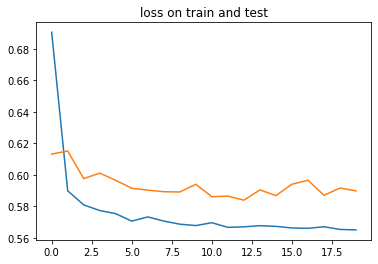

Last loss on train: 0.5650967161739822
Last loss on test: 0.5898510500004417


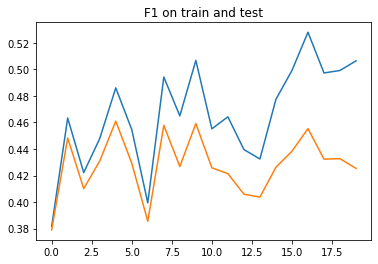

Last F1 on train: 0.5064156919190314
Last F1 on test: 0.42533307404894577


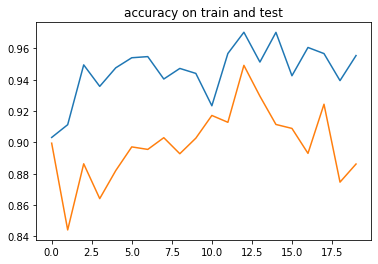

Last accuracy on train: 0.9554753256055106
Last accuracy on test: 0.8862036231317019


In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('loss on train and test')
plt.show()
print('Last loss on train: {}'.format(losses[-1]))
print('Last loss on test: {}'.format(losses_eval[-1]))

plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('F1 on train and test')
plt.show()
print('Last F1 on train: {}'.format(f1s[-1]))
print('Last F1 on test: {}'.format(f1s_eval[-1]))

plt.plot(accuracies)
plt.plot(accuracy_eval)
plt.title('accuracy on train and test')
plt.show()
print('Last accuracy on train: {}'.format(accuracies[-1]))
print('Last accuracy on test: {}'.format(accuracy_eval[-1]))

## Errors on test

In [ ]:
model.eval()
all_prevs = []
all_texts = []
all_preds = []
all_ys = []
for prev_x, x, y in test_iterator:
  preds = model(prev_x, x)
  all_prevs.append(prev_x)
  all_texts.append(x)
  all_preds.append(preds)
  all_ys.append(y)

prev_context = []
pred_answer = []
true_answer= []
for prev_xs, xs, preds, ys in zip(all_prevs, all_texts, all_preds, all_ys):
  shape = preds.shape
  preds = torch.argmax(preds, dim=2).tolist()
  for num, pred in enumerate(preds):
    pred = [id2subject[p] for p in pred]
    preds[num] = pred
  ys = ys.tolist()
  for num, y in enumerate(ys):
    y = [id2subject[y_] for y_ in y]
    ys[num] = y
  prev_xs = prev_xs.tolist()
  for num, prev_x in enumerate(prev_xs):
    prev_x = [id2word[p_x] for p_x in prev_x if id2word[p_x] != 'PAD']
    prev_xs[num] = prev_x
  xs = xs.tolist()
  for num, x in enumerate(xs):
    x = [id2word[x_] for x_ in x]
    xs[num] = x
  for x, pred in zip(xs, preds):
    sent = []
    for x_, p in zip(x, pred):
      token = x_ + '-' + p
      sent.append(token)
    pred_answer.append(sent)
  for x, y in zip(xs, ys):
    sent = []
    for x_, y_ in zip(x, y):
      token = x_ + '-' + y_
      sent.append(token)
    true_answer.append(sent)
  prev_context.extend(prev_xs)

errors = []
correct = []
for context, pred, true in zip(prev_context, pred_answer, true_answer):
  if pred != true:
    errors.append((context, pred, true))
  else:
    correct.append((context, pred, true))

print(f'Sentence accuracy: {len(correct)/len(test_dataset)}')

Sentence accuracy: 0.8331430350840773


In [ ]:
total_count = 0
for context, pred, true in correct:
  count = 0
  for word in pred:
    if word.endswith('-B'):
      count += 1
  if count > 0:
    total_count += 1
    pred = [p for p in pred if p != 'PAD-O']
    print(' '.join(pred))

print(f'Доля предложений с ДФ среди правильных {total_count/len(correct)}')

print(f'Количество предложений с ДФ среди правильных {total_count}')

ganz-B und-I gar-I nicht-I .-O
hör-B auf-I !-O
es-B geht-I nicht-I !-O
du-O weißt-O doch-O ,-O dass-O ich-O das-O nicht-O mit-O absicht-O gema-O ...-O ja-O ,-O schon-B klar-I .-O
na-B gut-I .-O
--O keine-B ahnung-I .-O
du-B machst-I witze-I ,-O oder-O ?-O
--O ach-B ja-I ?-O
darum-B geht-I es-I nicht-I .-O
ja-O ,-O aber-O ich-O hab-O das-O gefühl-O ,-O dass-O ihre-O freundin-O ein-O ...-O ein-O zombie-O ist-O ,-O schon-B möglich-I .-O
im-B ernst-I !-O
--O nicht-B wirklich-I .-O
ich-B weiß-I .-O
spinnst-B du-I ?-O !-O
--O hör-B auf-I .-O
du-B hast-I recht-I .-O
stimmt-B 's-I ,-O herr-O doktor-O ?-O
ist-B schon-I gut-I .-O
--O keine-B ahnung-I .-O
schon-B gut-I .-O
--O das-B stimmt-I nicht-I .-O
also-B gut-I .-O
keine-B ahnung-I .-O
sehr-B gern-I .-O
hör-B auf-I ,-O valiente-O !-O
ich-B weiß-I !-O
--O aber-B natürlich-I .-O
--O na-B klar-I .-O
nein-O ,-O gar-B nicht-I .-O
--O schon-B gut-I .-O
keine-B ahnung-I .-O
--O ich-B bin-I dabei-I .-O
ja-O ,-O nicht-B wahr-I ?-O
ja-O ,-O warum-B ni